## Table of contents:

1. [Data Cleaning](#Cleaning)
2. [Exploratory Data Analysis](#eda)
3. [Feature Engineering](#fe)
4. [Data Spliting](#data_splitting)
5. [Feature Selection](#feature_selection)
6. [Hyperparameter Tuning](#hyperparam) and [Model Choice](#mod_choice)
7. [Forecasting](#test_pr)


In [23]:
# Ignoring warnings
import warnings
warnings.filterwarnings('ignore')

# Data Manipulation
import pandas as pd

# enabling full display of a row content in a data frame
pd.set_option('display.max_colwidth', None)

# Option to suppress scientific notation in Pandas
pd.set_option('display.float_format', lambda x: '%.3f' % x)

import numpy as np
from scipy import stats
import math
import itertools
import random

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import plot_tree

# DevOps modules
import os
import time

# Feature Selection
from sklearn.feature_selection import RFECV
from sklearn.inspection import permutation_importance

# Modelling
from sklearn.multioutput import RegressorChain
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# HyperParameter Tuning
import optuna

# Data Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Neural Network
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.losses import MeanSquaredError

# Tuning Neural Network
import keras_tuner as kt

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

In [24]:
# Loading the datasets
train=pd.read_excel('dseats_2024_training_dataset.xlsx')
test=pd.read_csv('dseats_2024_validation_dataset.csv')

In [25]:
train.head()

PRODUCTION DATE Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
0      2014-04-07      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
1      2014-04-08      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
2      2014-04-09      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
3      2014-04-10      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
4      2014-04-11      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   

    FLOW_KIND WELL_TYPE  Downhole Pressure (PSI)  \
0  production        OP                    0.000   
1  production        OP                    0.000   
2  production        OP                    0.000   
3  production        OP                    0.000   
4  production        OP                 4500.454   

   Downhole Temperature (Kelvin)  Average Tubing Pressure  \
0                        273.150                    0.000   
1                        273.150                    0.000   
2                        273.150                    0.000   
3                        273.150                    0.000   
4                        370.026                 4020.535   

   Annulus Pressure (PSI)  AVG WHP (PSI)  Choke Size  \
0                   0.000          0.000       0.000   
1                   0.000          0.000       0.000   
2                   0.000          0.000       0.000   
3                   0.000          0.000       0.000   
4                   0.000        479.919      33.072   

   Oil Production (stb/day)  Gas Volume (scf/day)  Water Production (stb/day)  \
0                     0.000                 0.000                       0.000   
1                     0.000                 0.000                       0.000   
2                     0.000                 0.000                       0.000   
3                     0.000                 0.000                       0.000   
4                     0.000                 0.000                       0.000   

   Gas-oil ratio  
0          0.000  
1          0.000  
2          0.000  
3          0.000  
4          0.000

#### Info about dataset size

In [26]:
# confirming that well type and flow kind have just one value
print('The training Dataset has for {} rows and {} columns'.format(train.shape[0], train.shape[1]))
print('NOTE: Gas-Oil ratio was added via excel')

The training Dataset has for 6925 rows and 17 columns
NOTE: Gas-Oil ratio was added via excel


<a name="Cleaning"></a>
## 1. Data Cleaning

### Column name shortening

In [27]:
# Listing all columns in current training data
train.columns

Index(['PRODUCTION DATE', 'Field Name', 'WELL_BORE_CODE', 'N_WELL_BORE_CODE',
       'WellBore Name', 'FLOW_KIND', 'WELL_TYPE', 'Downhole Pressure (PSI)',
       'Downhole Temperature (Kelvin)', 'Average Tubing Pressure',
       'Annulus Pressure (PSI)', 'AVG WHP (PSI)', 'Choke Size',
       'Oil Production (stb/day)', 'Gas Volume (scf/day)',
       'Water Production (stb/day)', 'Gas-oil ratio'],
      dtype='object')

In [28]:
# Creating a dictionary to map old names to new names
rename_map={'PRODUCTION DATE':'date', 'Downhole Pressure (PSI)':'Downhole_p', 'Downhole Temperature (Kelvin)':'Downhole_t',
            'Average Tubing Pressure':'Average_tp', 'Annulus Pressure (PSI)':'Annulus_p', 'AVG WHP (PSI)':'whp',
            'Oil Production (stb/day)':'oil', 'Gas Volume (scf/day)':'gas', 'Water Production (stb/day)':'water'}

In [29]:
# Renaming columns "INPLACE"
train.rename(columns=rename_map, inplace=True)

In [30]:
# Viewing top 5 rows of the data
train.head()

date Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
0 2014-04-07      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
1 2014-04-08      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
2 2014-04-09      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
3 2014-04-10      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   
4 2014-04-11      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   

    FLOW_KIND WELL_TYPE  Downhole_p  Downhole_t  Average_tp  Annulus_p  \
0  production        OP       0.000     273.150       0.000      0.000   
1  production        OP       0.000     273.150       0.000      0.000   
2  production        OP       0.000     273.150       0.000      0.000   
3  production        OP       0.000     273.150       0.000      0.000   
4  production        OP    4500.454     370.026    4020.535      0.000   

      whp  Choke Size   oil   gas  water  Gas-oil ratio  
0   0.000       0.000 0.000 0.000  0.000          0.000  
1   0.000       0.000 0.000 0.000  0.000          0.000  
2   0.000       0.000 0.000 0.000  0.000          0.000  
3   0.000       0.000 0.000 0.000  0.000          0.000  
4 479.919      33.072 0.000 0.000  0.000          0.000

In [31]:
# checking to confirm that well bore name, N_WELL_BORE_CODE and WELL_BORE_CODE are same but was used
# to distinguish different wells
train.groupby(['N_WELL_BORE_CODE', 'WELL_BORE_CODE'])['WellBore Name'].unique()

N_WELL_BORE_CODE  WELL_BORE_CODE  
105               DSEAT-001-F-1 C      [001-F-1 C]
106               DSEAT-001-F-11 H      [001-F-11]
107               DSEAT-001-F-12 H      [001-F-12]
108               DSEAT-001-F-14 H      [001-F-14]
109               DSEAT-001-F-15 D    [001-F-15 D]
Name: WellBore Name, dtype: object

In [32]:
# confirming that well type and flow kind have just one value
print('Unique Values for {} are {} and unique values for {} are {}'\
    ' and unique values for {} are {}'.format('FLOW_KIND', train['FLOW_KIND'].unique(),
                                               'WELL_TYPE', train['WELL_TYPE'].unique(), 
                                             'Field Name', train['Field Name'].unique()))

Unique Values for FLOW_KIND are ['production'] and unique values for WELL_TYPE are ['OP' 'WI'] and unique values for Field Name are ['DSEAT']


In [33]:
# Checking for scenarios where WELL type is 'WI'
train[train.WELL_TYPE=='WI']

date Field Name   WELL_BORE_CODE  N_WELL_BORE_CODE WellBore Name  \
91 2014-07-07      DSEAT  DSEAT-001-F-1 C               105     001-F-1 C   

     FLOW_KIND WELL_TYPE  Downhole_p  Downhole_t  Average_tp  Annulus_p  \
91  production        WI    3118.516     381.286    2354.898      0.000   

       whp  Choke Size      oil         gas   water  Gas-oil ratio  
91 763.618      24.233 3283.380 2747990.628 971.616        836.940

### Recommendation
It's only one row, it might be a mistake. So, I am removing these two columns as well as they hold no information for our models

In [34]:
# Removing unnecessary columns post confirmation
unnecessary_columns=['N_WELL_BORE_CODE', 'WELL_BORE_CODE', 'FLOW_KIND', 'WELL_TYPE', 'Field Name']
train.drop(unnecessary_columns, axis=1, inplace=True)

In [35]:
train.head()

date WellBore Name  Downhole_p  Downhole_t  Average_tp  Annulus_p  \
0 2014-04-07     001-F-1 C       0.000     273.150       0.000      0.000   
1 2014-04-08     001-F-1 C       0.000     273.150       0.000      0.000   
2 2014-04-09     001-F-1 C       0.000     273.150       0.000      0.000   
3 2014-04-10     001-F-1 C       0.000     273.150       0.000      0.000   
4 2014-04-11     001-F-1 C    4500.454     370.026    4020.535      0.000   

      whp  Choke Size   oil   gas  water  Gas-oil ratio  
0   0.000       0.000 0.000 0.000  0.000          0.000  
1   0.000       0.000 0.000 0.000  0.000          0.000  
2   0.000       0.000 0.000 0.000  0.000          0.000  
3   0.000       0.000 0.000 0.000  0.000          0.000  
4 479.919      33.072 0.000 0.000  0.000          0.000

#### Data Type check

In [36]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6925 entries, 0 to 6924
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   date           6925 non-null   datetime64[ns]
 1   WellBore Name  6925 non-null   object        
 2   Downhole_p     6925 non-null   float64       
 3   Downhole_t     6925 non-null   float64       
 4   Average_tp     6925 non-null   float64       
 5   Annulus_p      6925 non-null   float64       
 6   whp            6925 non-null   float64       
 7   Choke Size     6919 non-null   float64       
 8   oil            6925 non-null   float64       
 9   gas            6925 non-null   float64       
 10  water          6925 non-null   float64       
 11  Gas-oil ratio  6925 non-null   float64       
dtypes: datetime64[ns](1), float64(10), object(1)
memory usage: 649.3+ KB


**Comment**

All columns are correctly parsed

#### Consistency check for Object columns

In [37]:
# confirming that well bore name have just one value for each category
print('Unique Values for {} are {} '.format('WellBore Name', train['WellBore Name'].unique()))

Unique Values for WellBore Name are ['001-F-1 C' '001-F-11' '001-F-12' '001-F-14' '001-F-15 D'] 


**Observation** 

Data is consistent

#### Missing data check

In [38]:
train.isna().sum()

date             0
WellBore Name    0
Downhole_p       0
Downhole_t       0
Average_tp       0
Annulus_p        0
whp              0
Choke Size       6
oil              0
gas              0
water            0
Gas-oil ratio    0
dtype: int64

#### Observation
The dataset has 6 missing values for Choke size.

**Recommendations**
- On inspecting manually, it's evident that all values should be 0. This is a small set of missing values but the situation could be more complex. 
- Thus, I prompted for forward filling which is a typical approach to handle missing values in time series forecasting problems. This forward filling comfortably filled 4/6 with 0s and the rest with non-zero. But I am confident that this won't impact the model learning in anyway as there's a lot more data for our models to learn from.


In [39]:
# sorting the dataset by wellbore name and then time
train.sort_values(['WellBore Name', 'date'], inplace=True)

In [40]:
# getting the days with missing values
na_days=train[train['Choke Size'].isna()==True]

In [41]:
train[np.logical_and(train.date.isin(na_days.date), train['WellBore Name']=='001-F-11')]

date WellBore Name  Downhole_p  Downhole_t  Average_tp  Annulus_p  \
452 2013-07-10      001-F-11       0.000     273.150       0.000      0.000   
454 2013-07-12      001-F-11       0.000     273.150       0.000      0.000   
465 2013-07-23      001-F-11       0.000     273.150       0.000      0.000   
468 2013-07-26      001-F-11       0.000     273.150       0.000      0.000   
469 2013-07-27      001-F-11       0.000     273.150       0.000      0.000   
472 2013-07-30      001-F-11       0.000     273.150       0.000      0.000   

      whp  Choke Size      oil         gas  water  Gas-oil ratio  
452 0.000         NaN    0.000       0.000  0.000          0.000  
454 0.000         NaN    0.000       0.000  0.000          0.000  
465 0.000         NaN    0.000       0.000  0.000          0.000  
468 0.000         NaN 5607.409 4637945.215  0.000        827.110  
469 0.000         NaN 5575.582 4751970.216  0.000        852.282  
472 0.000         NaN 6493.670 5502022.851  0.000        847.290

In [42]:
# Applying forward fill in handling missing values
train.fillna(method='ffill', inplace=True)

In [43]:
# showing the same days to be sure missing values were filled correctly and they are.
train[np.logical_and(train.date.isin(na_days.date), train['WellBore Name']=='001-F-11')]

date WellBore Name  Downhole_p  Downhole_t  Average_tp  Annulus_p  \
452 2013-07-10      001-F-11       0.000     273.150       0.000      0.000   
454 2013-07-12      001-F-11       0.000     273.150       0.000      0.000   
465 2013-07-23      001-F-11       0.000     273.150       0.000      0.000   
468 2013-07-26      001-F-11       0.000     273.150       0.000      0.000   
469 2013-07-27      001-F-11       0.000     273.150       0.000      0.000   
472 2013-07-30      001-F-11       0.000     273.150       0.000      0.000   

      whp  Choke Size      oil         gas  water  Gas-oil ratio  
452 0.000       0.000    0.000       0.000  0.000          0.000  
454 0.000       0.000    0.000       0.000  0.000          0.000  
465 0.000       0.000    0.000       0.000  0.000          0.000  
468 0.000      72.955 5607.409 4637945.215  0.000        827.110  
469 0.000      72.955 5575.582 4751970.216  0.000        852.282  
472 0.000       0.000 6493.670 5502022.851  0.000        847.290

#### Duplicates Check

In [44]:
dup = train.duplicated()

In [45]:
train[dup]

Empty DataFrame
Columns: [date, WellBore Name, Downhole_p, Downhole_t, Average_tp, Annulus_p, whp, Choke Size, oil, gas, water, Gas-oil ratio]
Index: []

There are no duplicate entries in the dataset

### Helper Functions

In [46]:
# Summary statistics for oil well
def stats(data):
    '''Gets 25th, 75th percentile stats, mean, min and max'''
    return np.percentile(data, 25), np.mean(data), np.percentile(data, 75), np.min(data), np.max(data)

def date_stats(data):
    '''Returns just min and max values from the list provided'''
    return np.min(data), np.max(data)

def scale_datasets(X_train, X_test, kind= 'standard'):
    '''Performs minmax or standard scaling on train and test datasets'''
    if kind == 'standard':
        scaler = StandardScaler()
        x_train_scaled = pd.DataFrame(
          scaler.fit_transform(X_train),
          columns=X_train.columns
      )
        x_test_scaled = pd.DataFrame(
          scaler.transform(X_test),
          columns = X_test.columns
      )
    elif kind == 'min':
        scaler = MinMaxScaler(clip = True)
        x_train_scaled = pd.DataFrame(
          scaler.fit_transform(X_train),
          columns=X_train.columns
      )
        x_test_scaled = pd.DataFrame(
          scaler.transform(X_test),
          columns = X_test.columns
      )
    return scaler, x_train_scaled, x_test_scaled

def slice_(val):
    '''Used in properly formating the date in test dataset'''
    return val[:10]

def clip(val):
    '''Sets negative values to 0 after model prediction'''
    if val<=0:
        val= 0
    else:
        pass
    return val
    
def get_metrics(true, pred):
    '''Gets metric values after prediction'''
    rmse = np.sqrt(mean_squared_error(true, pred))
    mae = mean_absolute_error(true, pred)
    r2 = r2_score(true, pred)
    mape = mean_absolute_percentage_error(true, pred)
    rrmse = np.sqrt((mean_squared_error(true, pred)/mean_squared_error(true, [np.mean(true)]*len(true))))*100
    mbe = 1/len(pred)*np.sum(true.values-pred)
    metric_names = ['rmse', 'mae', 'r2', 'rrmse', 'mbe']
    metric_values =[rmse, mae, r2, rrmse, mbe]
    return metric_names, metric_values

def flatten_extend(matrix):
    '''For flattening a list of lists'''
    flat_list = []
    for row in matrix:
        flat_list.extend(row)
    return flat_list

def process_prediction(scaler, full_test_df, scaled_test_df, pred, value_predicted='oil', unique_wells=[],
                       report=True):
    '''makes a copy of the scaled test df to add the predicted column and inverse transform it. Also adds the 
    well bore name from the full test dataframe and optionally generates a report'''
    test_scaled_cp = scaled_test_df.copy()
    test_scaled_cp[value_predicted]=pred

    test_scaled_cp = pd.DataFrame(scaler.inverse_transform(test_scaled_cp),columns=test_scaled_cp.columns)
    test_scaled_cp[value_predicted]=test_scaled_cp[value_predicted].apply(clip)

    test_scaled_cp['WellBore Name']=full_test_df['WellBore Name'].values
    test_scaled_cp['date']=full_test_df['date'].values

    true=full_test_df[value_predicted]
    pred=test_scaled_cp[value_predicted]
    
    metrics_df=pd.DataFrame(columns=['metrics', 'values'])
    metric_names, metric_values = get_metrics(true, pred)
    metrics_df['metrics']=metric_names
    metrics_df['values']=metric_values
    
    if report is True:
        print('Find the metrics summary below')
        display(metrics_df)
        print('\n')
        
        print('Plotting True values (X axis) vs Predicted values (Y axis)')
        plt.scatter(true, pred)
        plt.xlabel('True '+value_predicted.capitalize()+' Production (stb/day)')
        plt.ylabel('Predicted '+value_predicted.capitalize()+' Production (stb/day)')
        plt.show()
        
        print('Plotting Well Level Performance')
        subplot_locations_v1=list(itertools.product([0,1,2], [0,1]))
        fig, ax = plt.subplots(nrows=3, ncols=2, constrained_layout=True)
        fig.suptitle('Plot for wells True and Predicted '+value_predicted.capitalize()+' Prodiction', fontsize=30)
        fig.set_size_inches(17, 20)

        for w,subplot_loc in zip(unique_wells,subplot_locations_v1[:5]):
            well_true=full_test_df[full_test_df['WellBore Name']==w]
            well_pred=test_scaled_cp[test_scaled_cp['WellBore Name']==w]

            ax[subplot_loc[0],subplot_loc[1]].plot(well_true['date'], well_true[value_predicted], label='True '+value_predicted.capitalize()+' Prod '+w)
            ax[subplot_loc[0],subplot_loc[1]].plot(well_pred['date'], well_pred[value_predicted], label='Pred '+value_predicted.capitalize()+' Prod '+w)
            ax[subplot_loc[0],subplot_loc[1]].tick_params(labelrotation=45)
            ax[subplot_loc[0],subplot_loc[1]].set_xlabel('Date')
            ax[subplot_loc[0],subplot_loc[1]].set_ylabel(value_predicted.capitalize())
            ax[subplot_loc[0],subplot_loc[1]].legend()
        plt.show()
        
    return test_scaled_cp

def recurse(X_train, y_train, model):
    '''Used in performing Recursive feature elimination cross validation which is a feature selection approach'''
    rfecv = RFECV(estimator= model, step=1, scoring = 'neg_mean_squared_error', cv= 5, verbose= 5, n_jobs=-1)
    
    # fitting with data
    rfecv.fit(X_train, y_train)
    
    # reducing the dataset and leaving the n best columns
    # rfecv.transform(X_train)
    model_name = model.__class__.__name__
    best_features = rfecv.get_feature_names_out()
    
    print('Optimal Number of features for {} is: {}'.format(model_name, rfecv.n_features_))
    print(rfecv.get_feature_names_out())
    
    # prints out the mean cv score when n features were used
    print(rfecv.cv_results_['mean_test_score'], '\n')
    
    return model_name, best_features

<a name="eda"></a>
## 2. EDA

### Gas-oil ratio (GOR) analysis across wells
Some formulas already exist to calculate oil discharge for example the Gilberts formula. This formula uses an estimated GOR in it. This led me to do the analysis on GOR

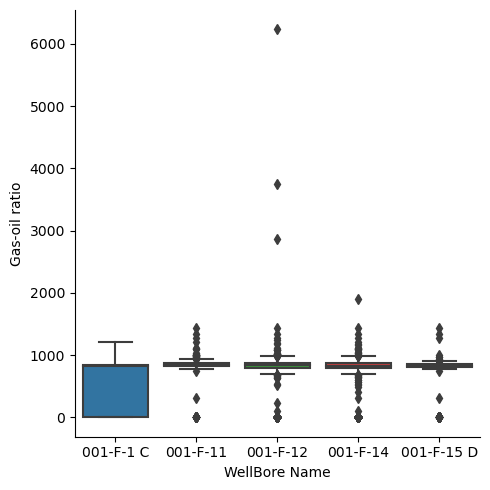

In [47]:
# Distribution of Gas-oil ratio across wellbores
sns.catplot(x='WellBore Name', y='Gas-oil ratio', data=train, kind='box')

#### Observations
- Typically, the gas-oil ratio of a well shouldn't differ this much greatly from the rest as this indicates a much higher gas output than oil for just these three datapoints. 
- As shown below, these datapoints occur on days in three different months and the fact that other datapoint around them do not have same GOR suggests an anomaly perhaps a faulty reading on those three days. As there are only three datapoints, these values were dropped from the training set as they might affect model learning.


In [48]:
# Outlier Datapoints
train[train['Gas-oil ratio']>2000]

date WellBore Name  Downhole_p  Downhole_t  Average_tp  Annulus_p  \
1215 2008-03-28      001-F-12    4051.535     377.864    2714.038      5.969   
1279 2008-06-01      001-F-12    4051.577     377.973    2726.427      4.956   
1705 2009-08-04      001-F-12    4060.721     377.820    2489.771     35.367   

          whp  Choke Size     oil         gas  water  Gas-oil ratio  
1215 1337.497      68.207 461.938 1727456.332  0.818       3739.588  
1279 1325.150      72.697 144.293  414040.760  0.252       2869.452  
1705 1570.950     106.035  75.354  469490.706  0.440       6230.452

In [49]:
# removing these outlier dates
train=train[train['Gas-oil ratio']<2000]

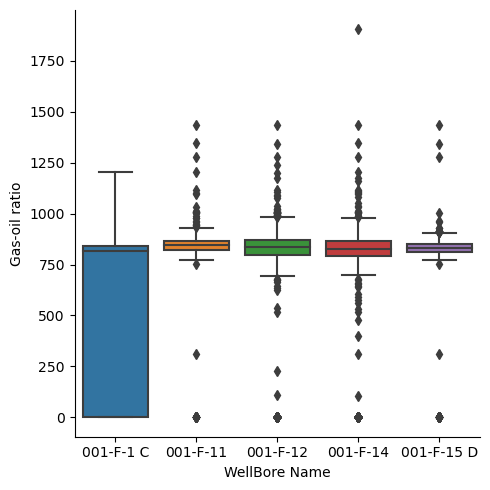

In [50]:
# replotting the distribution
# Distribution of Gas-oil ratio across wellbores
sns.catplot(x='WellBore Name', y='Gas-oil ratio', data=train, kind='box')

In [51]:
# the stats function is used to get the 25th percentile, mean and 75th percentile GOR
train.groupby('WellBore Name', as_index=False)['Gas-oil ratio'].agg(stats)

WellBore Name  \
0     001-F-1 C   
1      001-F-11   
2      001-F-12   
3      001-F-14   
4    001-F-15 D   

                                                                        Gas-oil ratio  
0                (0.0, 551.5296354819213, 838.9248623367649, 0.0, 1206.3519044661675)  
1  (823.0464386950794, 818.3863418038173, 867.5858117621414, 0.0, 1435.7612805832696)  
2  (797.5875747023433, 787.3226181040642, 871.7421831072602, 0.0, 1435.8200279092862)  
3  (793.4793922044855, 755.3330709522115, 868.0983812208347, 0.0, 1904.5011638042195)  
4  (813.7891302407564, 751.0966172511407, 850.5992221497562, 0.0, 1435.7121859339395)

#### Obserrvations
- There's several GORs probably due to the changing choke size
- GORs are similar across oil wells except well 001-F-1 C which seems to have more 0s as the 25th percentile is 0 meaning that 25% of the data has 0 GOR
- This similar GOR indicates a constant relationship between oil and gas. Thus a high correlation and similar behaviour or relationship with other features

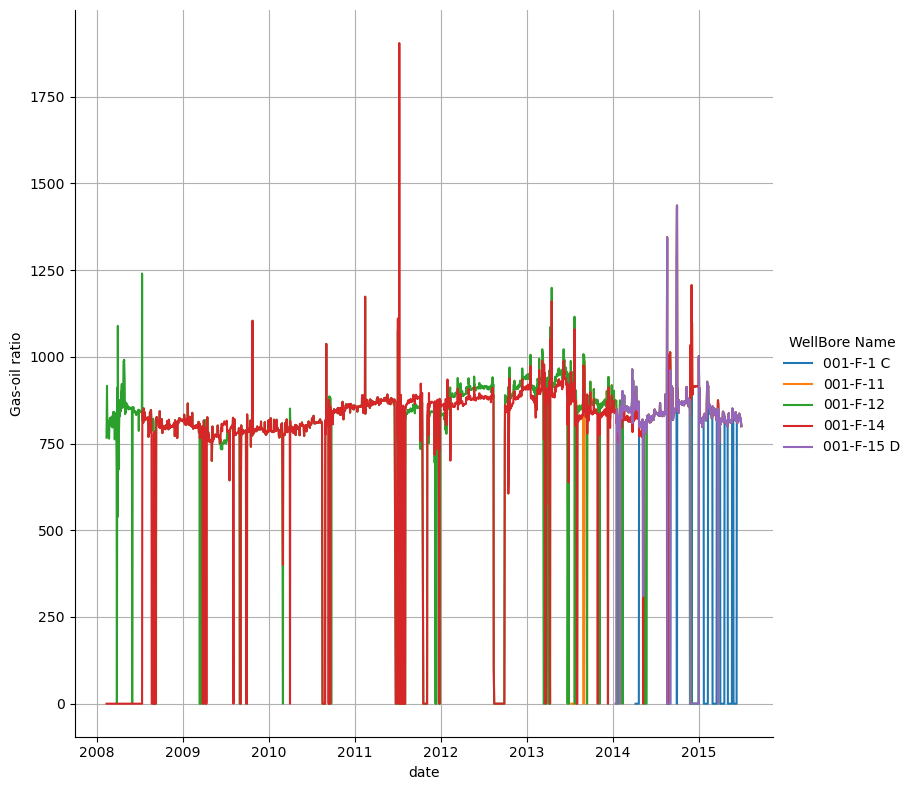

In [52]:
# plotting the GOR overtime in the different wellbores
sns.relplot(x='date', y='Gas-oil ratio', data=train, hue='WellBore Name', kind='line', height=8, aspect=1)
plt.grid()

In [53]:
# The date_stats function is used to display the minimum and maximum dates across wells
train.groupby('WellBore Name', as_index=False)['date'].agg(date_stats)

WellBore Name                                        date
0     001-F-1 C  (2014-04-07 00:00:00, 2015-06-30 00:00:00)
1      001-F-11  (2013-07-08 00:00:00, 2015-06-30 00:00:00)
2      001-F-12  (2008-02-12 00:00:00, 2015-06-30 00:00:00)
3      001-F-14  (2008-02-12 00:00:00, 2015-06-30 00:00:00)
4    001-F-15 D  (2014-01-12 00:00:00, 2015-06-30 00:00:00)

**Observations**
1. The plot suggested that F-12 and F-14 were the oldest bores as others didn't have date up to 2008. Further printing out the min and max dates, it is evident that other wells have 1-2 years of data.

**Recommendations**
1. It will be better if insights from all the wells can be used such that the behaviour is not on a well level. Further visualising the oil and gas production value will provide more insight into this.

### Oil and Gas Production insights

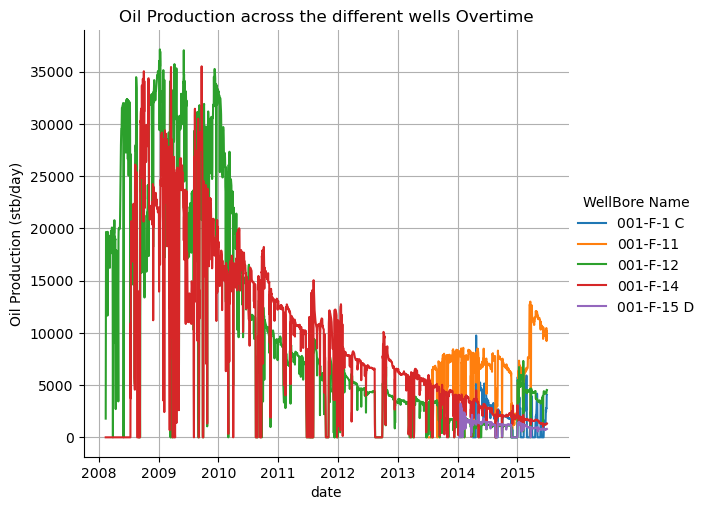

In [54]:
# How is the oil production across wells changing with time?

sns.relplot(x='date', y='oil', data=train, hue='WellBore Name', kind='line', height=5, aspect=1.2)
plt.grid()
plt.title('Oil Production across the different wells Overtime')
plt.ylabel('Oil Production (stb/day)')
plt.savefig('oilforecast.jpg', dpi=500, bbox_inches='tight')

### Observations
1. The wells with the oldest data F-12 and F-14 have a clearly decreasing oil discharge with time but in 2015, the F-12 well increased in discharge while the F-14 remained on the decline.
2. **It's looking like it won't be possible to generate performance of other wells with other wells. More insights towards this claim will be made below.**

### Scaling the features for a plot comparison

In [55]:
columns = train.columns

In [56]:
# getting the list of all float columns
float_cols = []
for col in columns:
    if 'float64' in str(train[col].dtype):
        float_cols.append(col)

In [57]:
float_cols

['Downhole_p',
 'Downhole_t',
 'Average_tp',
 'Annulus_p',
 'whp',
 'Choke Size',
 'oil',
 'gas',
 'water',
 'Gas-oil ratio']

In [58]:
## Summary Statistics of Features across wells before scaling
train.groupby('WellBore Name', as_index=False)[float_cols].agg(date_stats)

WellBore Name                 Downhole_p                Downhole_t  \
0     001-F-1 C          (0.0, 4551.12341)     (273.15, 381.6521779)   
1      001-F-11         (0.0, 4604.493995)       (273.15, 379.84953)   
2      001-F-12         (0.0, 4606.666675)     (273.15, 380.6575517)   
3      001-F-14         (0.0, 4394.683635)     (273.15, 379.9227333)   
4    001-F-15 D  (2827.857561, 4435.78258)  (371.25242, 380.1939533)   

                  Average_tp           Annulus_p                      whp  \
0         (0.0, 4436.650695)          (0.0, 0.0)       (0.0, 1937.091395)   
1         (0.0, 4592.612695)  (0.0, 428.2185494)        (0.0, 1663.27035)   
2          (0.0, 4558.93282)  (0.0, 435.2875078)       (0.0, 1991.009935)   
3          (0.0, 4380.59152)  (0.0, 386.8925163)       (0.0, 1822.919265)   
4  (2228.404208, 4111.25547)   (0.0, 403.316923)  (13.32927, 1712.845415)   

             Choke Size                oil                 gas  \
0      (0.0, 115.63898)   (0.0, 9748.3049)  (0.0, 7826268.043)   
1       (0.0, 90.33041)  (0.0, 12986.3969)  (0.0, 10595915.93)   
2  (0.05771, 124.12299)  (0.0, 37122.5736)  (0.0, 30044942.66)   
3      (0.0, 125.71857)  (0.0, 35503.0873)  (0.0, 27886107.97)   
4   (0.62633, 88.68773)   (0.0, 3227.5248)  (0.0, 2739311.064)   

                      water              Gas-oil ratio  
0          (0.0, 8097.5573)  (0.0, 1206.3519044661675)  
1          (0.0, 5449.2786)  (0.0, 1435.7612805832696)  
2  (-2879.8136, 50444.1646)  (0.0, 1435.8200279092862)  
3   (-372.3051, 35801.2333)  (0.0, 1904.5011638042195)  
4            (0.0, 76.5493)  (0.0, 1435.7121859339395)

### Observation
1. All features (independent variables) across wells have similar max values except for Annulus pressure in well F-1-C which has only Zeros.
2. Minimum Value in well F-15-D is higher than all other minimums.

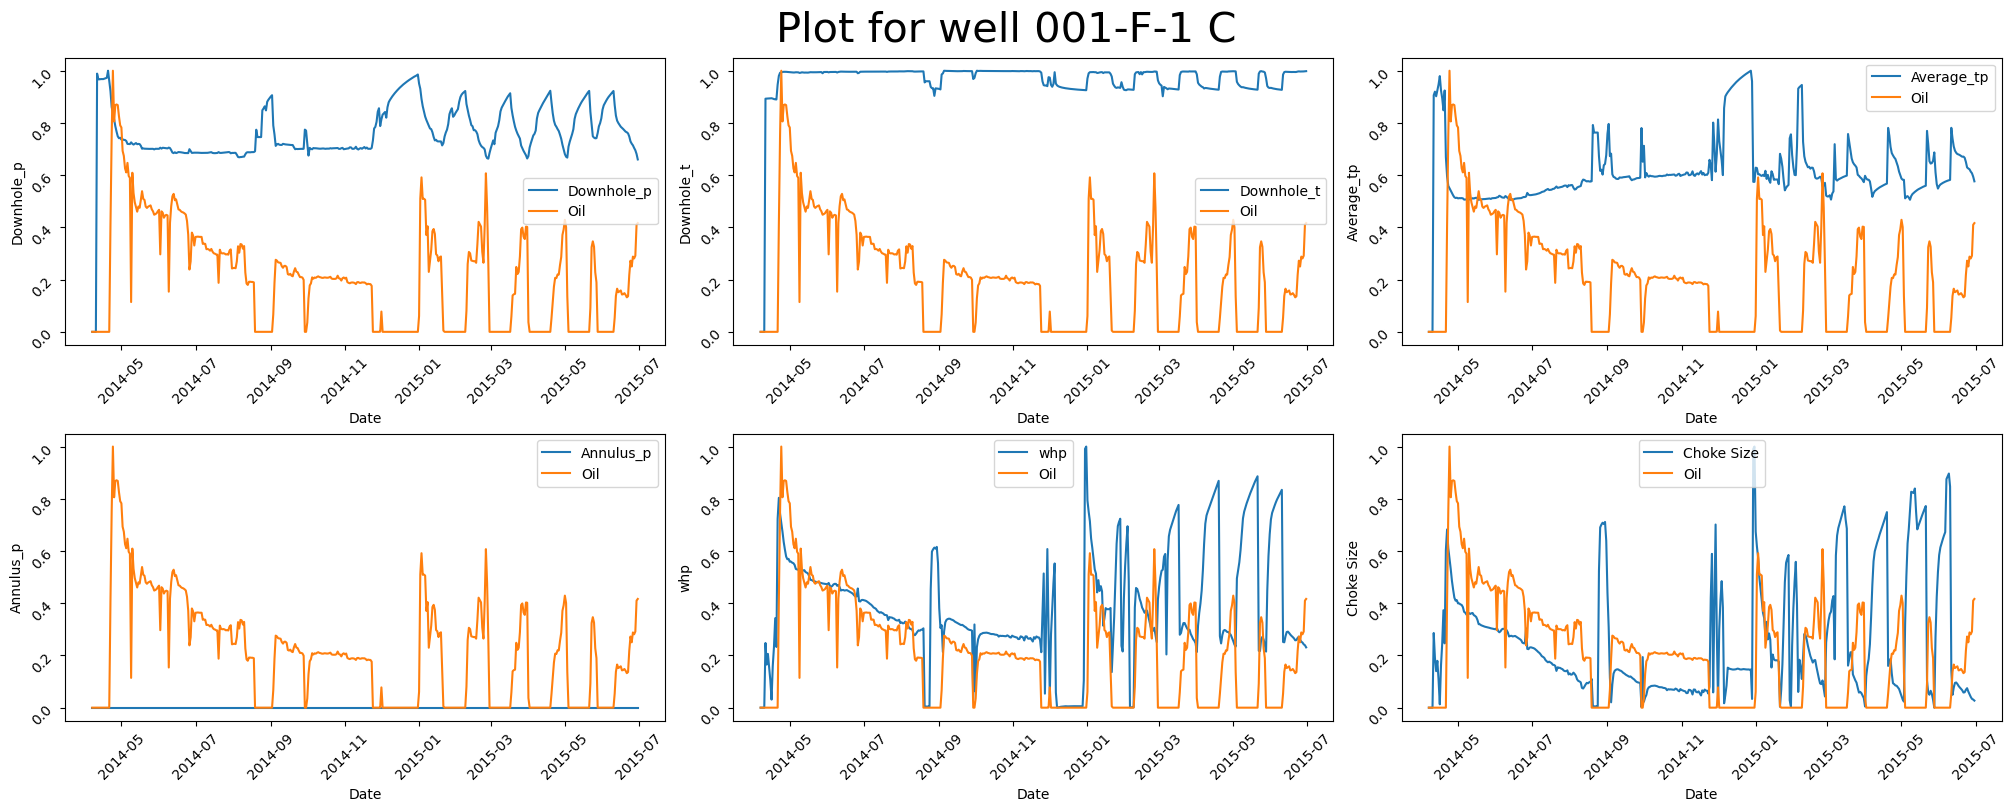

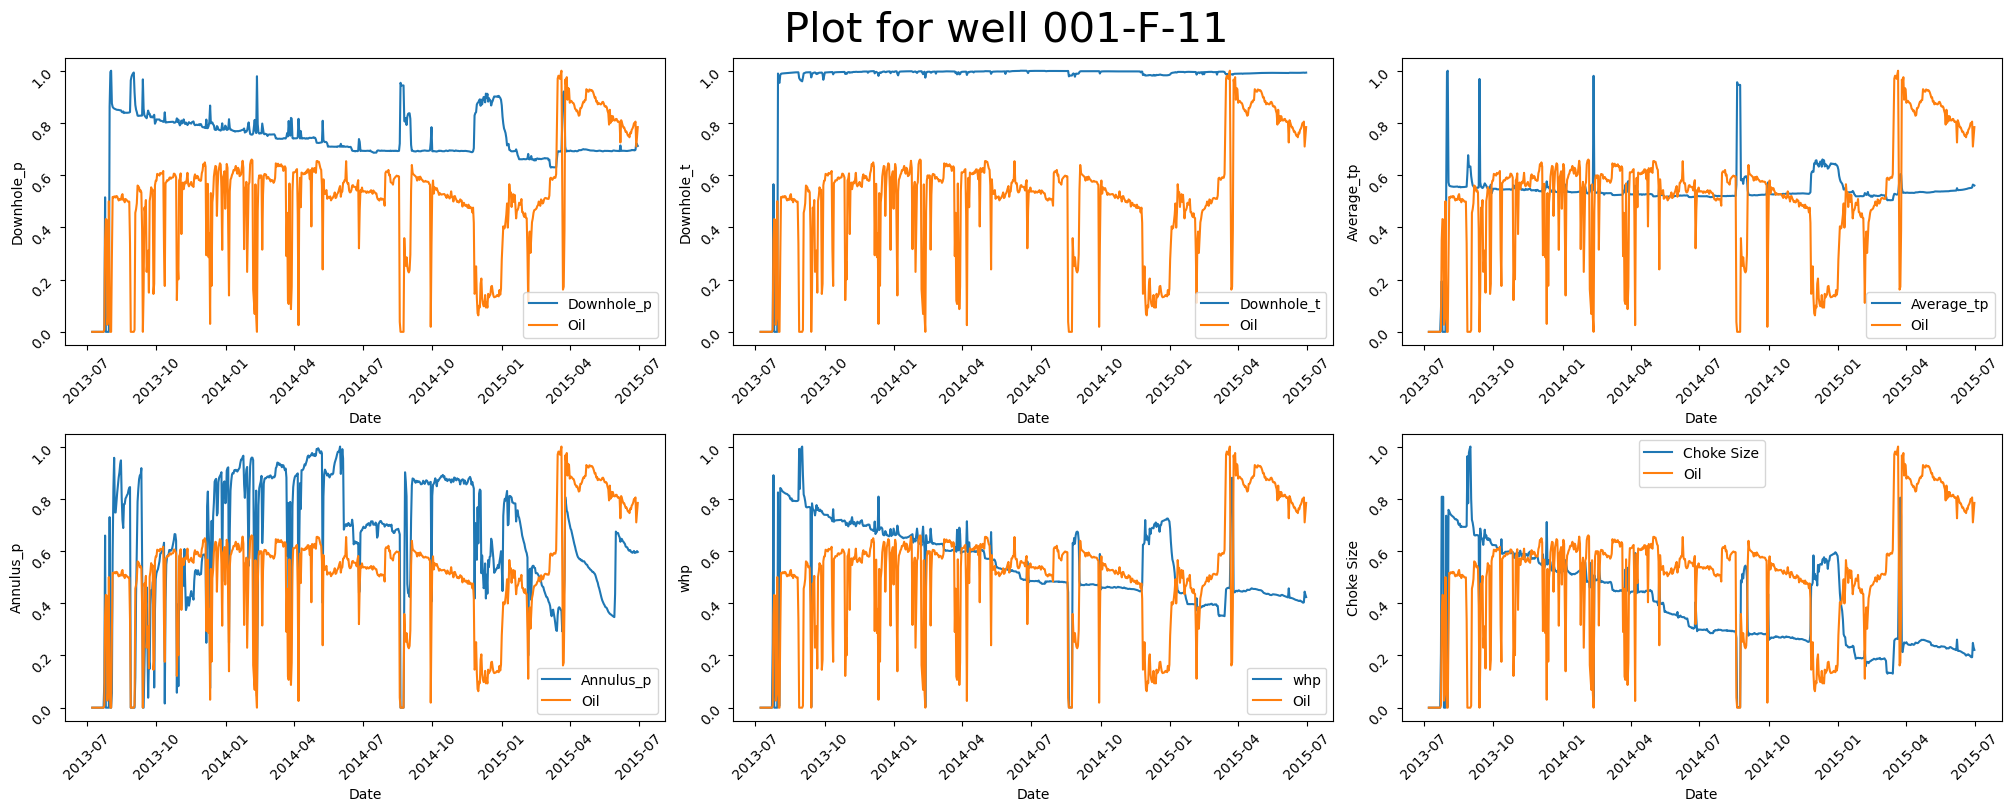

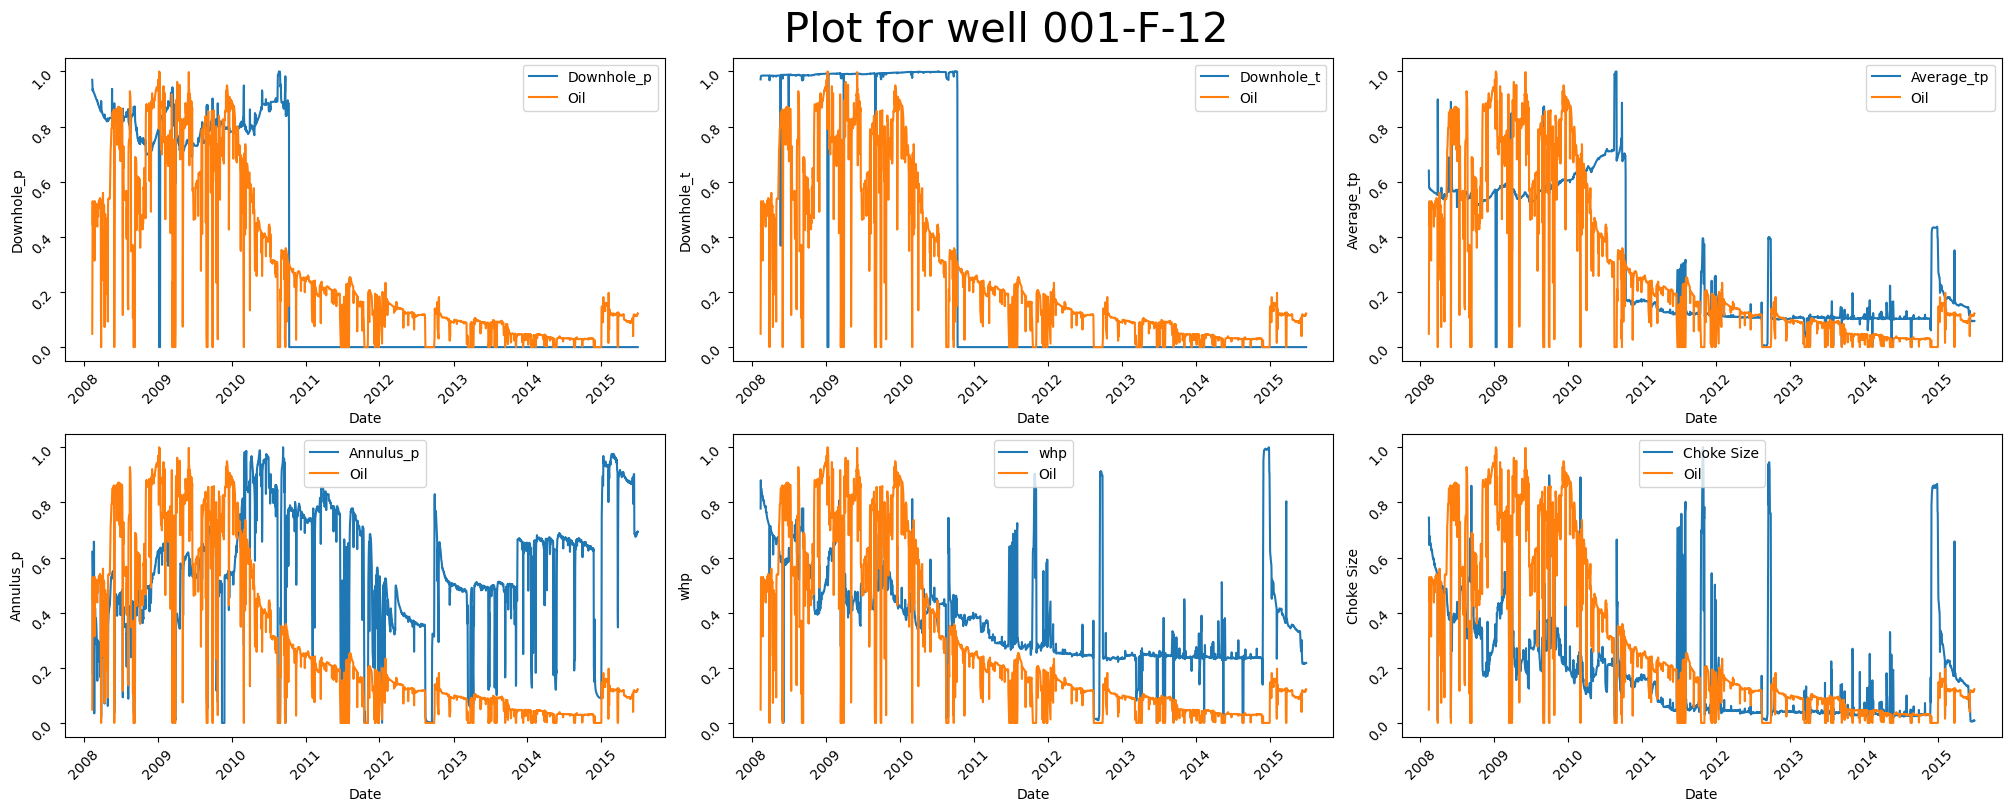

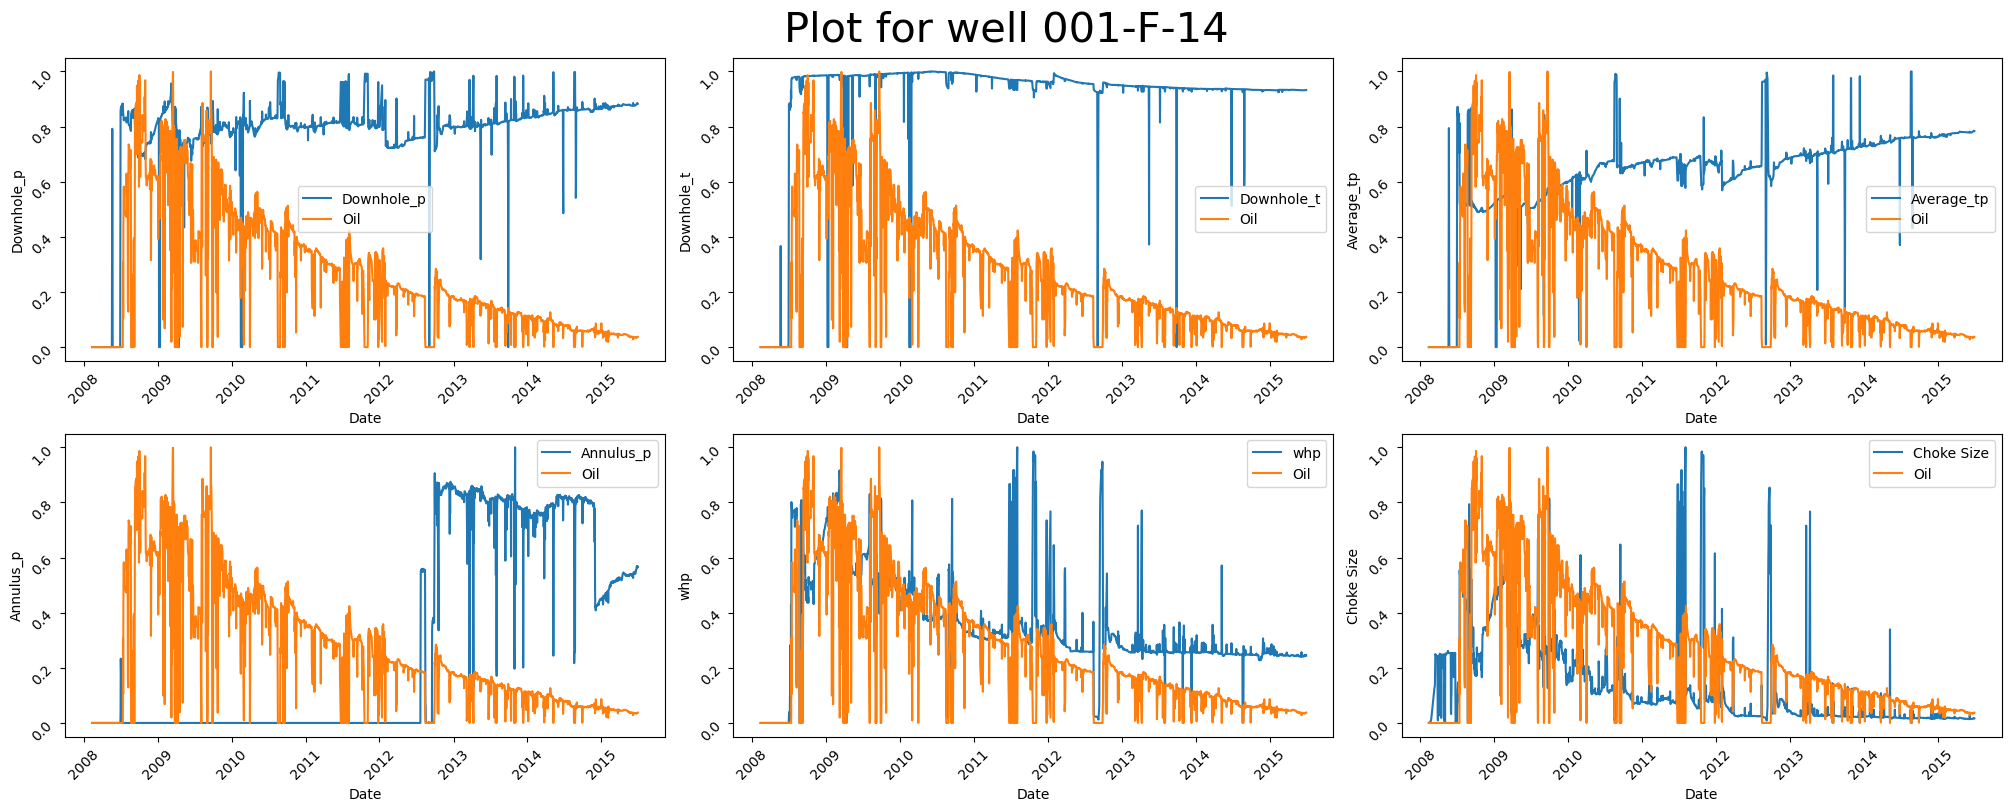

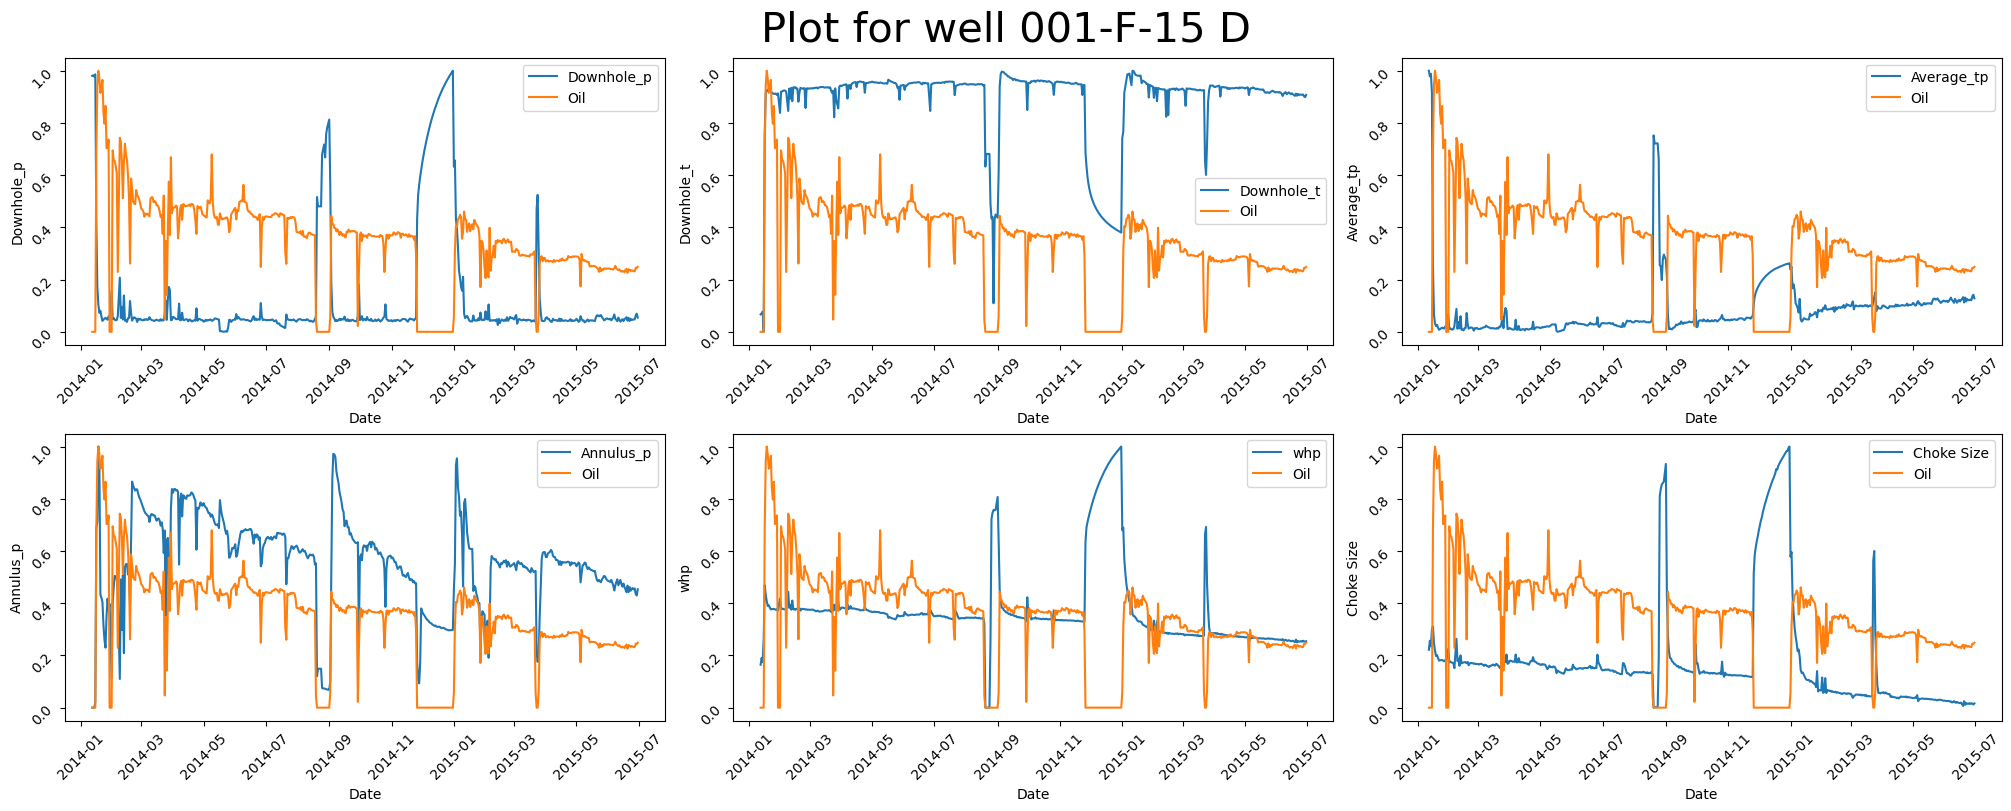

In [59]:
# What's the relationship with of all features with oil production overtime across wells?
subplot_locations=list(itertools.product([0,1,2], [0,1,2]))[:6]

for well in train['WellBore Name'].unique():
    # initializing the scaler
    mm_scaler = MinMaxScaler(clip = True)
    
    fig, ax = plt.subplots(nrows=2, ncols=3, constrained_layout=True)
    fig.suptitle('Plot for well '+well, fontsize=30)
    fig.set_size_inches(20, 8)
    
    well_df_init=train[train['WellBore Name']==well]
    dates=well_df_init.date.values
    well_df=well_df_init.copy()[float_cols]
    well_df = pd.DataFrame(mm_scaler.fit_transform(well_df),columns=float_cols)
    #display(well_df)
    
    # adding back the date column
    well_df['date']=dates
    #display(well_df)
    
    for col1, subplot_location in zip(float_cols[:6], subplot_locations):
        ax[subplot_location[0],subplot_location[1]].plot(well_df['date'], well_df[col1], label=col1)
        ax[subplot_location[0],subplot_location[1]].plot(well_df['date'], well_df['oil'], label='Oil')
        ax[subplot_location[0],subplot_location[1]].tick_params(labelrotation=45)
        ax[subplot_location[0],subplot_location[1]].set_xlabel('Date')
        ax[subplot_location[0],subplot_location[1]].set_ylabel(col1)
        ax[subplot_location[0],subplot_location[1]].legend()
    plt.show()
   

<a name="important_point"></a>
### Observations in Terms of Trends
1. For well 001-F-1 C, the whp and chokesize are the only features seen to have a reasonable relationship with oil production overtime as they both have similar trends although in 2015, we notice an inverse relationship where oil is 0 but features have a high value.
2. For well 001-F-11, the Annulus pressure has the best relationship with oil production.
3. For well 001-F-12, in the end of 2010, the downhole pressure, goes to 0 (this could be because the well had been there for sometime) and remains there for a while, during these periods, the oil production remained low but rose slightly in 2015 but this downhole pressure still remained 0. This could indicate that the feature didn't directly affect oil production after some years of the well being dug. The Average tubing pressure, choke size and well head pressure are the ones with the closest relationship.
4. For well 001-F-14, choke size and well head pressre have the best relationship.
5. For well 001-F-15 D, choke size and well head pressre have the best relationship although we notice an inverse relationship in some instances.

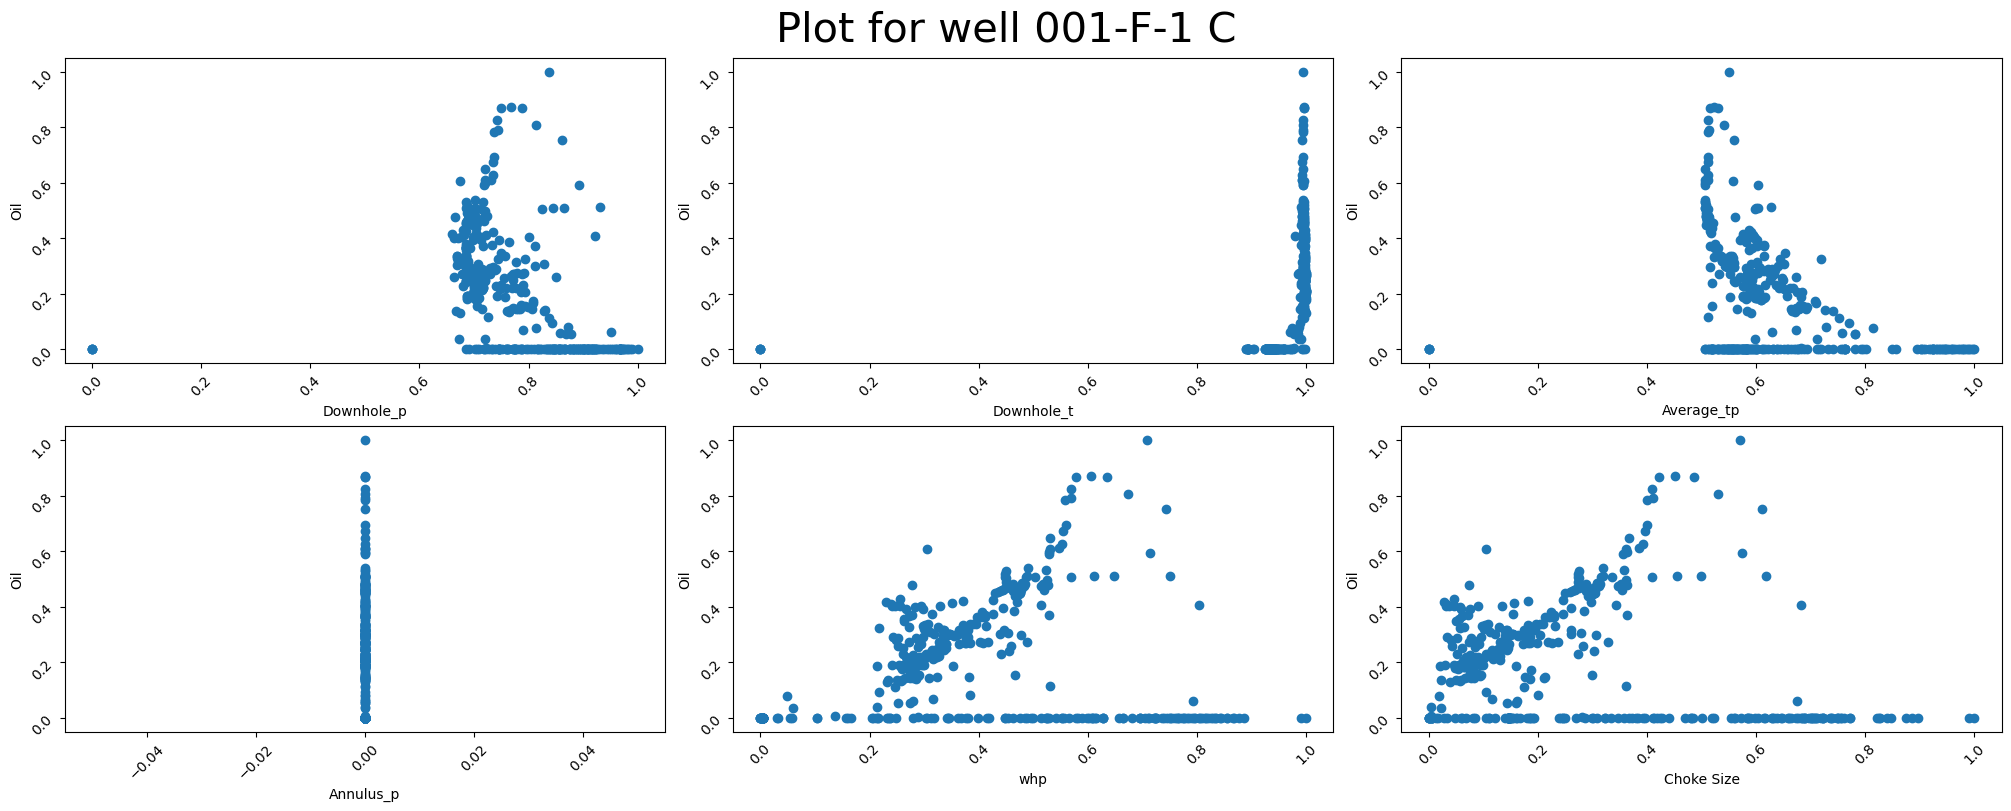

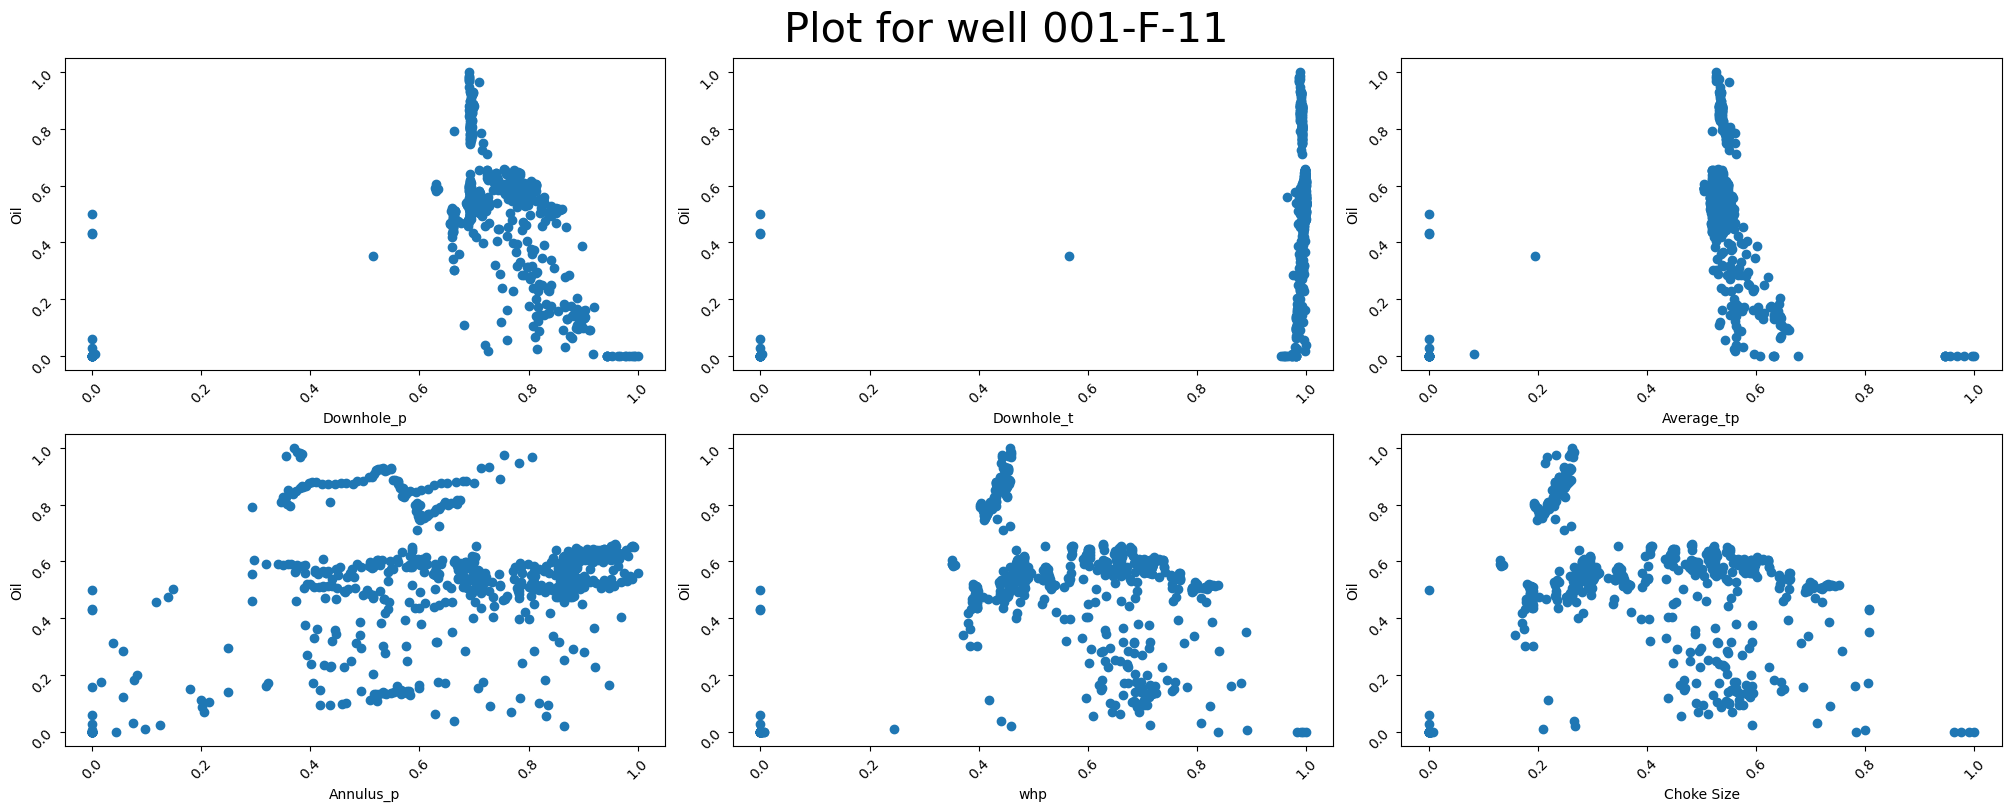

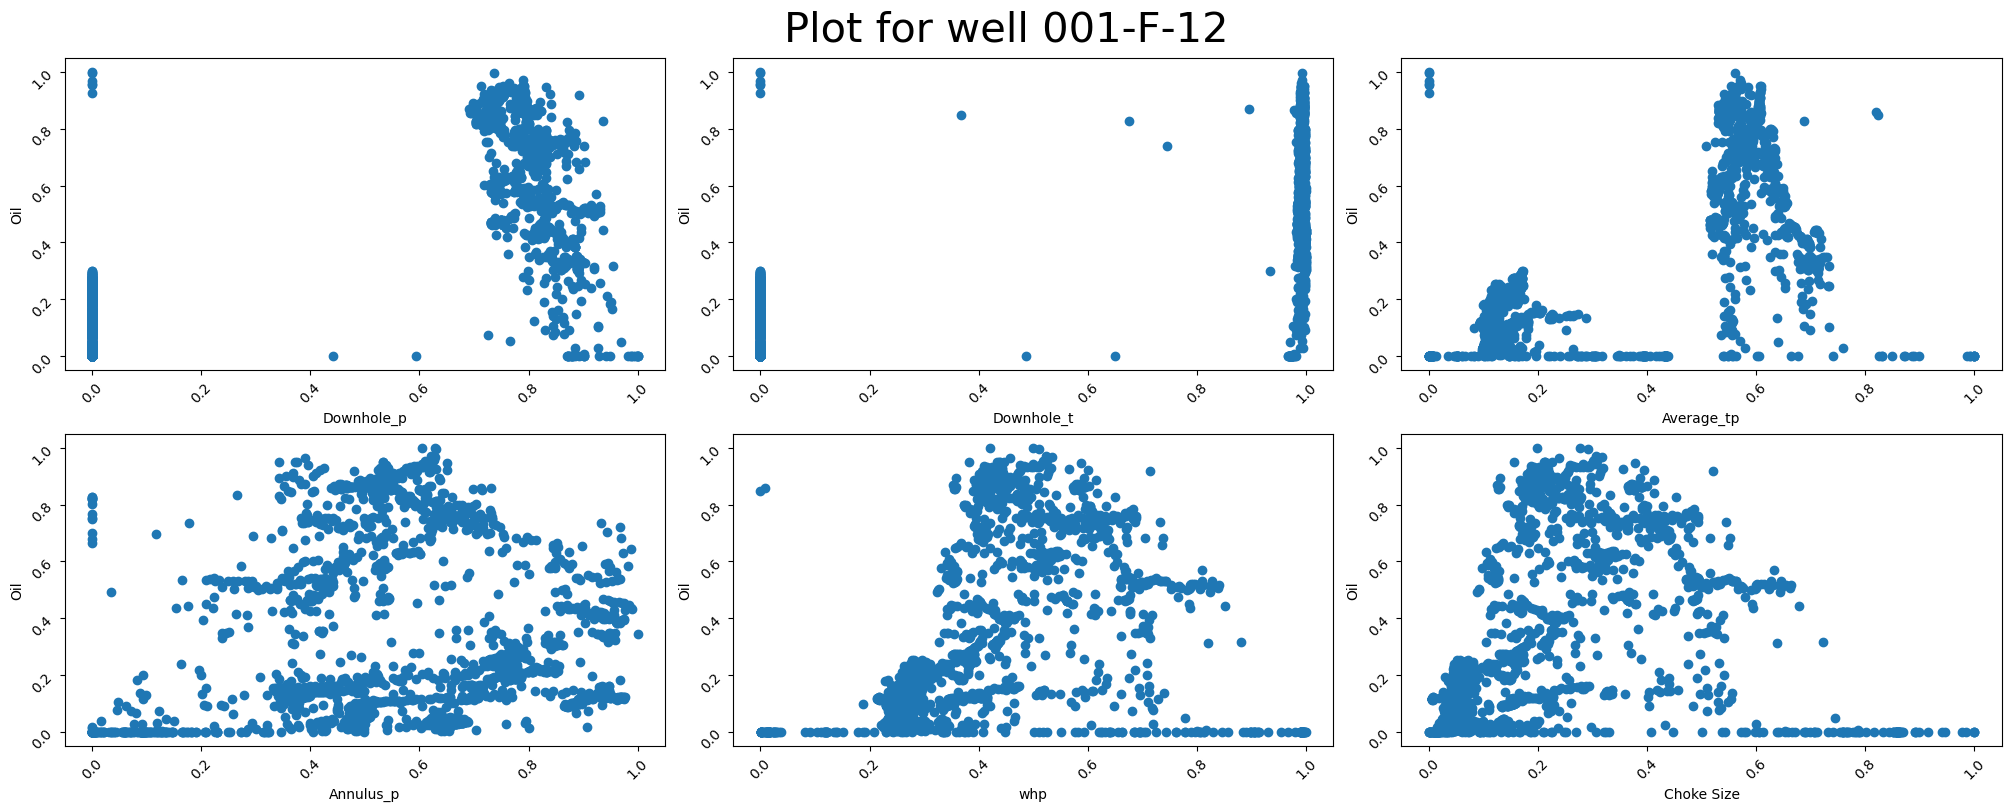

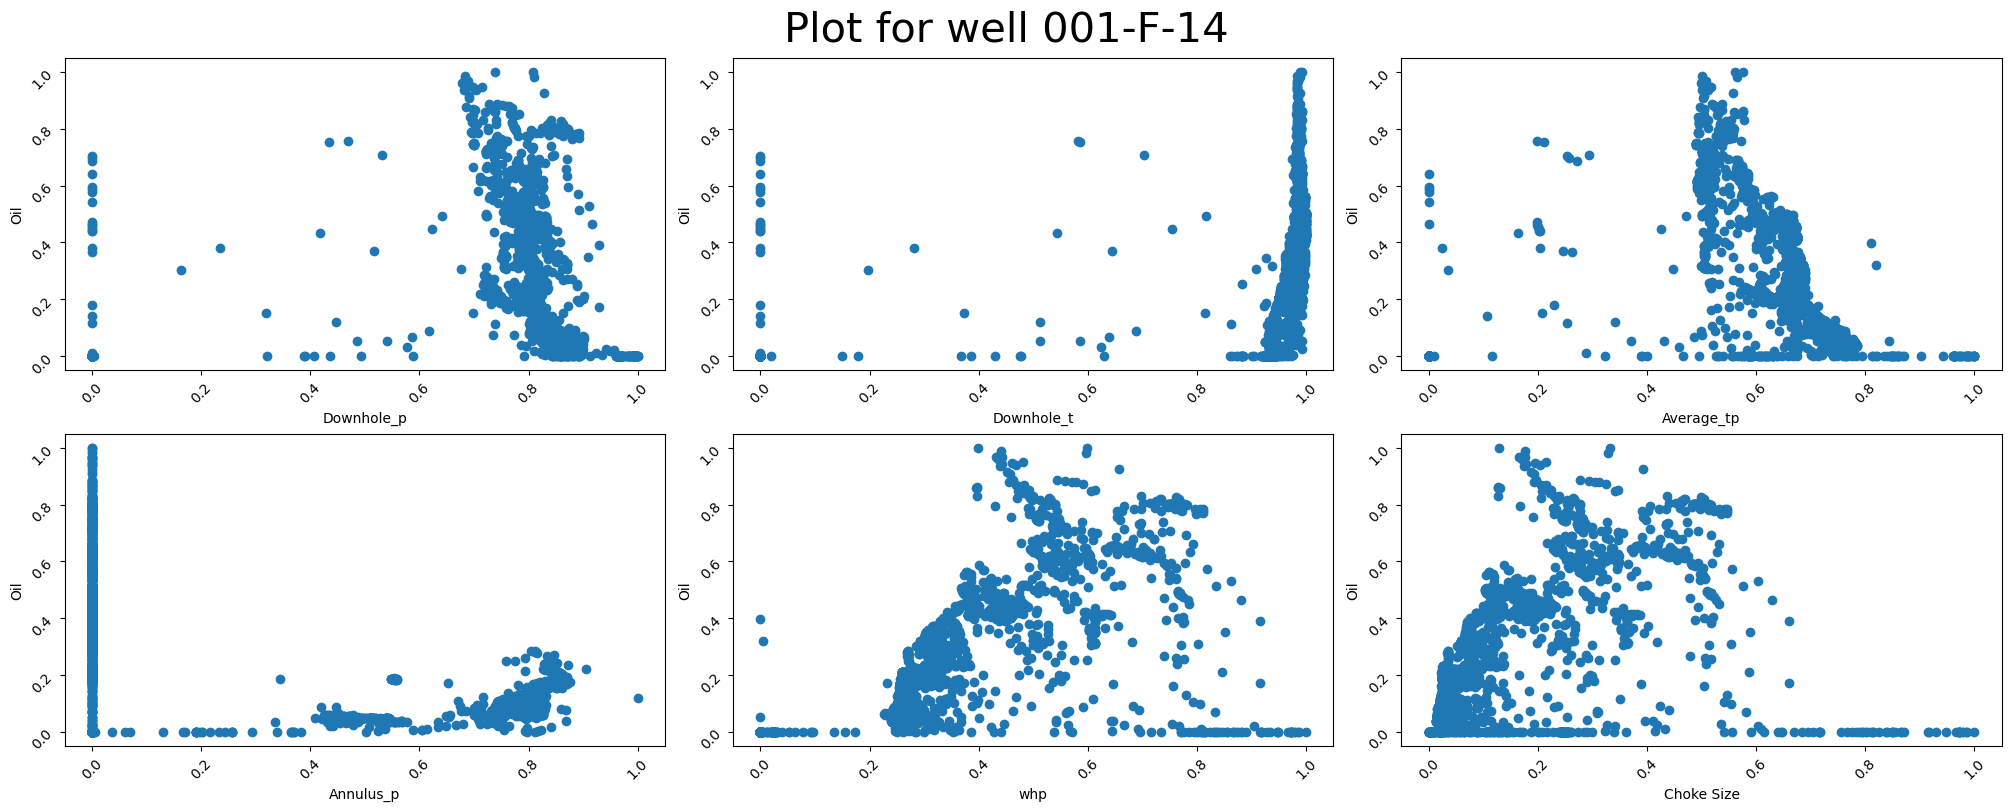

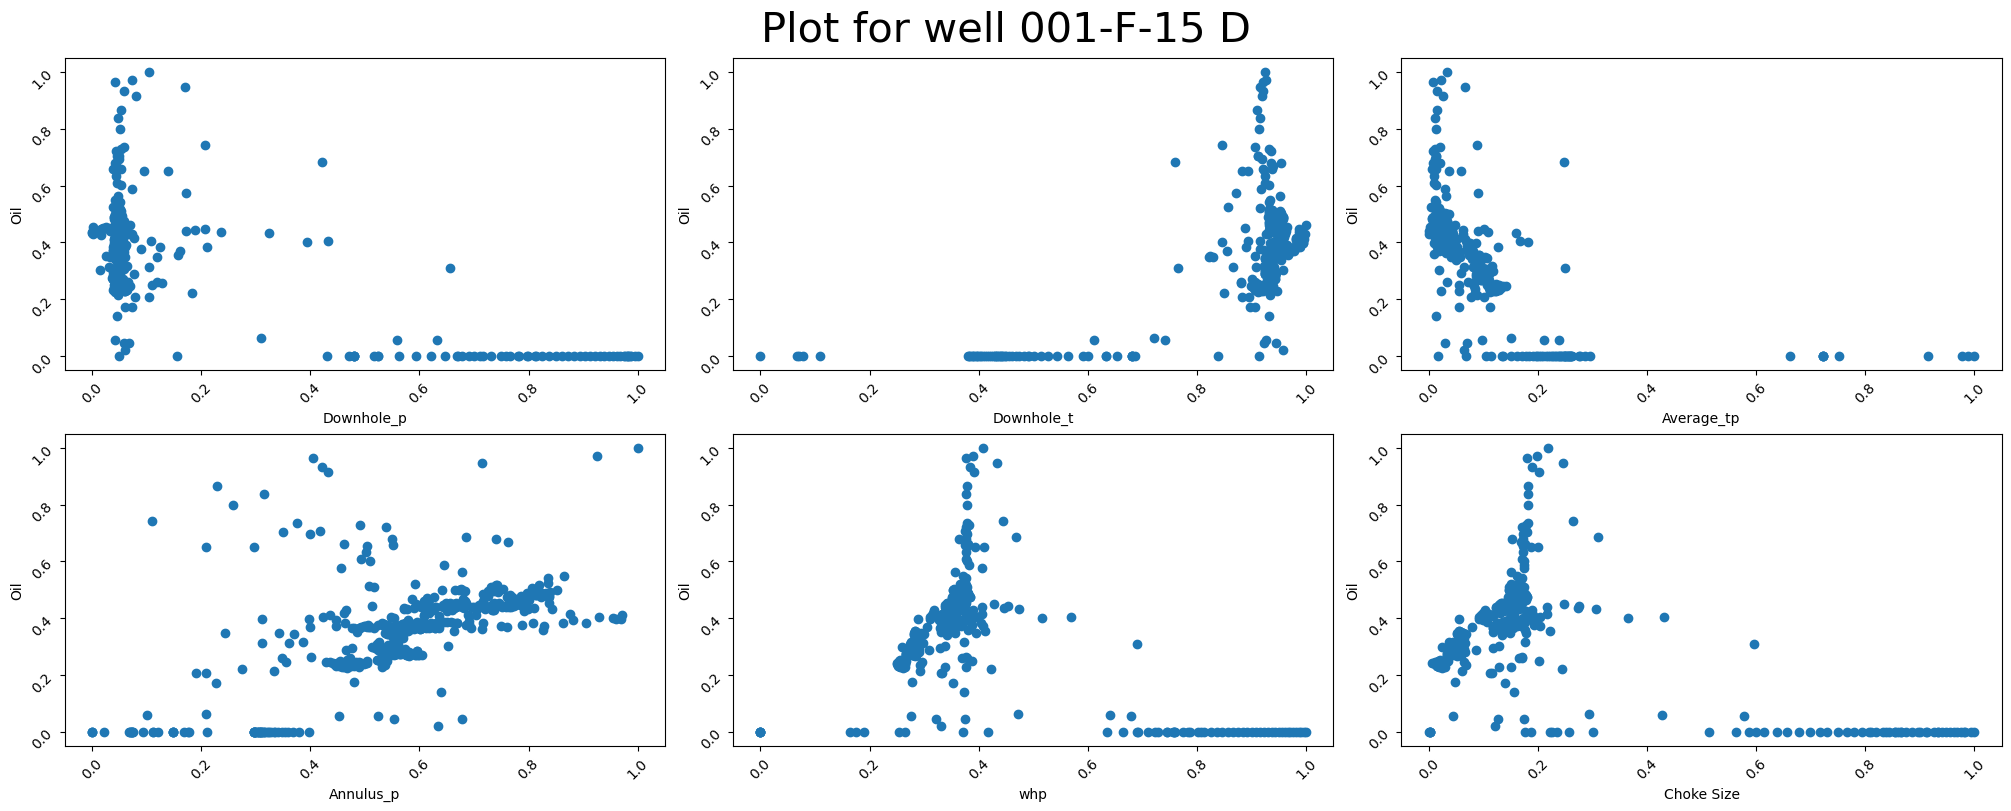

In [60]:
# From the trends, we get a sense of which features trend similarly. Below, we access the linearity of features with oil
for well in train['WellBore Name'].unique():
    # initializing the scaler
    mm_scaler = MinMaxScaler(clip = True)

    fig, ax = plt.subplots(nrows=2, ncols=3, constrained_layout=True)
    fig.suptitle('Plot for well '+well, fontsize=30)
    fig.set_size_inches(20, 8)
    well_df_init=train[train['WellBore Name']==well]
    dates=well_df_init.date.values
    well_df=well_df_init.copy()[float_cols]
    well_df = pd.DataFrame(mm_scaler.fit_transform(well_df),columns=float_cols)
    
    # adding back the date column
    well_df['date']=dates
    
    for col1, subplot_location in zip(float_cols[:6], subplot_locations):
        ax[subplot_location[0],subplot_location[1]].scatter(well_df[col1], well_df['oil'])
        ax[subplot_location[0],subplot_location[1]].tick_params(labelrotation=45)
        ax[subplot_location[0],subplot_location[1]].set_xlabel(col1)
        ax[subplot_location[0],subplot_location[1]].set_ylabel('Oil')
    plt.show()

<a name="corr_plot"></a>
### Correlation plot for wells

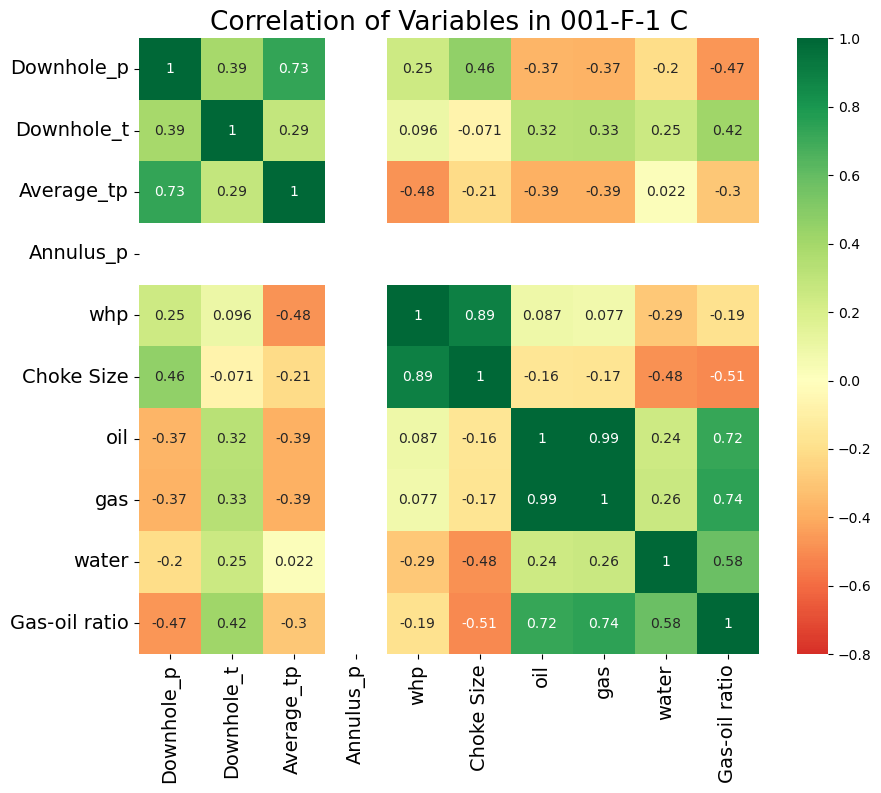

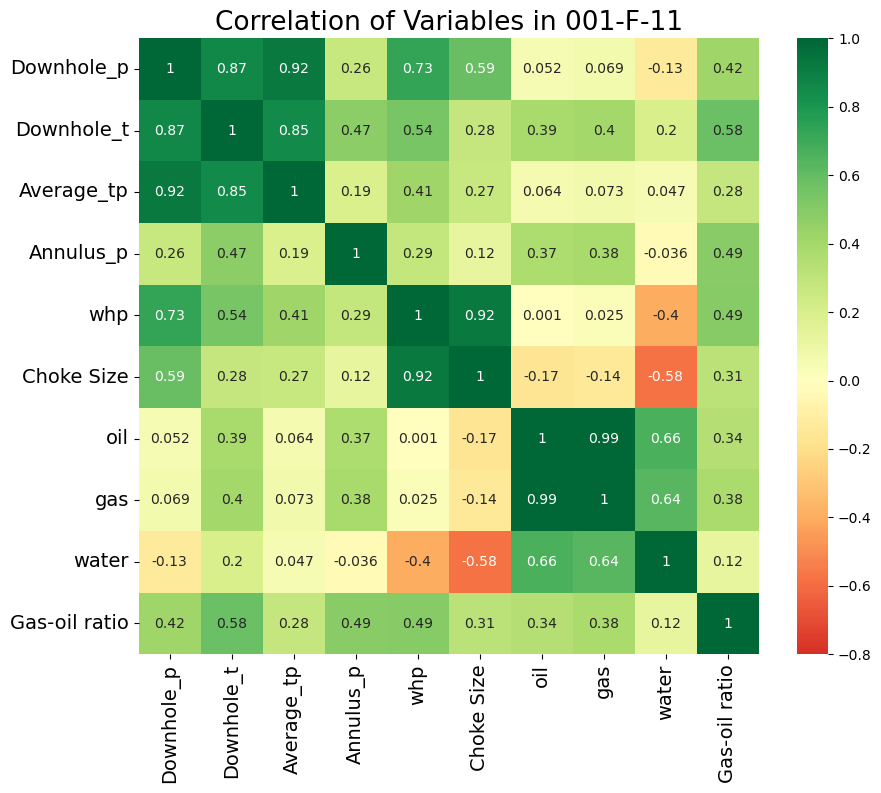

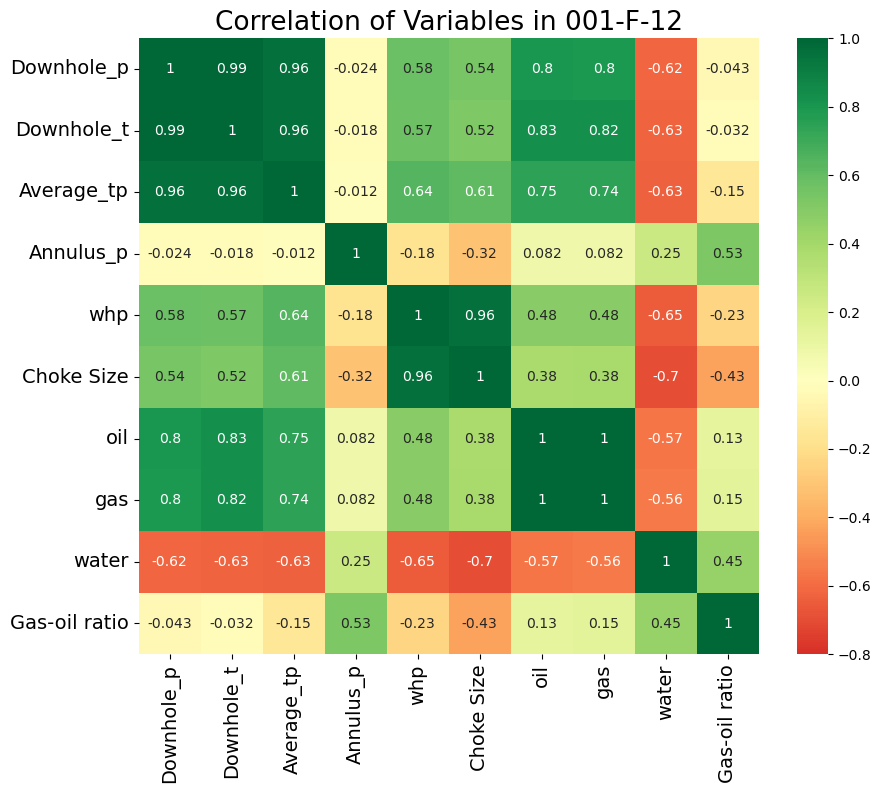

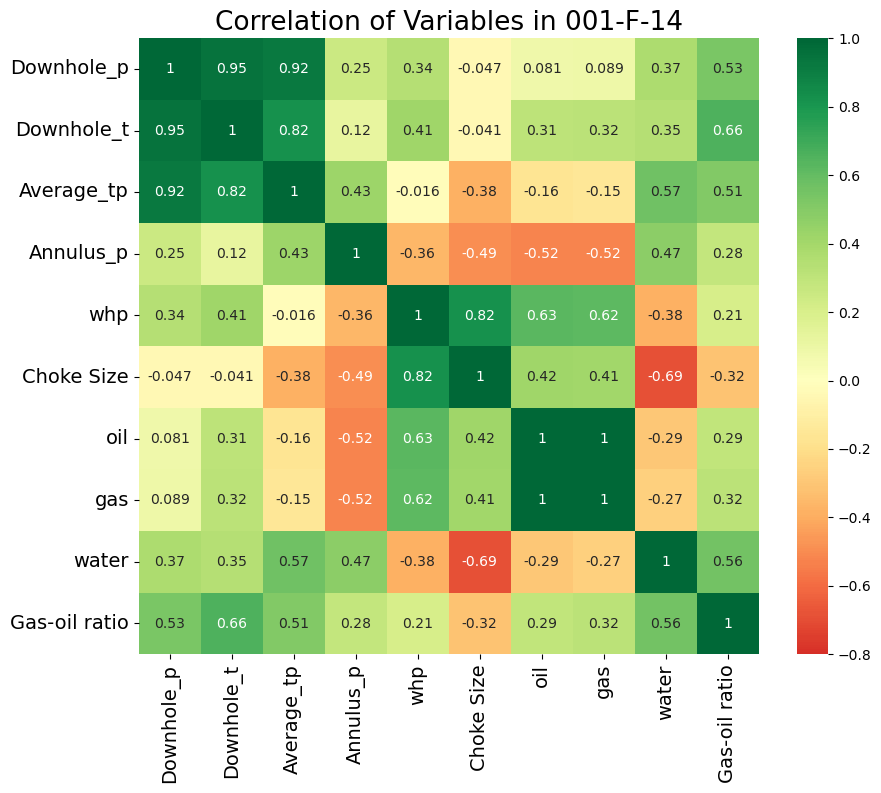

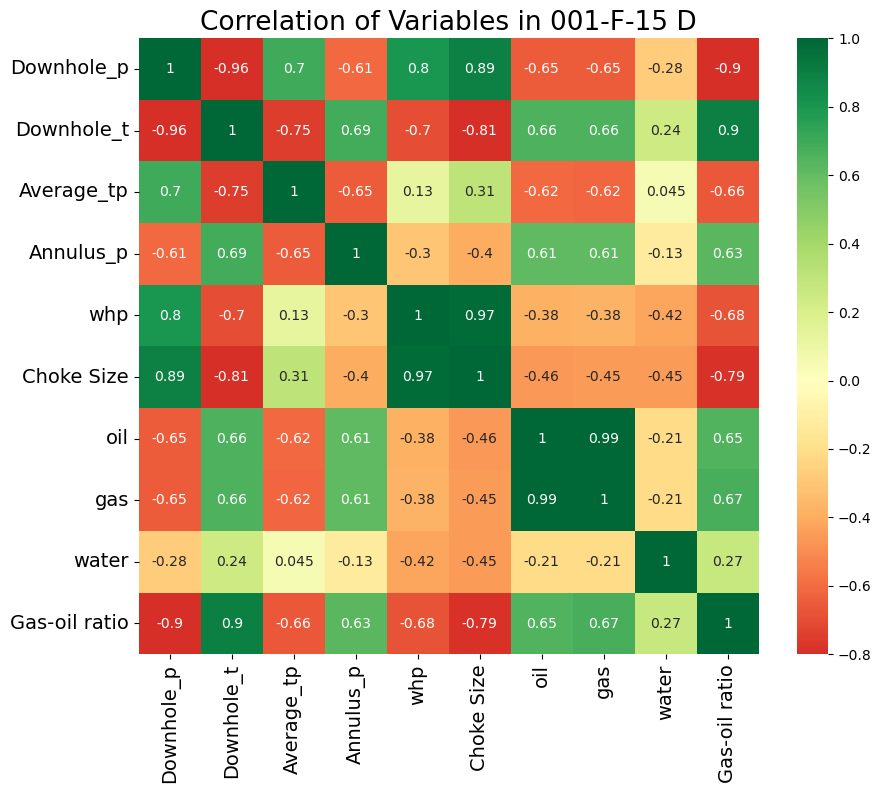

In [61]:
needed_columns=train.columns[2:12]
for well in train['WellBore Name'].unique():
    # initializing the scaler
    mm_scaler = MinMaxScaler(clip = True)
    
    well_df_init=train[train['WellBore Name']==well]
    well_df=well_df_init.copy()[needed_columns]
    well_df = pd.DataFrame(mm_scaler.fit_transform(well_df),columns=needed_columns)

    # Correlation Heatmap 
    corr = well_df.corr()
    fig, ax = plt.subplots()
    fig.set_size_inches(10, 8)
    sns.heatmap(corr.round(3), cmap='RdYlGn', annot = True, center = 0, xticklabels=needed_columns, 
                yticklabels=needed_columns, ax=ax, vmin = -0.8, vmax=1)
    ax.tick_params(labelsize=14)
    plt.title('Correlation of Variables in '+well, fontsize = 19)


### Observations
1. Oil and Gas are perfectly collinear with themselves and thus, have similar correlation with all features. This means Gas relates similarly with all features.
2. Some features have good correlation in some wells for example, all features have strong correlation in F-15 D but in F-14, Downhole pressure and Anulus pressure have a poor correlation. Thus, all features are considered towards modeling.

### Water Insights

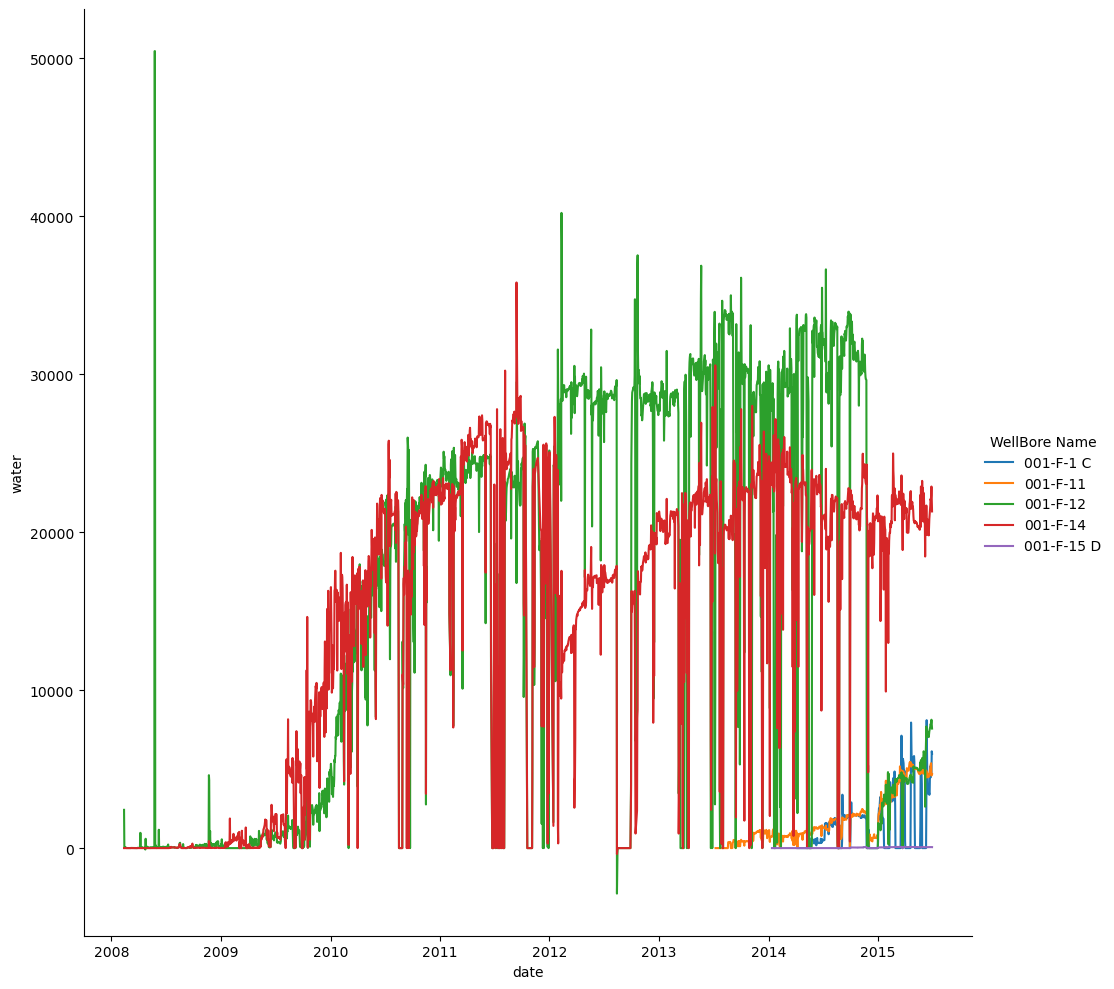

In [62]:
# How is the water production across wells changing with time?

sns.relplot(x='date', y='water', data=train, hue='WellBore Name', kind='line', height=10, aspect=1)

#### Observation
1. Water seems to have an inverse retationship with oil and Gas which we also see from the [correlation plot](#corr_plot) where most wells have a -ve correlation of water with oil and Gas.

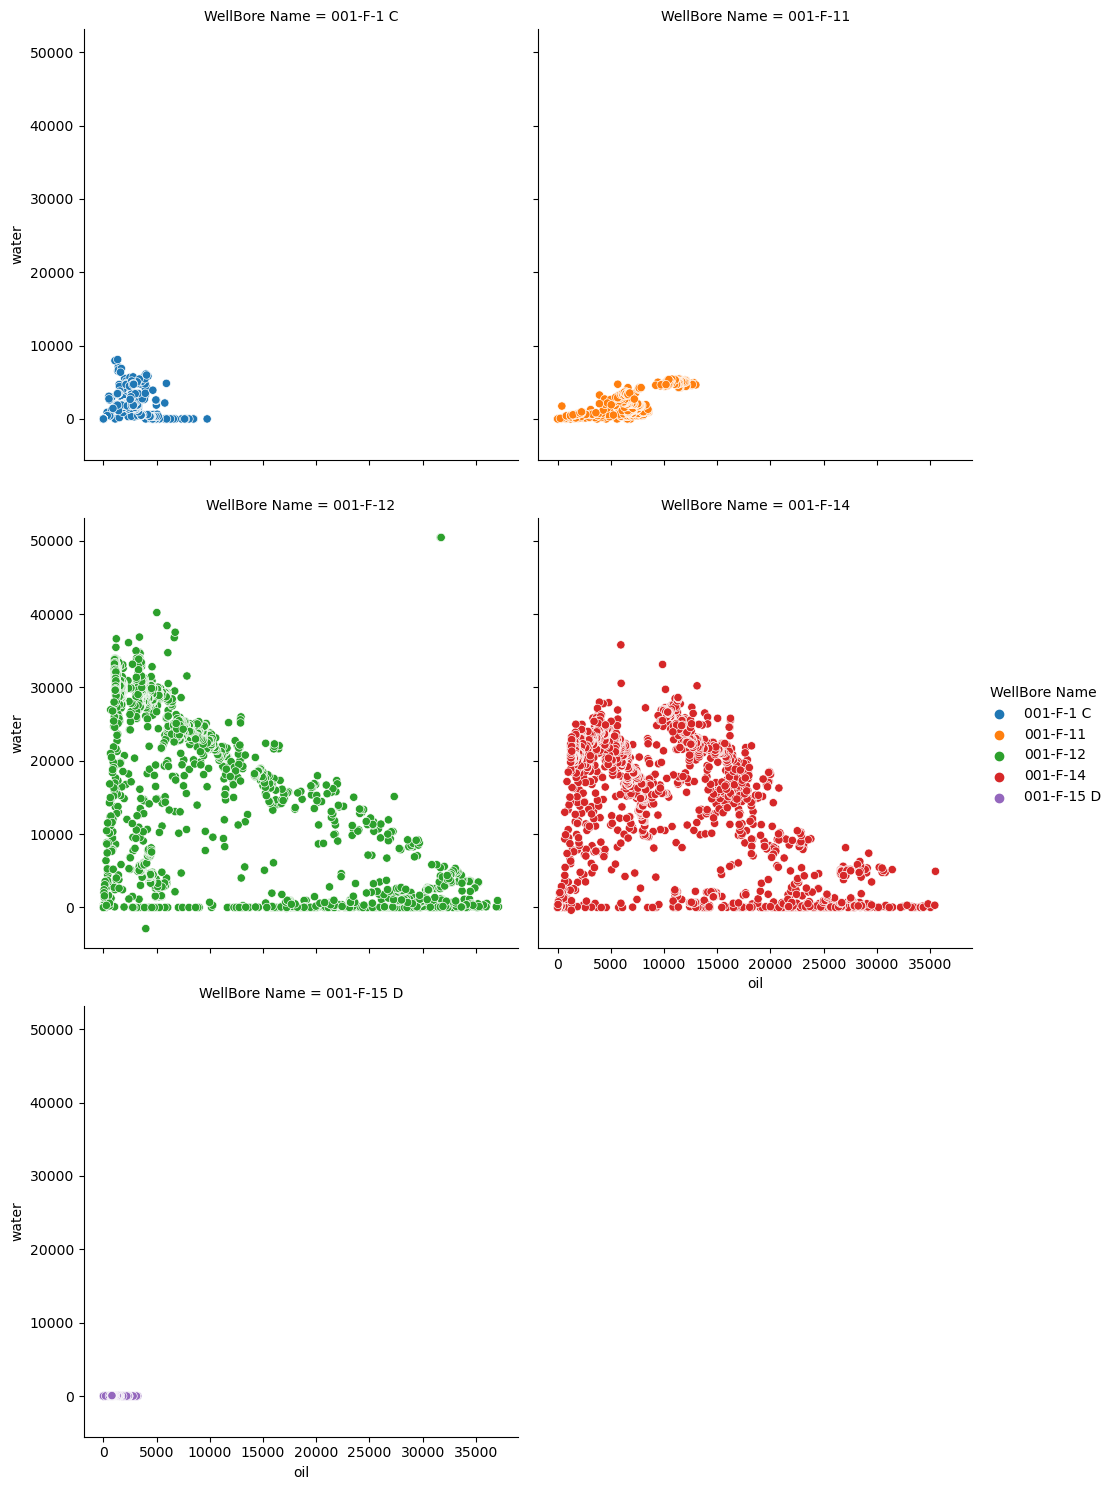

In [63]:
## Plotting Oil vs Water with scatter plots across all wells
# How is the water production across wells changing with time?

sns.relplot(x='oil', y='water', data=train, hue='WellBore Name', kind='scatter', height=5, aspect=1, col='WellBore Name',
           col_wrap=2)

#### Observation
1. There's 0 water production for well F-15-D
2. For other wells except F-11, there's a mostly -ve linear relationship with oil

### Summary Towards Modeling
1. The linearity is on a well level so it won't be possible to use data for other wells in prediction on a specific well. In otherwords, the well name is a key feature.
2. All other features are to be used as they hold meaning and information in some wells.
3. The oil value should be used as a feature in predicting water.
4. I can't use a tree based model. As there is seasonality in data, target variable keeps decreasing overtime.
5. I can try a support vector model or a neural network but I'll need to use year and other time extracts as features.

<a name="fe"></a>
## 3. Feature Engineering 
- In the EDA, the well head pressure and choke size are generally the best related features with oil production but it is observed that well head pressure rise does not always indicate a higher production output. 

- It was observed that pressure change and choke size change (either from lower to higher or higher to lower) was what yielded rise or drop of oil production.[See point 5](#important_point). This led to feature engineering of extracting pressure rise or drop in terms of percentage after lagging by 1 to 5 days.

- Being a time series problem, day features were also extracted.
- Feature interaction of 2 features by multiplication was done in an aim to generate important features

In [64]:
def lag_feat(data, lag_range=[2,5], feat=''):
    '''For a given feature in the dataframe, we extract lags of days and compute percentage increase or decrease'''
    for a in range(lag_range[0], lag_range[1]+1):
        data[feat+'_'+str(a)+'days']=data[feat].shift(a)
    
    # filling na which arised from lag first
    data.fillna(method='bfill', inplace=True)
    
    # getting percentage increase or decrease (0.00001 is added to avoid zero division)
    for a in range(lag_range[0], lag_range[1]+1):
        data[feat+'_'+str(a)+'days_perc']=((data[feat] - data[feat+'_'+str(a)+'days'])/(data[feat]+0.00001))*100
        data[feat+'_'+str(a)+'days_perc_clip']=((data[feat] - data[feat+'_'+str(a)+'days'])
                                                /(data[feat]+data[feat+'_'+str(a)+'days']+0.00001))*100
    

def get_features(data, features=[]):
    '''Gets the date features, multiplied features and lagged features from a dataframe'''
    # date Features
    data['month'] = data['date'].dt.month
    data['dayofyear'] = data['date'].dt.dayofyear
    data['day'] = data['date'].dt.day
    data['weekday'] = data['date'].dt.weekday
    data['weekofyear'] = data['date'].dt.weekofyear
    data['year'] = data['date'].dt.year
    #print(features)
    
    # 2 Features Interaction
    two_features=list(itertools.product(features, repeat=2))
    
    # removing duplicate features for example whp-downhole_p is same as downhole_p-whp
    remove_index = [6, 12, 13, 18, 19, 20, 24, 25, 26, 27, 30, 31, 32, 33, 34]

    for cnt, a in enumerate(remove_index):
        latest_ind=a-cnt
        two_features.remove(two_features[latest_ind])
        
    #print(len(two_features))
    for feat in two_features:
        data[feat[0]+'_'+feat[1]] = data[feat[0]]*data[feat[1]]
    
    #1 -5 days Lag 
    lag_feat(data, lag_range=[1,5], feat='Choke Size')
    lag_feat(data, lag_range=[1,5], feat='whp')
    lag_feat(data, lag_range=[1,5], feat='Annulus_p')
    
    return data
    

In [65]:
extra_feats = get_features(train.copy(), features=float_cols[:6])

In [66]:
## Selecting some created features for manual inspection
extra_feats[['date', 'whp', 'whp_1days', 'whp_1days_perc_clip', 'oil']].head(5)

date     whp  whp_1days  whp_1days_perc_clip   oil
0 2014-04-07   0.000      0.000                0.000 0.000
1 2014-04-08   0.000      0.000                0.000 0.000
2 2014-04-09   0.000      0.000                0.000 0.000
3 2014-04-10   0.000      0.000                0.000 0.000
4 2014-04-11 479.919      0.000              100.000 0.000

In [67]:
# Getting the names of the unique wells to be used subsequently
unique_wells=extra_feats['WellBore Name'].unique()

<a name="data_splitting"></a>
## 4. Data Splitting
Splitting is going to be done on a well level since they all have the same days. The middle 12.5% and end 12.5% (making 25% of the data) is our test

In [68]:
empty_train_df = pd.DataFrame(columns=extra_feats.columns)
empty_test_df = pd.DataFrame(columns=extra_feats.columns)

for well_ in unique_wells:
    df=extra_feats.copy()
    df=df[df['WellBore Name']==well_]
    
    # sorting by date
    df.sort_values('date', inplace=True)
    rows=df.shape[0]
    _perc=0.125*rows
    half=round(rows/2)
    middle_perc_end=int(half-_perc)
    end_perc_start=int(rows-_perc)
    test_1=df.iloc[middle_perc_end:half, :]
    test_2=df.iloc[end_perc_start:,:]
    train_1=df.iloc[:middle_perc_end,:]
    train_2=df.iloc[half:end_perc_start, :]

    # appending to empty dataframe
    empty_train_df=pd.concat([empty_train_df,train_1, train_2], axis=0)
    empty_test_df=pd.concat([empty_test_df,test_1, test_2], axis=0)


In [69]:
# checking for duplicates to ensure split worked correctly
dup_tr = empty_train_df.duplicated()
display(empty_train_df[dup_tr])

dup_te = empty_test_df.duplicated()
empty_test_df[dup_te]

Empty DataFrame
Columns: [date, WellBore Name, Downhole_p, Downhole_t, Average_tp, Annulus_p, whp, Choke Size, oil, gas, water, Gas-oil ratio, month, dayofyear, day, weekday, weekofyear, year, Downhole_p_Downhole_p, Downhole_p_Downhole_t, Downhole_p_Average_tp, Downhole_p_Annulus_p, Downhole_p_whp, Downhole_p_Choke Size, Downhole_t_Downhole_t, Downhole_t_Average_tp, Downhole_t_Annulus_p, Downhole_t_whp, Downhole_t_Choke Size, Average_tp_Average_tp, Average_tp_Annulus_p, Average_tp_whp, Average_tp_Choke Size, Annulus_p_Annulus_p, Annulus_p_whp, Annulus_p_Choke Size, whp_whp, whp_Choke Size, Choke Size_Choke Size, Choke Size_1days, Choke Size_2days, Choke Size_3days, Choke Size_4days, Choke Size_5days, Choke Size_1days_perc, Choke Size_1days_perc_clip, Choke Size_2days_perc, Choke Size_2days_perc_clip, Choke Size_3days_perc, Choke Size_3days_perc_clip, Choke Size_4days_perc, Choke Size_4days_perc_clip, Choke Size_5days_perc, Choke Size_5days_perc_clip, whp_1days, whp_2days, whp_3days, whp_4days, whp_5days, whp_1days_perc, whp_1days_perc_clip, whp_2days_perc, whp_2days_perc_clip, whp_3days_perc, whp_3days_perc_clip, whp_4days_perc, whp_4days_perc_clip, whp_5days_perc, whp_5days_perc_clip, Annulus_p_1days, Annulus_p_2days, Annulus_p_3days, Annulus_p_4days, Annulus_p_5days, Annulus_p_1days_perc, Annulus_p_1days_perc_clip, Annulus_p_2days_perc, Annulus_p_2days_perc_clip, Annulus_p_3days_perc, Annulus_p_3days_perc_clip, Annulus_p_4days_perc, Annulus_p_4days_perc_clip, Annulus_p_5days_perc, Annulus_p_5days_perc_clip]
Index: []

[0 rows x 84 columns]

Empty DataFrame
Columns: [date, WellBore Name, Downhole_p, Downhole_t, Average_tp, Annulus_p, whp, Choke Size, oil, gas, water, Gas-oil ratio, month, dayofyear, day, weekday, weekofyear, year, Downhole_p_Downhole_p, Downhole_p_Downhole_t, Downhole_p_Average_tp, Downhole_p_Annulus_p, Downhole_p_whp, Downhole_p_Choke Size, Downhole_t_Downhole_t, Downhole_t_Average_tp, Downhole_t_Annulus_p, Downhole_t_whp, Downhole_t_Choke Size, Average_tp_Average_tp, Average_tp_Annulus_p, Average_tp_whp, Average_tp_Choke Size, Annulus_p_Annulus_p, Annulus_p_whp, Annulus_p_Choke Size, whp_whp, whp_Choke Size, Choke Size_Choke Size, Choke Size_1days, Choke Size_2days, Choke Size_3days, Choke Size_4days, Choke Size_5days, Choke Size_1days_perc, Choke Size_1days_perc_clip, Choke Size_2days_perc, Choke Size_2days_perc_clip, Choke Size_3days_perc, Choke Size_3days_perc_clip, Choke Size_4days_perc, Choke Size_4days_perc_clip, Choke Size_5days_perc, Choke Size_5days_perc_clip, whp_1days, whp_2days, whp_3days, whp_4days, whp_5days, whp_1days_perc, whp_1days_perc_clip, whp_2days_perc, whp_2days_perc_clip, whp_3days_perc, whp_3days_perc_clip, whp_4days_perc, whp_4days_perc_clip, whp_5days_perc, whp_5days_perc_clip, Annulus_p_1days, Annulus_p_2days, Annulus_p_3days, Annulus_p_4days, Annulus_p_5days, Annulus_p_1days_perc, Annulus_p_1days_perc_clip, Annulus_p_2days_perc, Annulus_p_2days_perc_clip, Annulus_p_3days_perc, Annulus_p_3days_perc_clip, Annulus_p_4days_perc, Annulus_p_4days_perc_clip, Annulus_p_5days_perc, Annulus_p_5days_perc_clip]
Index: []

[0 rows x 84 columns]

## Feature Scaling and Predictions

In [70]:
# only object column should be well bore name, so I convert all other columns to float. This is a second datatype check
all_cols = empty_train_df.columns[2:]

for col in all_cols:
    empty_train_df[col]=empty_train_df[col].astype('float64')
    empty_test_df[col]=empty_test_df[col].astype('float64')
    
empty_train_df_=pd.get_dummies(empty_train_df)
empty_test_df_=pd.get_dummies(empty_test_df)

drop_cols=['date']

# performing feature scaling of the training and testing datasets
scaler, train_scaled, test_scaled = scale_datasets(empty_train_df_.drop(drop_cols, axis=1),
                                                   empty_test_df_.drop(drop_cols, axis=1))

### Establishing a Baseline Prediction using Gilberts Equation.
$ Q = M\frac{whp.D64^o}{GOR^n} $

whp = well head pressure

D64 = size of choke (1/64 inch)

GOR = Gas Oil Ratio (this is used as 760, the average in the training data after removing outliers)

Reference for Constant Values M, n and o (Typically, these values are reservoir specific and thus, M was reduced to 0.5 to yield closer results in prediction): https://www.researchgate.net/publication/308532280_Neural_Network_Models_for_Predicting_Wellhead_Pressure-Flow_Rate_Relationship_for_Niger_Delta_Oil_Wells

In [71]:
# Average GOR
train['Gas-oil ratio'].mean()

760.3688291436138

In [72]:
def gilberts_equation(whp, d64, gor=760, M=0.1, o=1.89, n=0.546):
    return (M*(whp*(d64/64**o))/(gor**n))

In [73]:
df_cp = empty_test_df.copy()
df_cp['Gilberts_pred']=gilberts_equation(df_cp['whp'], df_cp['Choke Size'])

Find the metrics summary below


metrics    values
0    rmse  6183.078
1     mae  5216.408
2      r2    -1.105
3   rrmse   145.079
4     mbe -4384.691



Plotting True values (X axis) vs Predicted values (Y axis)


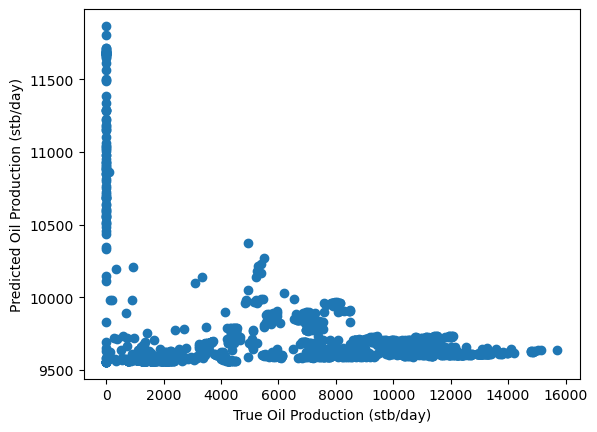

Plotting Well Level Performance


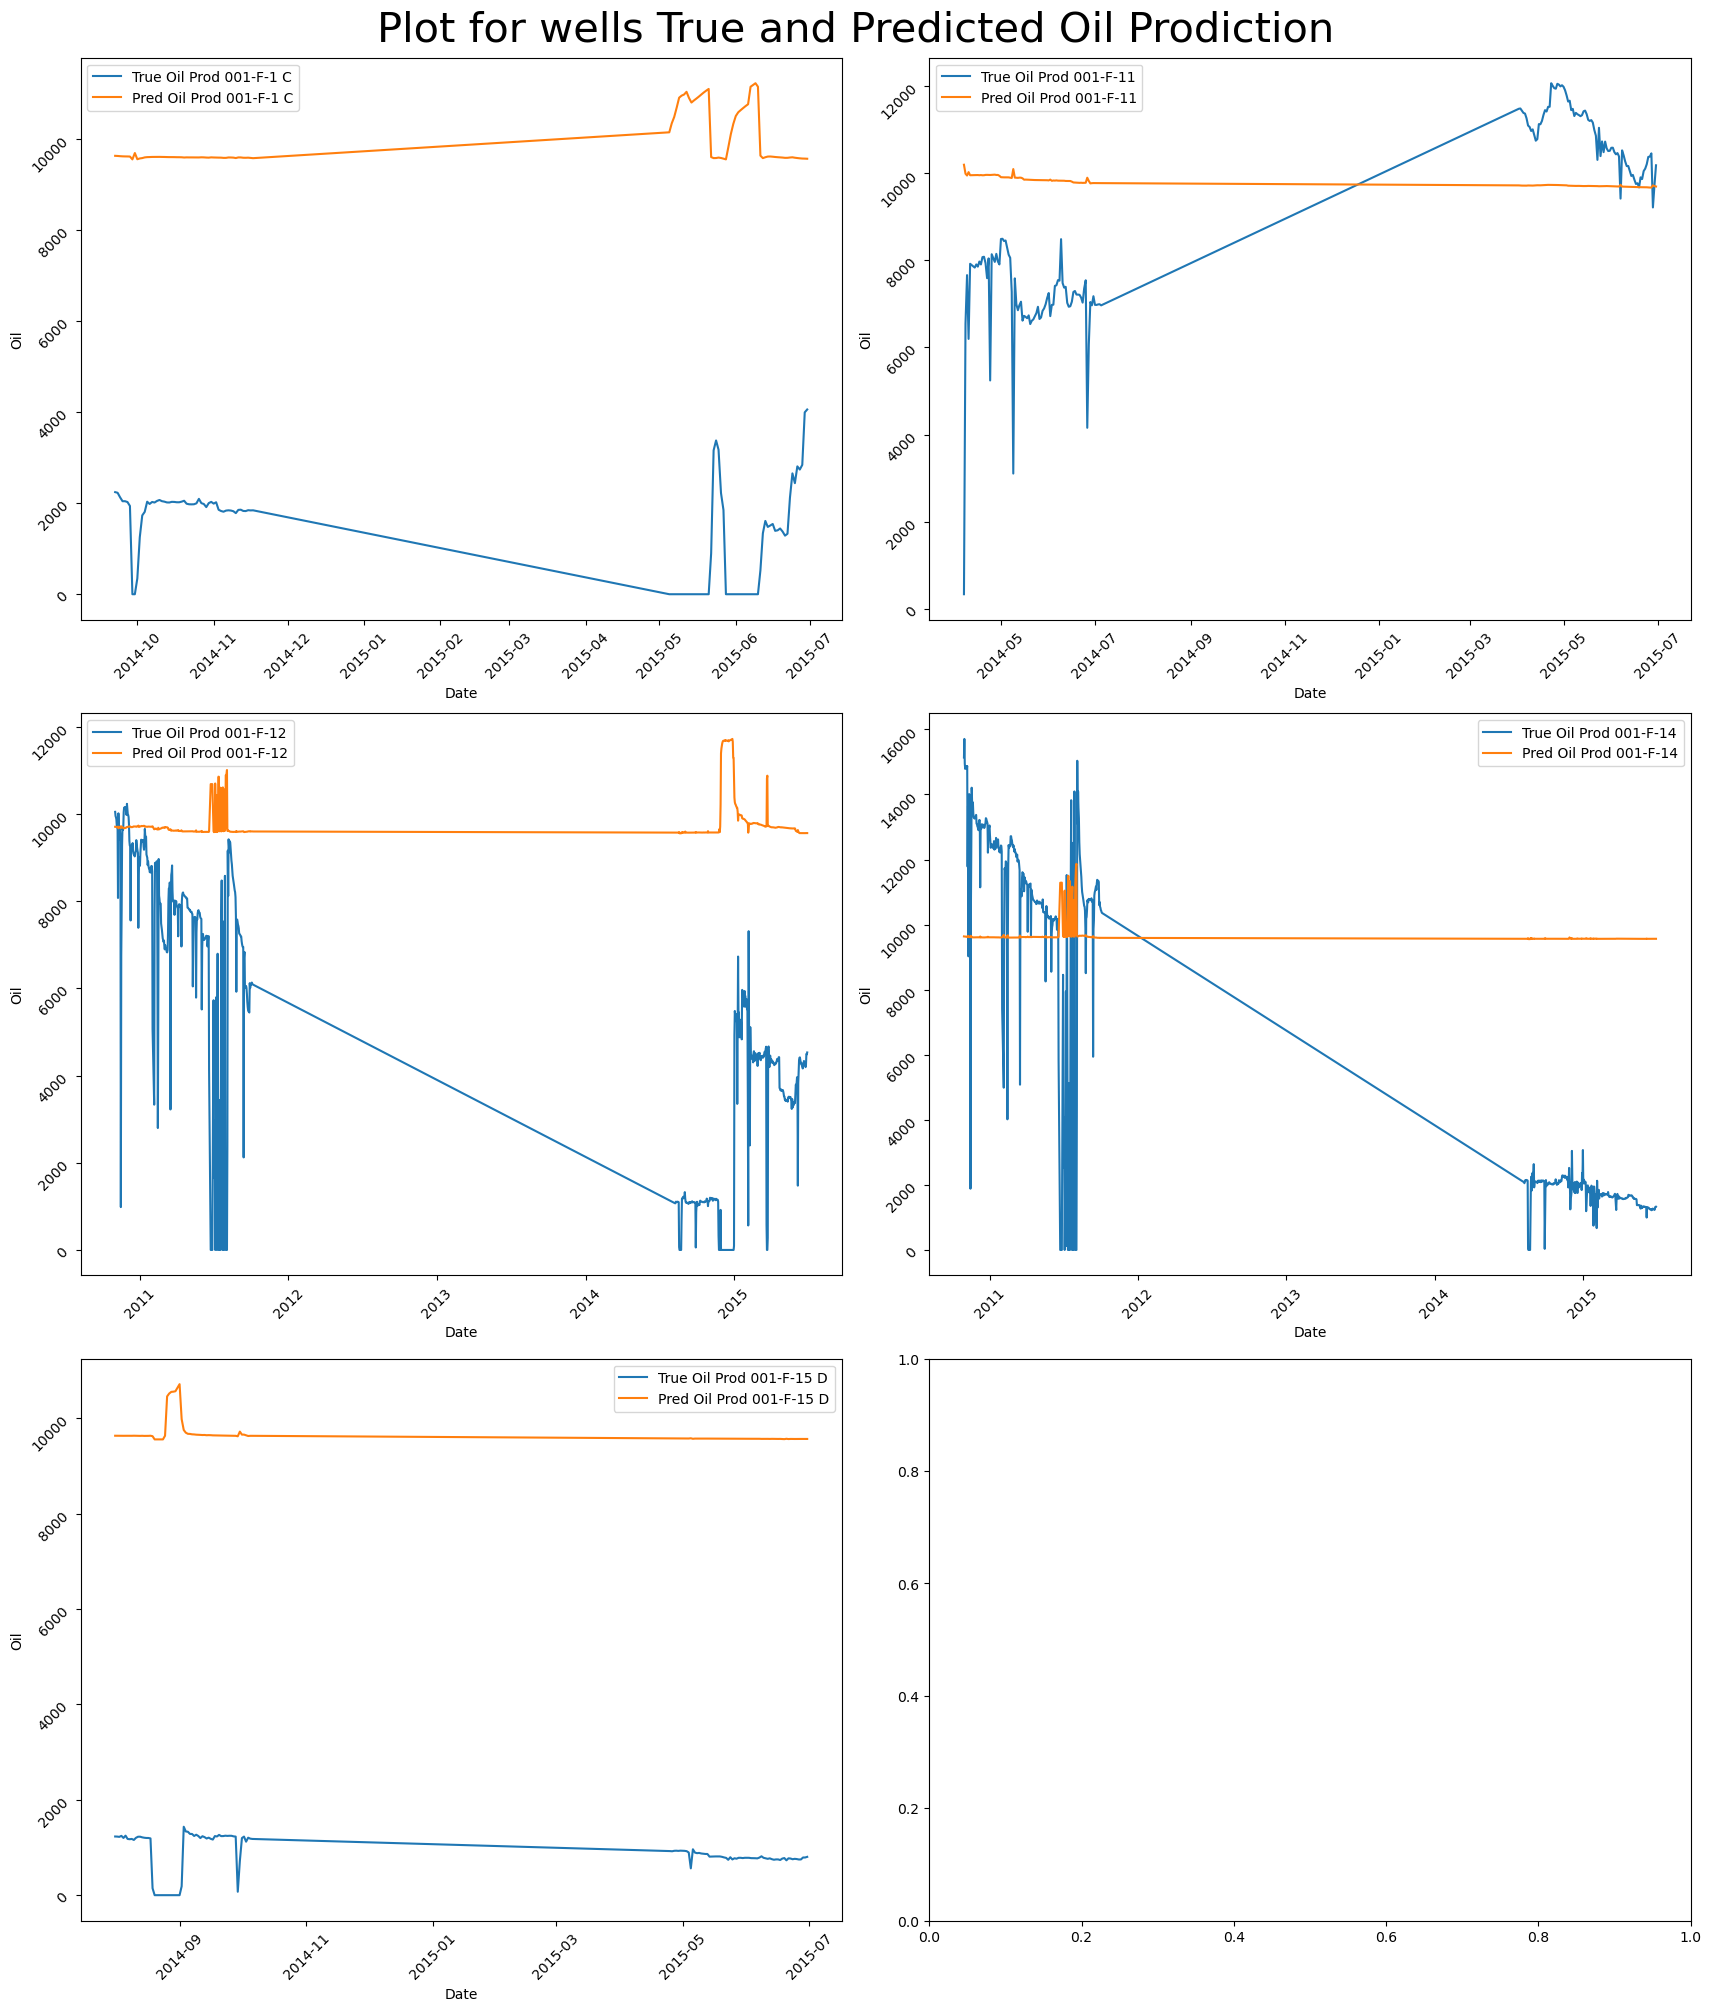

In [74]:
test_scaled_cp = process_prediction(scaler, df_cp, test_scaled, df_cp['Gilberts_pred'].values, value_predicted='oil', 
                                    unique_wells=unique_wells, report=True)

#### Summary
1. We have an rmse of rmse 6183 for oil prediction which is quite high
2. From the comparison plots, gilberts equation is not able to recognize the inverse relationship earlier discussed where oil output is high but whp is decreasing.

### Continuing Prediction with Machine Learning

In [75]:
# Defining a varible for Target (dependent) variable which are to be omited while passing into the model
targets=['oil', 'gas', 'water', 'Gas-oil ratio']

<a name="feature_selection"></a>
## 5. Feature Selection 
1. Using Recursive Feature Elimination Cross Validation (RFECV)

In [76]:
# Experimenting on 5 models
regressors = {
    'LGBM': LGBMRegressor(random_state=1),
    'Linear_regression':LinearRegression(),
    'Ridge': Ridge(),
    'XGB': XGBRegressor(random_state = 66),
    'Adaboost': AdaBoostRegressor(random_state= 40),
}

In [ ]:
%%time
model_best_feats = {}
for mods in regressors:
    model, best_feats = recurse(train_scaled.drop(targets, axis=1),train_scaled['oil'], regressors[mods])
    model_best_feats[model] = best_feats

2. Further Using Permutation importance to select best Features From Features generated by RFECV

In [ ]:
# Combining all the best features from RFECV
all_best_feats = set()

for model_best_feat in model_best_feats:
    for md_feat in model_best_feats[model_best_feat]:
        all_best_feats.add(md_feat)

In [ ]:
model = SVR()
perm_imp_x = train_scaled.drop(targets, axis=1)[all_best_feats]
perm_imp_y = train_scaled['oil']

perm_imp_test_x = test_scaled.drop(targets, axis=1)[all_best_feats]
perm_imp_test_y = test_scaled['oil']

# fit the model
model.fit(perm_imp_x, perm_imp_y)

# perform permutation importance
results = permutation_importance(model, perm_imp_test_x, perm_imp_test_y,
                                 scoring='neg_mean_squared_error', n_repeats=5, n_jobs=-1, random_state=42)

Feature: 0, Score: -0.00000
Feature: 1, Score: 0.00098
Feature: 2, Score: -0.00700
Feature: 3, Score: -0.00042
Feature: 4, Score: -0.00444
Feature: 5, Score: -0.00395
Feature: 6, Score: 0.00563
Feature: 7, Score: -0.00032
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00335
Feature: 11, Score: -0.00952
Feature: 12, Score: 0.00008
Feature: 13, Score: 0.00004
Feature: 14, Score: -0.00442
Feature: 15, Score: 0.00336
Feature: 16, Score: 0.00741
Feature: 17, Score: -0.00000
Feature: 18, Score: 0.00197
Feature: 19, Score: 0.00527
Feature: 20, Score: -0.00087
Feature: 21, Score: 0.37188
Feature: 22, Score: -0.00014
Feature: 23, Score: 0.00044
Feature: 24, Score: 0.00035
Feature: 25, Score: 0.00185
Feature: 26, Score: -0.00000
Feature: 27, Score: 0.01563
Feature: 28, Score: 0.01020
Feature: 29, Score: -0.00000
Feature: 30, Score: -0.00319
Feature: 31, Score: 0.00023
Feature: 32, Score: 0.00084
Feature: 33, Score: -0.00050
Feature: 34, Score: 0.04255
Feature: 35, Sc

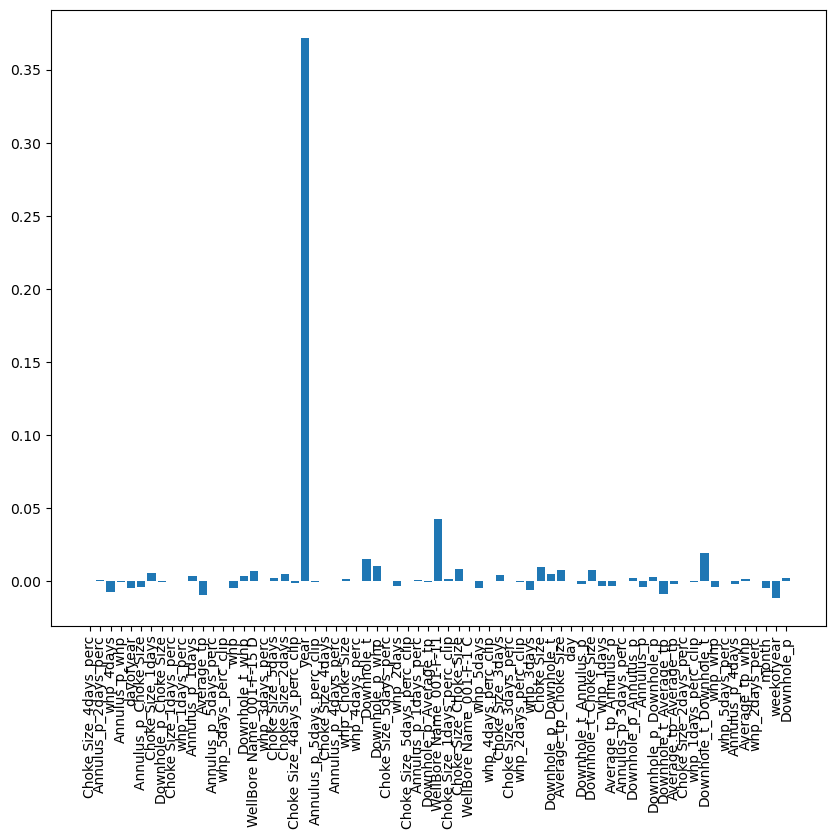

In [59]:
# get importance
importance = results.importances_mean
use_feats_index = []

# summarize feature importance
for i,v in enumerate(importance):
    
    # using only features where value isn't 0
    if round(v,5) != 0:
        use_feats_index.append(i)
    print('Feature: %0d, Score: %.5f' % (i,v))
    
# plot feature importance
plt.figure(figsize =(10,8))
plt.bar([test_scaled.drop(targets, axis=1)[all_best_feats].columns[x] for x in range(len(importance))], importance)
plt.xticks(rotation=90)
plt.show()

In [60]:
cols = test_scaled.drop(targets, axis=1)[all_best_feats].columns
use_feats = cols[use_feats_index]
use_feats=use_feats.to_list()

In [63]:
# adding other well names also
for new_feat in unique_wells:
    if 'WellBore Name_'+new_feat in use_feats:
        print(new_feat)
        pass
    else:
        use_feats.append('WellBore Name_'+new_feat)

len(use_feats)

001-F-1 C
001-F-11
001-F-12
001-F-14
001-F-15 D


60

In [77]:
## The 60 best features are manually placed here as RFECV takes time on each restart of the notebook session
use_feats=['Annulus_p_2days_perc',
 'whp_4days',
 'Annulus_p_whp',
 'dayofyear',
 'Annulus_p_Choke Size',
 'Choke Size_1days',
 'Downhole_p_Choke Size',
 'Annulus_p_1days',
 'Average_tp',
 'Annulus_p_5days_perc',
 'whp_5days_perc_clip',
 'whp',
 'Downhole_t_whp',
 'WellBore Name_001-F-15 D',
 'Choke Size_5days',
 'Choke Size_2days',
 'Choke Size_4days_perc_clip',
 'year',
 'Annulus_p_5days_perc_clip',
 'Choke Size_4days',
 'Annulus_p_4days_perc',
 'whp_Choke Size',
 'Downhole_t',
 'Downhole_p_whp',
 'whp_2days',
 'Choke Size_5days_perc_clip',
 'Annulus_p_1days_perc',
 'Downhole_p_Average_tp',
 'WellBore Name_001-F-11',
 'Choke Size_1days_perc_clip',
 'Choke Size_Choke Size',
 'WellBore Name_001-F-1 C',
 'whp_5days',
 'Choke Size_3days',
 'whp_2days_perc_clip',
 'whp_3days',
 'Choke Size',
 'Downhole_p_Downhole_t',
 'Average_tp_Choke Size',
 'day',
 'Downhole_t_Annulus_p',
 'Downhole_t_Choke Size',
 'whp_1days',
 'Average_tp_Annulus_p',
 'Annulus_p_3days_perc',
 'Downhole_p_Annulus_p',
 'Annulus_p',
 'Downhole_p_Downhole_p',
 'Downhole_t_Average_tp',
 'Average_tp_Average_tp',
 'whp_1days_perc_clip',
 'Downhole_t_Downhole_t',
 'whp_whp',
 'Annulus_p_4days',
 'Average_tp_whp',
 'month',
 'weekofyear',
 'Downhole_p',
 'WellBore Name_001-F-12',
 'WellBore Name_001-F-14']

### Multi output Chain Regression 
In this method of regression, each model in the chain predicts a target label based on all available input features and the predictions of previous models in the sequence. Basically, in predicting water, oil and gas are taken as features.

Reference: https://www.geeksforgeeks.org/multioutput-regression-in-machine-learning/

In [56]:
# Defining the chained multioutput model (The values for the parameters were gotten after tuning which is below)
svm_chain = RegressorChain(SVR(C=0.5999970032438215,
    epsilon = 0.005269443411837325,
    degree= 3,
    gamma= 'scale',
    kernel='rbf'))

final_train_X = train_scaled.drop(targets, axis=1)[use_feats]
final_train_y = train_scaled[['oil', 'gas', 'water']]

final_test_X = test_scaled.drop(targets, axis=1)[use_feats]
final_test_y = test_scaled[['oil', 'gas', 'water']]

svm_chain.fit(final_train_X,final_train_y)


RegressorChain(base_estimator=SVR(C=0.5999970032438215,
                                  epsilon=0.005269443411837325))

In [72]:
predictions = svm_chain.predict(final_test_X)

Find the metrics summary below


metrics   values
0    rmse 2174.798
1     mae 1413.075
2      r2    0.740
3   rrmse   51.029
4     mbe  196.226



Plotting True values (X axis) vs Predicted values (Y axis)


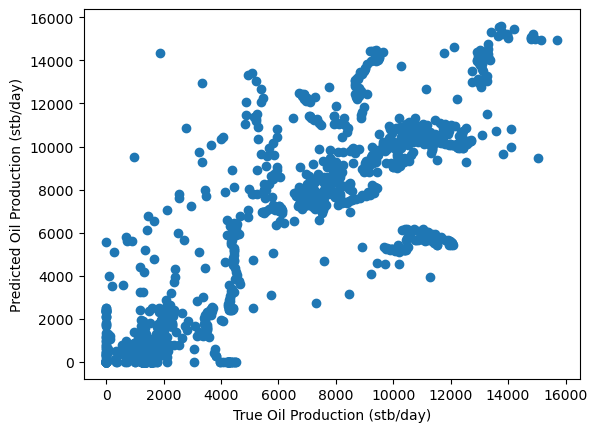

Plotting Well Level Performance


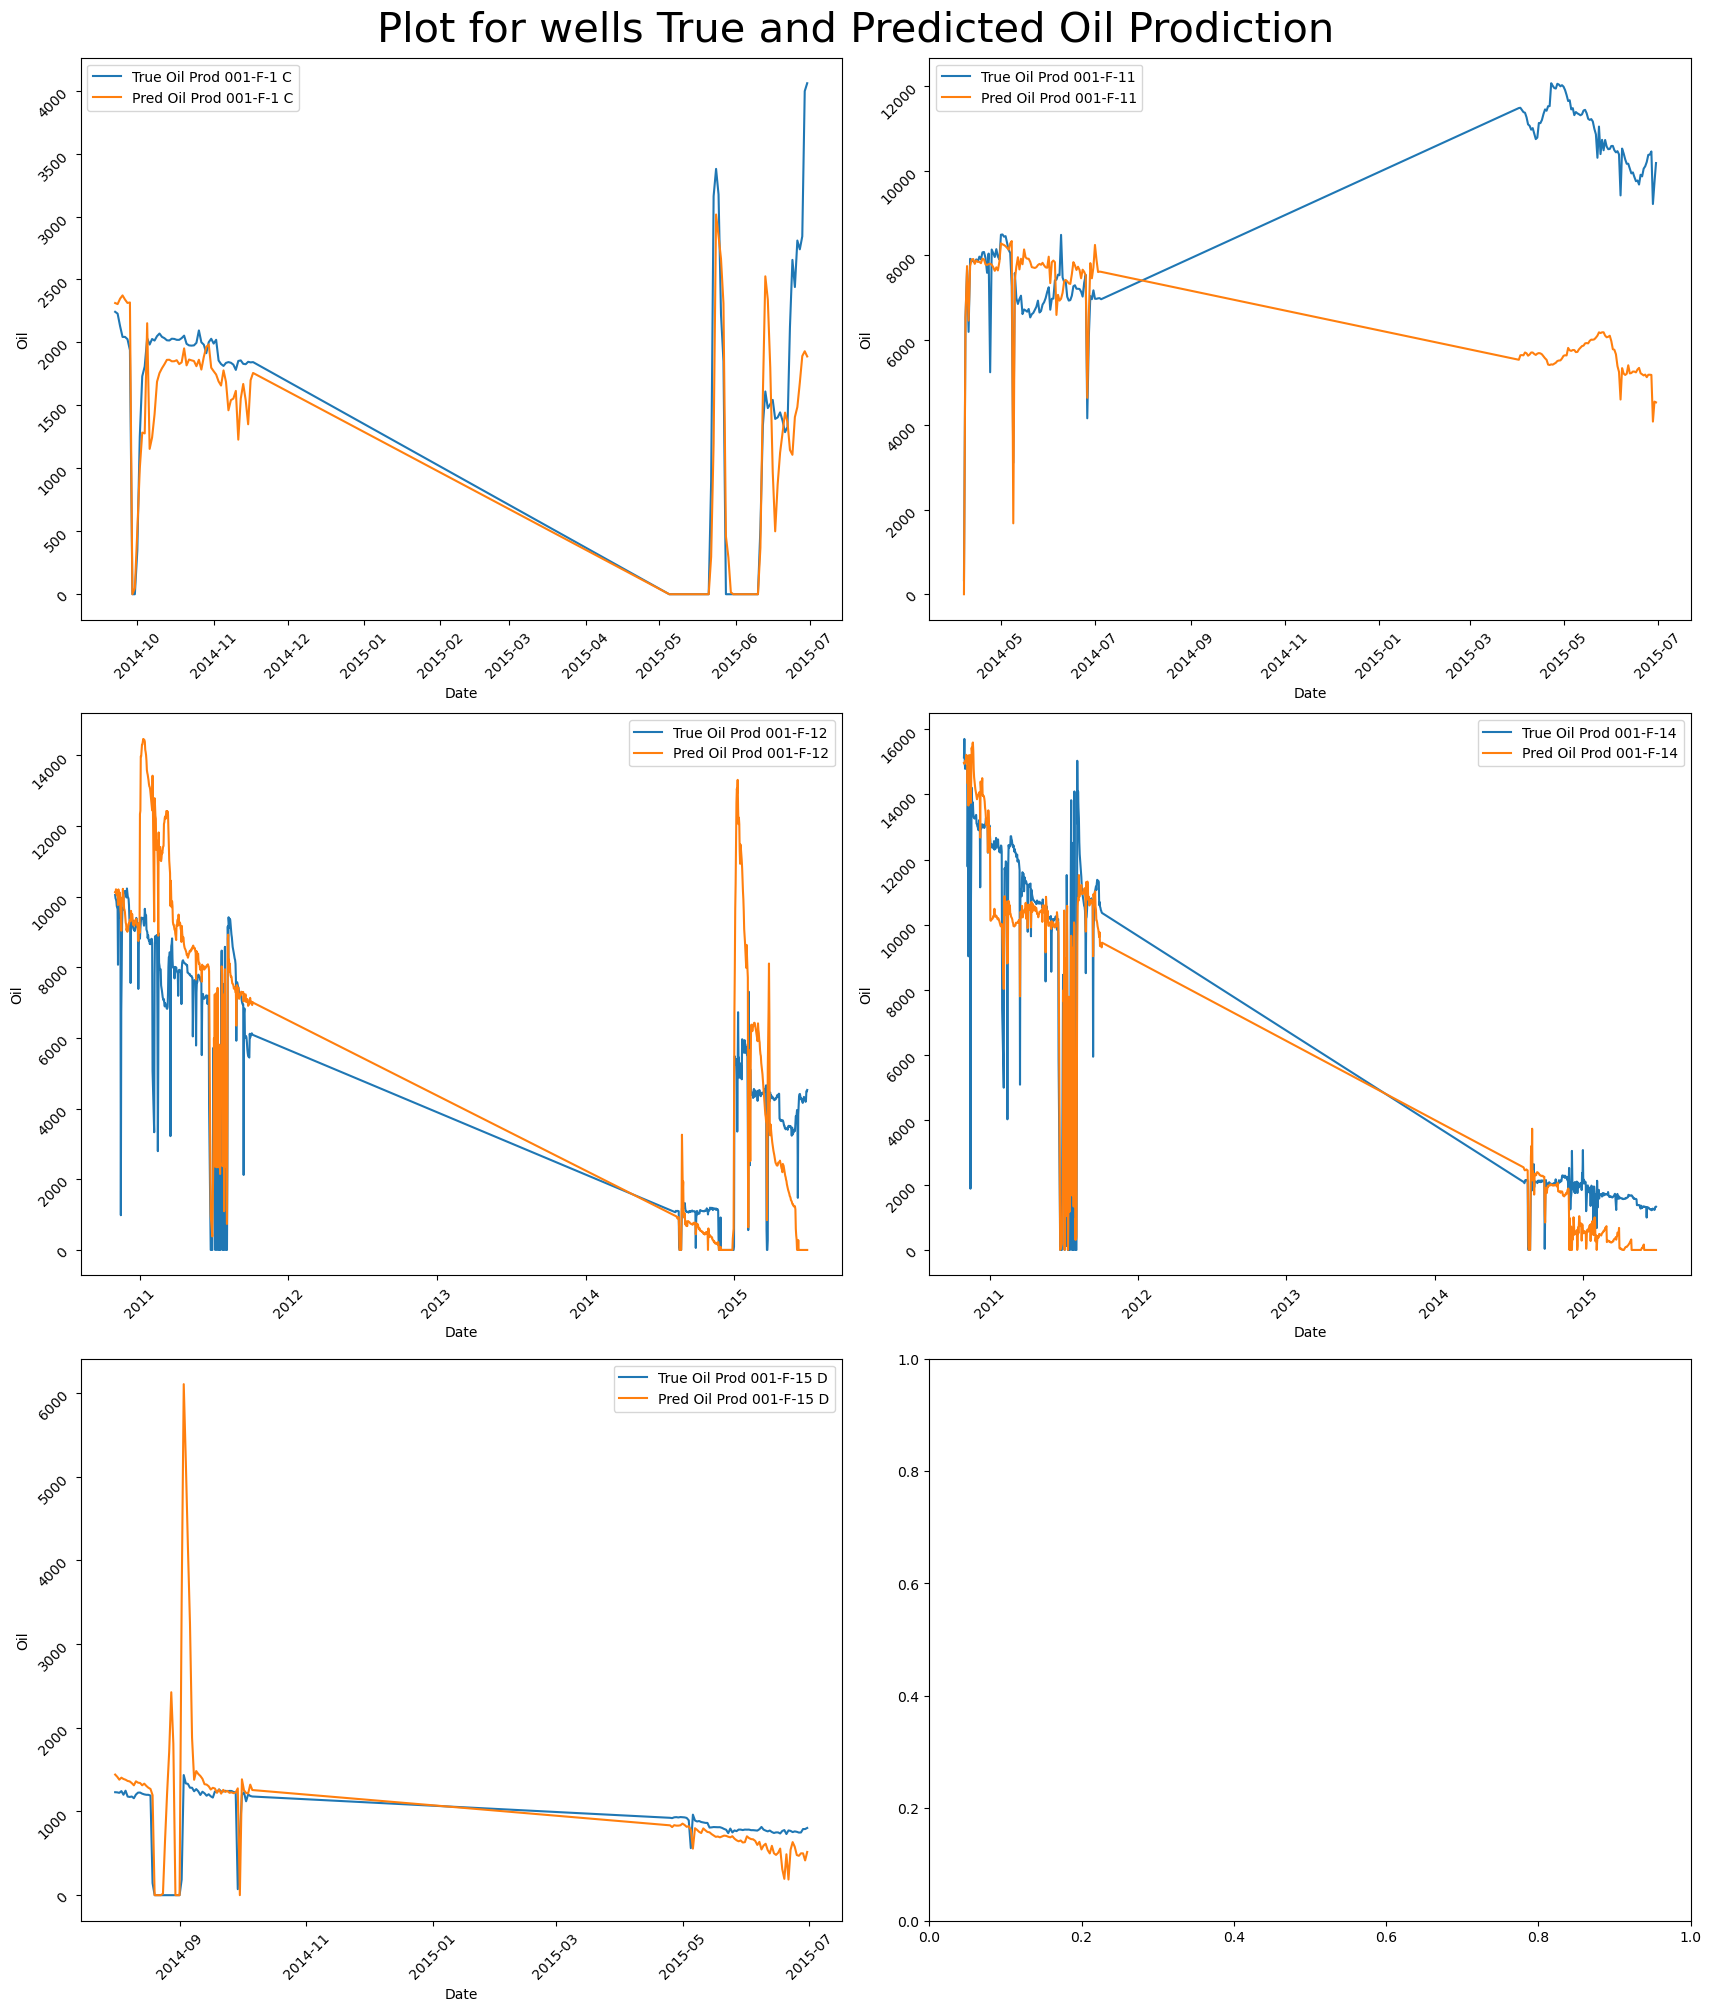

In [73]:
# Visualizing prediction performance by comparing with true values via line plots
test_scaled_cp = process_prediction(scaler, empty_test_df, test_scaled, predictions[:,0], value_predicted='oil', 
                                    unique_wells=unique_wells, report=True)

<a name="hyperparam"></a>
## 6. HyperParameter Tuning

In [63]:
# Number of out-fold models
num_out_folds = 1

# Number of folds
num_folds = 10

# Global random seed
global_seed = 42

# Number of trials
num_trials = 500

average_over_all = True

# Study name
study_name = 'svr_study_final_v3'

# Create a new study or load an existing one if it exists (True: create new study, False: load existing study)
create_new_study = False

In [64]:
# using unscaled dataframe to scale within function
X = empty_train_df_.drop(targets, axis=1)[use_feats]
y = empty_train_df_[['oil', 'gas', 'water']]

In [66]:
def objective(trial):
    
    # Hyperparameters to tune (C, epsilon, degree, gamma, kernel) for SVR model
    params = {
        'C': trial.suggest_float('C', 1e-1, 10.0, log=False),
        'epsilon': trial.suggest_float('epsilon', 1e-3, 5, log=False),
        'degree': trial.suggest_int('degree', 2, 5, log=False),
        'gamma': trial.suggest_categorical('gamma', ['scale', 'auto']),
        'kernel': trial.suggest_categorical('kernel', ['poly', 'rbf', 'sigmoid'])
    }
    # Save the error of each fold in a list
    rmse = []
    
    for out_fold in range(1, num_out_folds + 1):

        cv_errors = []
        
        # shuffle is set as false as we want the split done in an ordered way because it's time series data
        kfd = KFold(n_splits=num_folds, shuffle=False)
        
        for fold, (train_idx, valid_idx) in enumerate(kfd.split(X, y)):
            train_x, valid_x = X.iloc[train_idx], X.iloc[valid_idx]
            train_y, valid_y = y.iloc[train_idx], y.iloc[valid_idx]
            

            # SVR model needs scaled features
            # Scale the features using a Standard Scaler in both train and validation set
            tune_scaler = StandardScaler()
            train_x = tune_scaler.fit_transform(train_x)
            valid_x = tune_scaler.transform(valid_x)
            
            # Create an SVR model with suggested hyperparameters
            model = RegressorChain(SVR(**params))

            # Fit the model
            model.fit(train_x, train_y)
            
            # Predict the target values
            preds = model.predict(valid_x)
            
            
            oil_rmse=mean_squared_error(valid_y.iloc[:,0], preds[:,0], squared=False)
            gas_rmse=mean_squared_error(valid_y.iloc[:,1], preds[:,1], squared=False)
            water_rmse=mean_squared_error(valid_y.iloc[:,2], preds[:,2], squared=False)
            
            
            # defining the metric to track as water/gar rmse + oil prediction rmse (oil rmse is added since it's a very)
            # important target. This is basically the objective
            fold_rmse=(water_rmse/(gas_rmse+0.000001))+oil_rmse
            
            # Calculate the RMSE and append it to the list
            cv_errors.append(fold_rmse)
            
        rmse.append(cv_errors)

    # If average_over_all is True, return the mean of the RMSE of all folds and out-folds in the trial
    if average_over_all:
        # Flatten the list of lists to a list and calculate the mean
        return np.mean([item for sublist in rmse for item in sublist])
    else:
        # Calculate the mean of each list and return the mean of the means
        return np.mean([np.mean(item) for item in rmses])

In [ ]:
# Create a new Optuna study if it doesn't exist or load the existing one
study = optuna.create_study(direction="minimize", study_name=study_name, load_if_exists=(not create_new_study))

# Optimize the study, use 'num_trials' trials and 4hrs timeout
study.optimize(objective, n_trials=num_trials, timeout=14400, 
               n_jobs=-1, show_progress_bar=True, gc_after_trial=True)

# Print some information about the study and overall number of trials in case study is resumed from a previous session
print("Number of finished trials: {}".format(len(study.trials)))

# Print the best trial information
print("Best trial:")
trial = study.best_trial

# Print the best hyperparameters
print("  Value: {}".format(trial.value))

# Print the best hyperparameters
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-07-10 03:29:33,329] A new study created in memory with name: svr_study_final_v3


  0%|          | 0/500 [00:00<?, ?it/s]

[I 2024-07-10 03:32:10,658] Trial 2 finished with value: 15623.999079586796 and parameters: {'C': 6.0106819695333975, 'epsilon': 1.1380625177512744, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}. Best is trial 2 with value: 15623.999079586796.
[I 2024-07-10 03:32:29,800] Trial 3 finished with value: 15405.33942989213 and parameters: {'C': 1.623279824690126, 'epsilon': 4.151006854374826, 'degree': 3, 'gamma': 'scale', 'kernel': 'poly'}. Best is trial 3 with value: 15405.33942989213.
[I 2024-07-10 03:33:08,109] Trial 0 finished with value: 14024.61470938304 and parameters: {'C': 0.8255922870253785, 'epsilon': 3.9976462230373238, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 14024.61470938304.
[I 2024-07-10 03:35:31,836] Trial 4 finished with value: 14306.231640224732 and parameters: {'C': 6.472663781011299, 'epsilon': 2.2468224032634567, 'degree': 4, 'gamma': 'scale', 'kernel': 'rbf'}. Best is trial 0 with value: 14024.61470938304.
[I 2024-07-10 03:37:03

[I 2024-07-10 04:05:30,261] Trial 35 finished with value: 13894.916483911908 and parameters: {'C': 7.510505533014103, 'epsilon': 1.549858151930577, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 28 with value: 13891.34147246021.
[I 2024-07-10 04:06:55,429] Trial 36 finished with value: 13893.399013838402 and parameters: {'C': 7.5938350201931994, 'epsilon': 1.5108245731411798, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 28 with value: 13891.34147246021.
[I 2024-07-10 04:07:15,114] Trial 37 finished with value: 13892.071467394091 and parameters: {'C': 7.730306034905565, 'epsilon': 1.6477325793346607, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 28 with value: 13891.34147246021.
[I 2024-07-10 04:08:15,520] Trial 38 finished with value: 13889.094258567284 and parameters: {'C': 7.835107857835249, 'epsilon': 1.449352022472818, 'degree': 2, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 38 with value: 13889.094258567284.


[I 2024-07-10 04:36:25,956] Trial 68 finished with value: 13881.851530787157 and parameters: {'C': 8.599625165441072, 'epsilon': 0.7439106738250216, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 62 with value: 13845.130038546184.
[I 2024-07-10 04:37:32,229] Trial 69 finished with value: 13858.08626694342 and parameters: {'C': 9.143554088291584, 'epsilon': 0.36241426241768937, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 62 with value: 13845.130038546184.
[I 2024-07-10 04:38:28,878] Trial 70 finished with value: 13854.028890453623 and parameters: {'C': 9.198521232568623, 'epsilon': 0.29991701345666477, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 62 with value: 13845.130038546184.
[I 2024-07-10 04:39:09,121] Trial 71 finished with value: 13844.773456862156 and parameters: {'C': 9.354948812278133, 'epsilon': 0.2880844526559345, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 71 with value: 13844.773456862

[I 2024-07-10 05:06:56,017] Trial 101 finished with value: 15481.868720548086 and parameters: {'C': 9.699214009654929, 'epsilon': 0.5234299413359784, 'degree': 4, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 71 with value: 13844.773456862156.
[I 2024-07-10 05:08:02,745] Trial 102 finished with value: 15342.47590411051 and parameters: {'C': 8.787553763064864, 'epsilon': 0.49800194199225534, 'degree': 4, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 71 with value: 13844.773456862156.
[I 2024-07-10 05:08:31,993] Trial 103 finished with value: 15340.33558573644 and parameters: {'C': 8.777884112407305, 'epsilon': 0.4925674419603, 'degree': 4, 'gamma': 'auto', 'kernel': 'sigmoid'}. Best is trial 71 with value: 13844.773456862156.
[I 2024-07-10 05:09:46,058] Trial 104 finished with value: 13847.620527037903 and parameters: {'C': 9.298752209659172, 'epsilon': 0.4504445521761617, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 71 with value: 13844.773456862156.

[I 2024-07-10 05:38:14,023] Trial 134 finished with value: 13847.673468219136 and parameters: {'C': 9.293494183676206, 'epsilon': 0.21138947395956625, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 05:39:10,507] Trial 135 finished with value: 13852.179525774845 and parameters: {'C': 9.614579992240571, 'epsilon': 0.21944744893889634, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 05:39:46,281] Trial 136 finished with value: 13846.44859003869 and parameters: {'C': 9.402029482651386, 'epsilon': 1.0785208760853875, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 05:40:59,579] Trial 137 finished with value: 13855.306895675065 and parameters: {'C': 9.695809178370697, 'epsilon': 0.41713160702860985, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.610

[I 2024-07-10 06:08:27,527] Trial 167 finished with value: 13856.472470720822 and parameters: {'C': 9.830737079803113, 'epsilon': 0.6221084429014972, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 06:09:01,761] Trial 168 finished with value: 13854.356124480508 and parameters: {'C': 9.670827927658728, 'epsilon': 0.7315159908166322, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 06:10:15,137] Trial 169 finished with value: 13855.304910021456 and parameters: {'C': 9.699583989488634, 'epsilon': 0.7327022191564054, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 06:11:11,404] Trial 170 finished with value: 13855.655389431447 and parameters: {'C': 9.178362349953984, 'epsilon': 0.7428232445075704, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003

[I 2024-07-10 06:39:18,528] Trial 200 finished with value: 13855.990808415638 and parameters: {'C': 9.173013317291318, 'epsilon': 0.49707939033167153, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 06:39:20,701] Trial 201 finished with value: 13861.012731139164 and parameters: {'C': 9.102286423712222, 'epsilon': 0.20614553191008922, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 06:40:49,583] Trial 202 finished with value: 13861.958803802941 and parameters: {'C': 9.083338126429386, 'epsilon': 0.17139624682414697, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 06:42:02,870] Trial 203 finished with value: 13886.910288775582 and parameters: {'C': 8.062226364696627, 'epsilon': 0.19373794602161618, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.6

[I 2024-07-10 07:09:41,086] Trial 233 finished with value: 13861.479236880867 and parameters: {'C': 9.095334084497782, 'epsilon': 0.4804239173853464, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 07:10:16,754] Trial 234 finished with value: 13856.246245655633 and parameters: {'C': 9.169741063628328, 'epsilon': 0.3664107696715194, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 07:11:13,120] Trial 235 finished with value: 13850.265537218924 and parameters: {'C': 9.244012201419457, 'epsilon': 0.3499504374779827, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.61003643556.
[I 2024-07-10 07:12:26,238] Trial 236 finished with value: 13848.667442332244 and parameters: {'C': 9.273382642433342, 'epsilon': 2.819338847360394, 'degree': 4, 'gamma': 'scale', 'kernel': 'sigmoid'}. Best is trial 126 with value: 13844.610036

<a name="Tuning"></a>
## Artificial Neural Network (ANN)
A Vanilla (It's called Vanilla because it's built from scratch) ANN is built and performance is tested in making predictions

In [59]:
# Testing a random architecture in predicting oil
hidden_units1 = 384
hidden_units2 = 512
hidden_units3 = 32
hidden_units4 = 448
hidden_units5 = 448
learning_rate = 0.005

# Creating model architecture using the Sequential in tensorflow
def build_model_using_sequential():
    model = Sequential([
    tf.keras.Input(shape=(60,)),
    Dense(hidden_units1, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units2, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units3, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units4, kernel_initializer='normal', activation='relu'),
    Dense(hidden_units5, kernel_initializer='normal', activation='relu'),

    Dense(3, kernel_initializer='normal', activation='linear')
  ])
    return model

In [60]:
# Enables the model to stop training if there's no significant improvement in loss of the validation set
early_stopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 25)

In [61]:
mse = MeanSquaredError()
model = build_model_using_sequential()
model.compile(
    loss=mse, 
    optimizer=Adam(learning_rate=learning_rate), 
    metrics=[mse]
)
# train the model
history = model.fit(
    train_scaled.drop(targets, axis=1)[use_feats],
    train_scaled[['oil', 'gas', 'water']],
    epochs=50, 
    batch_size=32,
    validation_split=0.2, callbacks = [early_stopping]
)

Epoch 1/50
130/130 [==============================] - 4s 16ms/step - loss: 0.2822 - mean_squared_error: 0.2819 - val_loss: 0.1941 - val_mean_squared_error: 0.1943
Epoch 2/50
130/130 [==============================] - 2s 17ms/step - loss: 0.1431 - mean_squared_error: 0.1428 - val_loss: 0.1327 - val_mean_squared_error: 0.1309
Epoch 3/50
130/130 [==============================] - 2s 14ms/step - loss: 0.1192 - mean_squared_error: 0.1190 - val_loss: 0.2980 - val_mean_squared_error: 0.2948
Epoch 4/50
130/130 [==============================] - 2s 14ms/step - loss: 0.1282 - mean_squared_error: 0.1282 - val_loss: 0.2530 - val_mean_squared_error: 0.2504
Epoch 5/50
130/130 [==============================] - 2s 15ms/step - loss: 0.0974 - mean_squared_error: 0.0977 - val_loss: 0.4601 - val_mean_squared_error: 0.4525
Epoch 6/50
130/130 [==============================] - 2s 16ms/step - loss: 0.1001 - mean_squared_error: 0.1000 - val_loss: 0.1710 - val_mean_squared_error: 0.1681
Epoch 7/50
130/130 [==

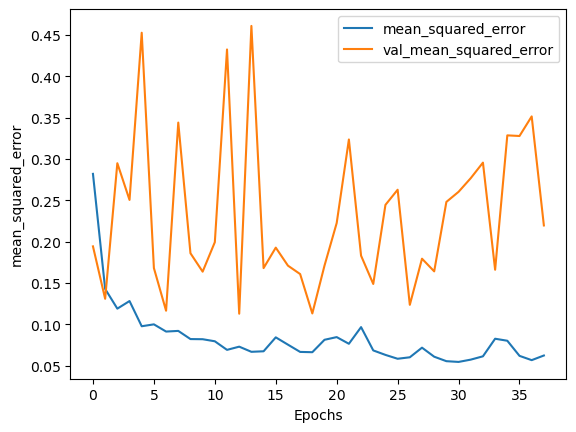

In [62]:
def plot_history(history, key):
    plt.plot(history.history[key])
    plt.plot(history.history['val_'+key])
    plt.xlabel("Epochs")
    plt.ylabel(key)
    plt.legend([key, 'val_'+key])
    plt.show()
    
# Plotting the history
plot_history(history, 'mean_squared_error')

In [63]:
annpr = model.predict(test_scaled.drop(targets, axis=1)[use_feats])

55/55 [==============================] - 1s 7ms/step


Find the metrics summary below


metrics   values
0    rmse 2890.698
1     mae 1890.738
2      r2    0.540
3   rrmse   67.827
4     mbe -840.787



Plotting True values (X axis) vs Predicted values (Y axis)


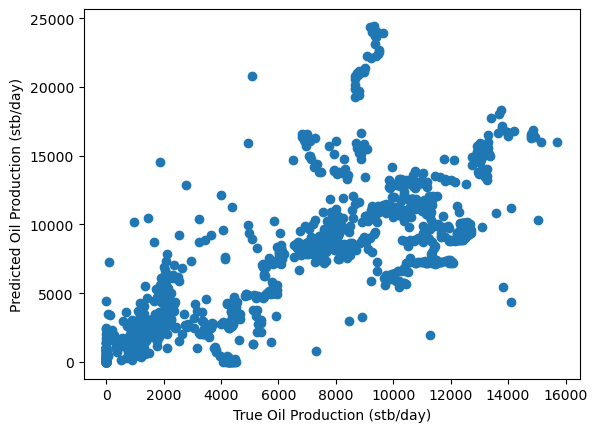

Plotting Well Level Performance


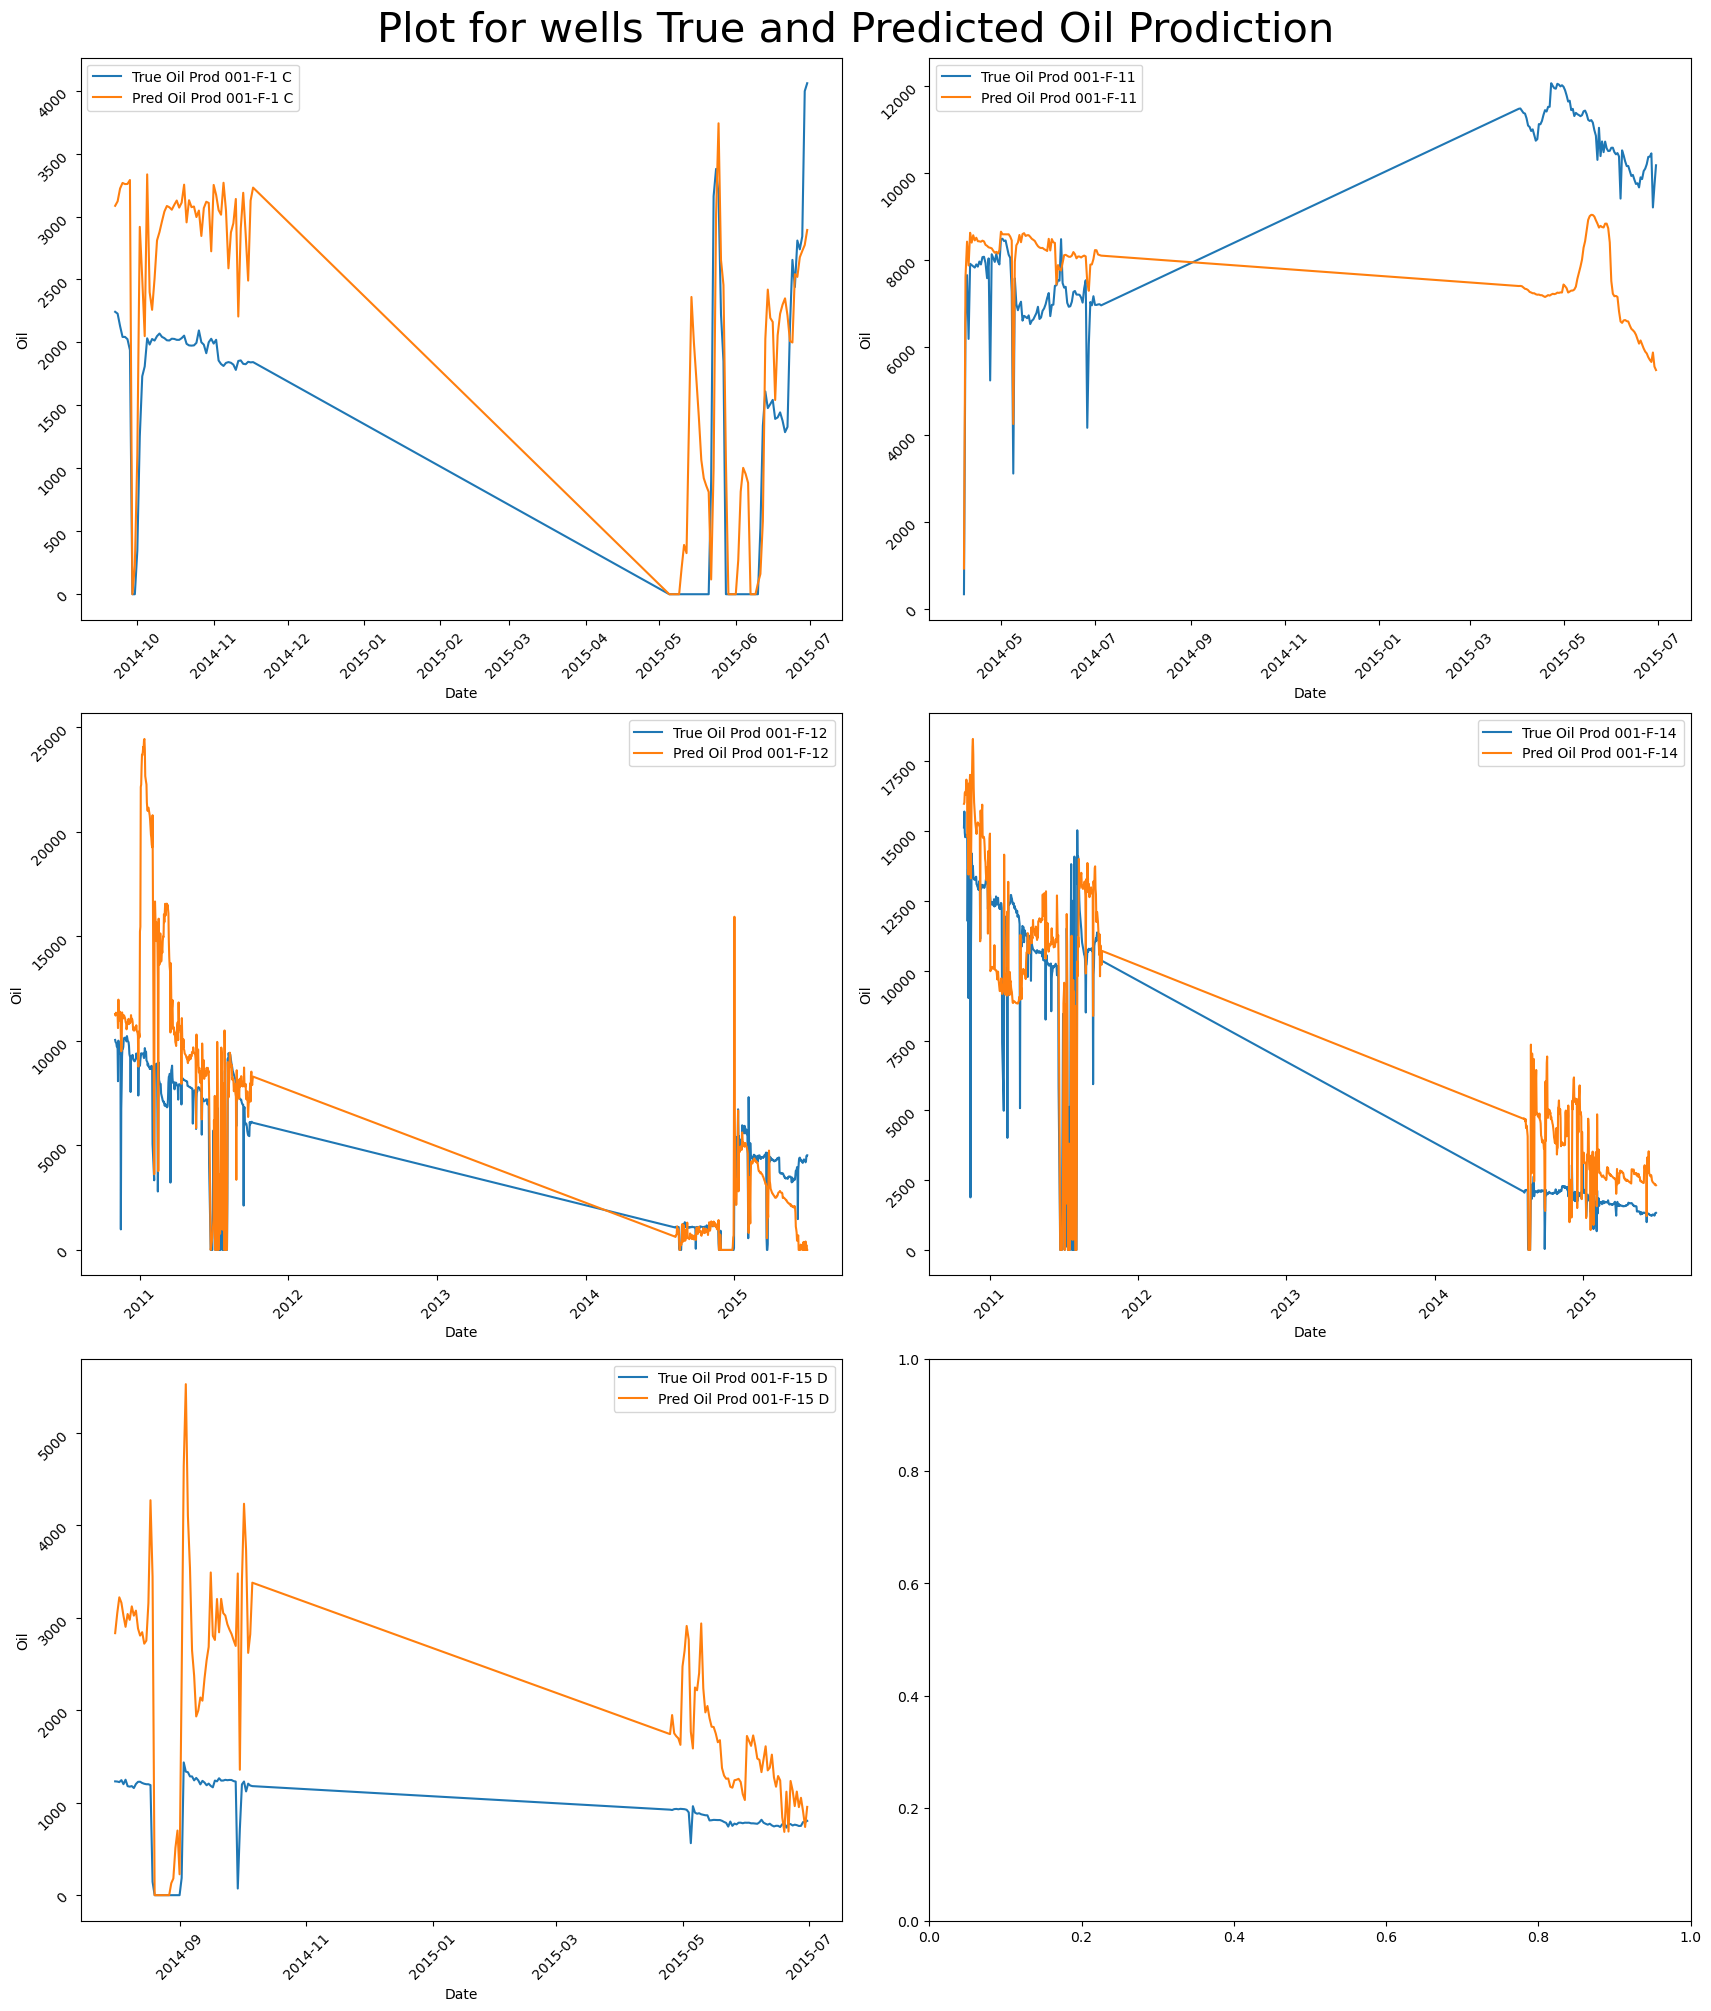

In [64]:
# Getting the performance of the ANN with Visuals
test_scaled_ann = process_prediction(scaler, empty_test_df, test_scaled, annpr[:,0], value_predicted='oil', 
                                    unique_wells=unique_wells, report=True)

## Tuning the Neural Network using Keras Tuner

In [68]:
def model_builder(hp):
    model = keras.Sequential()
    tf.keras.Input(shape=(60,))

  
    for i in range(hp.Int('layer', 2, 15)):
        model.add(Dense(hp.Int('units_'+ str(i), min_value=32, max_value=512, step=32), kernel_initializer='normal',
                    activation='relu'))  

    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.003, 0.005, 0.01, 0.03])
  
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=['mse'])

    return model

In [69]:
# max trials says how many combination of hyperparameters should I try, then executions say for each combination, how
# many times should I train on that ? Because for NNs we get different results for the same model

tuner = kt.RandomSearch(model_builder,
                     objective=kt.Objective("val_mse", direction="min"),
                     max_trials=80,
                     executions_per_trial=3,
                     directory='my_dir4',
                     project_name='intro_to_kt')

In [70]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [71]:
tuner.search(train_scaled.drop(targets, axis=1)[use_feats],train_scaled[['oil']], epochs=50, validation_split=0.2,
             callbacks=[stop_early], batch_size =32)

# Getting the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 80 Complete [00h 03m 41s]
val_mse: 0.0702194112042586

Best val_mse So Far: 0.023186152180035908
Total elapsed time: 05h 14m 06s


In [72]:
tuner.results_summary()

Results summary
Results in my_dir4\intro_to_kt
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 49 summary
Hyperparameters:
layer: 3
units_0: 288
units_1: 224
learning_rate: 0.01
units_2: 64
units_3: 512
units_4: 64
units_5: 288
units_6: 64
units_7: 32
units_8: 320
units_9: 224
units_10: 480
units_11: 128
units_12: 128
units_13: 320
units_14: 480
Score: 0.023186152180035908

Trial 15 summary
Hyperparameters:
layer: 8
units_0: 256
units_1: 448
learning_rate: 0.003
units_2: 256
units_3: 288
units_4: 32
units_5: 224
units_6: 384
units_7: 32
units_8: 128
units_9: 320
units_10: 512
units_11: 192
units_12: 128
units_13: 192
Score: 0.024427032719055813

Trial 18 summary
Hyperparameters:
layer: 5
units_0: 384
units_1: 512
learning_rate: 0.005
units_2: 32
units_3: 448
units_4: 448
units_5: 320
units_6: 256
units_7: 224
units_8: 224
units_9: 256
units_10: 128
units_11: 224
units_12: 64
units_13: 160
Score: 0.025254566843310993

Trial 52 summary
Hyperparameters:
layer: 2
u

In [116]:
best_hps = tuner.get_best_hyperparameters(num_trials=15)[2]

In [118]:
# Building the model with the optimal hyperparameters and train it on the data for 50 epochs to get the best epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_scaled.drop(targets, axis=1)[use_feats],train_scaled[['oil']],
                    epochs=100, validation_split=0.2, batch_size =32)

val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
130/130 [==============================] - 5s 16ms/step - loss: 0.2660 - mse: 0.2660 - val_loss: 0.0834 - val_mse: 0.0834
Epoch 2/100
130/130 [==============================] - 2s 18ms/step - loss: 0.1423 - mse: 0.1423 - val_loss: 0.0576 - val_mse: 0.0576
Epoch 3/100
130/130 [==============================] - 2s 15ms/step - loss: 0.1224 - mse: 0.1224 - val_loss: 0.0527 - val_mse: 0.0527
Epoch 4/100
130/130 [==============================] - 2s 15ms/step - loss: 0.1175 - mse: 0.1175 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 5/100
130/130 [==============================] - 2s 15ms/step - loss: 0.1013 - mse: 0.1013 - val_loss: 0.0608 - val_mse: 0.0608
Epoch 6/100
130/130 [==============================] - 2s 14ms/step - loss: 0.1047 - mse: 0.1047 - val_loss: 0.0652 - val_mse: 0.0652
Epoch 7/100
130/130 [==============================] - 2s 15ms/step - loss: 0.0890 - mse: 0.0890 - val_loss: 0.0587 - val_mse: 0.0587
Epoch 8/100
130/130 [==============================] - 3s 23ms

Epoch 62/100
130/130 [==============================] - 1s 12ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0744 - val_mse: 0.0744
Epoch 63/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0316 - mse: 0.0316 - val_loss: 0.0469 - val_mse: 0.0469
Epoch 64/100
130/130 [==============================] - 1s 11ms/step - loss: 0.0333 - mse: 0.0333 - val_loss: 0.0513 - val_mse: 0.0513
Epoch 65/100
130/130 [==============================] - 2s 12ms/step - loss: 0.0309 - mse: 0.0309 - val_loss: 0.0623 - val_mse: 0.0623
Epoch 66/100
130/130 [==============================] - 2s 13ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0582 - val_mse: 0.0582
Epoch 67/100
130/130 [==============================] - 2s 13ms/step - loss: 0.0388 - mse: 0.0388 - val_loss: 0.0439 - val_mse: 0.0439
Epoch 68/100
130/130 [==============================] - 2s 15ms/step - loss: 0.0330 - mse: 0.0330 - val_loss: 0.0553 - val_mse: 0.0553
Epoch 69/100
130/130 [==============================] -

In [119]:
# setting seeds to ensure reproduceability
tf.keras.utils.set_random_seed
tf.random.set_seed(60)

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(60)
   tf.random.set_seed(60)
   np.random.seed(60)
   random.seed(60)

def run(x,y):
    reset_random_seeds()
    hypermodel = tuner.hypermodel.build(best_hps)
    hypermodel.fit(x,y,
               epochs=best_epoch, validation_split=0.2, batch_size = 32)
    return hypermodel
    
hypermodel = run(train_scaled.drop(targets, axis=1)[use_feats],train_scaled[['oil']])

Epoch 1/42
130/130 [==============================] - 5s 15ms/step - loss: 0.3129 - mse: 0.3129 - val_loss: 0.1133 - val_mse: 0.1133
Epoch 2/42
130/130 [==============================] - 2s 14ms/step - loss: 0.1541 - mse: 0.1541 - val_loss: 0.1660 - val_mse: 0.1660
Epoch 3/42
130/130 [==============================] - 2s 14ms/step - loss: 0.1336 - mse: 0.1336 - val_loss: 0.0980 - val_mse: 0.0980
Epoch 4/42
130/130 [==============================] - 2s 15ms/step - loss: 0.1121 - mse: 0.1121 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 5/42
130/130 [==============================] - 2s 14ms/step - loss: 0.1000 - mse: 0.1000 - val_loss: 0.0833 - val_mse: 0.0833
Epoch 6/42
130/130 [==============================] - 2s 14ms/step - loss: 0.0879 - mse: 0.0879 - val_loss: 0.0735 - val_mse: 0.0735
Epoch 7/42
130/130 [==============================] - 2s 12ms/step - loss: 0.0888 - mse: 0.0888 - val_loss: 0.0699 - val_mse: 0.0699
Epoch 8/42
130/130 [==============================] - 2s 12ms/step - 

In [120]:
annpr_tuned = hypermodel.predict(test_scaled.drop(targets, axis=1)[use_feats])

55/55 [==============================] - 0s 5ms/step


Find the metrics summary below


metrics   values
0    rmse 1757.286
1     mae 1173.249
2      r2    0.830
3   rrmse   41.233
4     mbe   51.517



Plotting True values (X axis) vs Predicted values (Y axis)


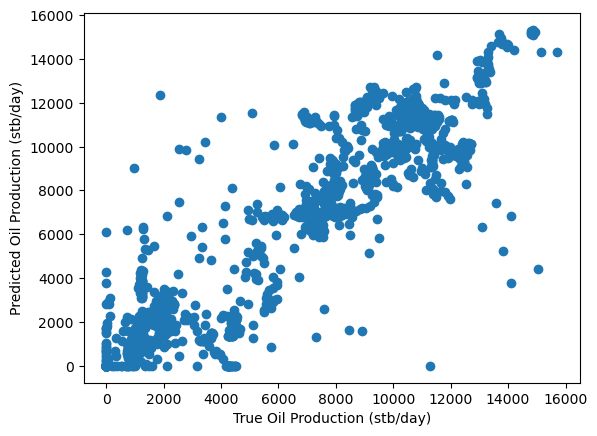

Plotting Well Level Performance


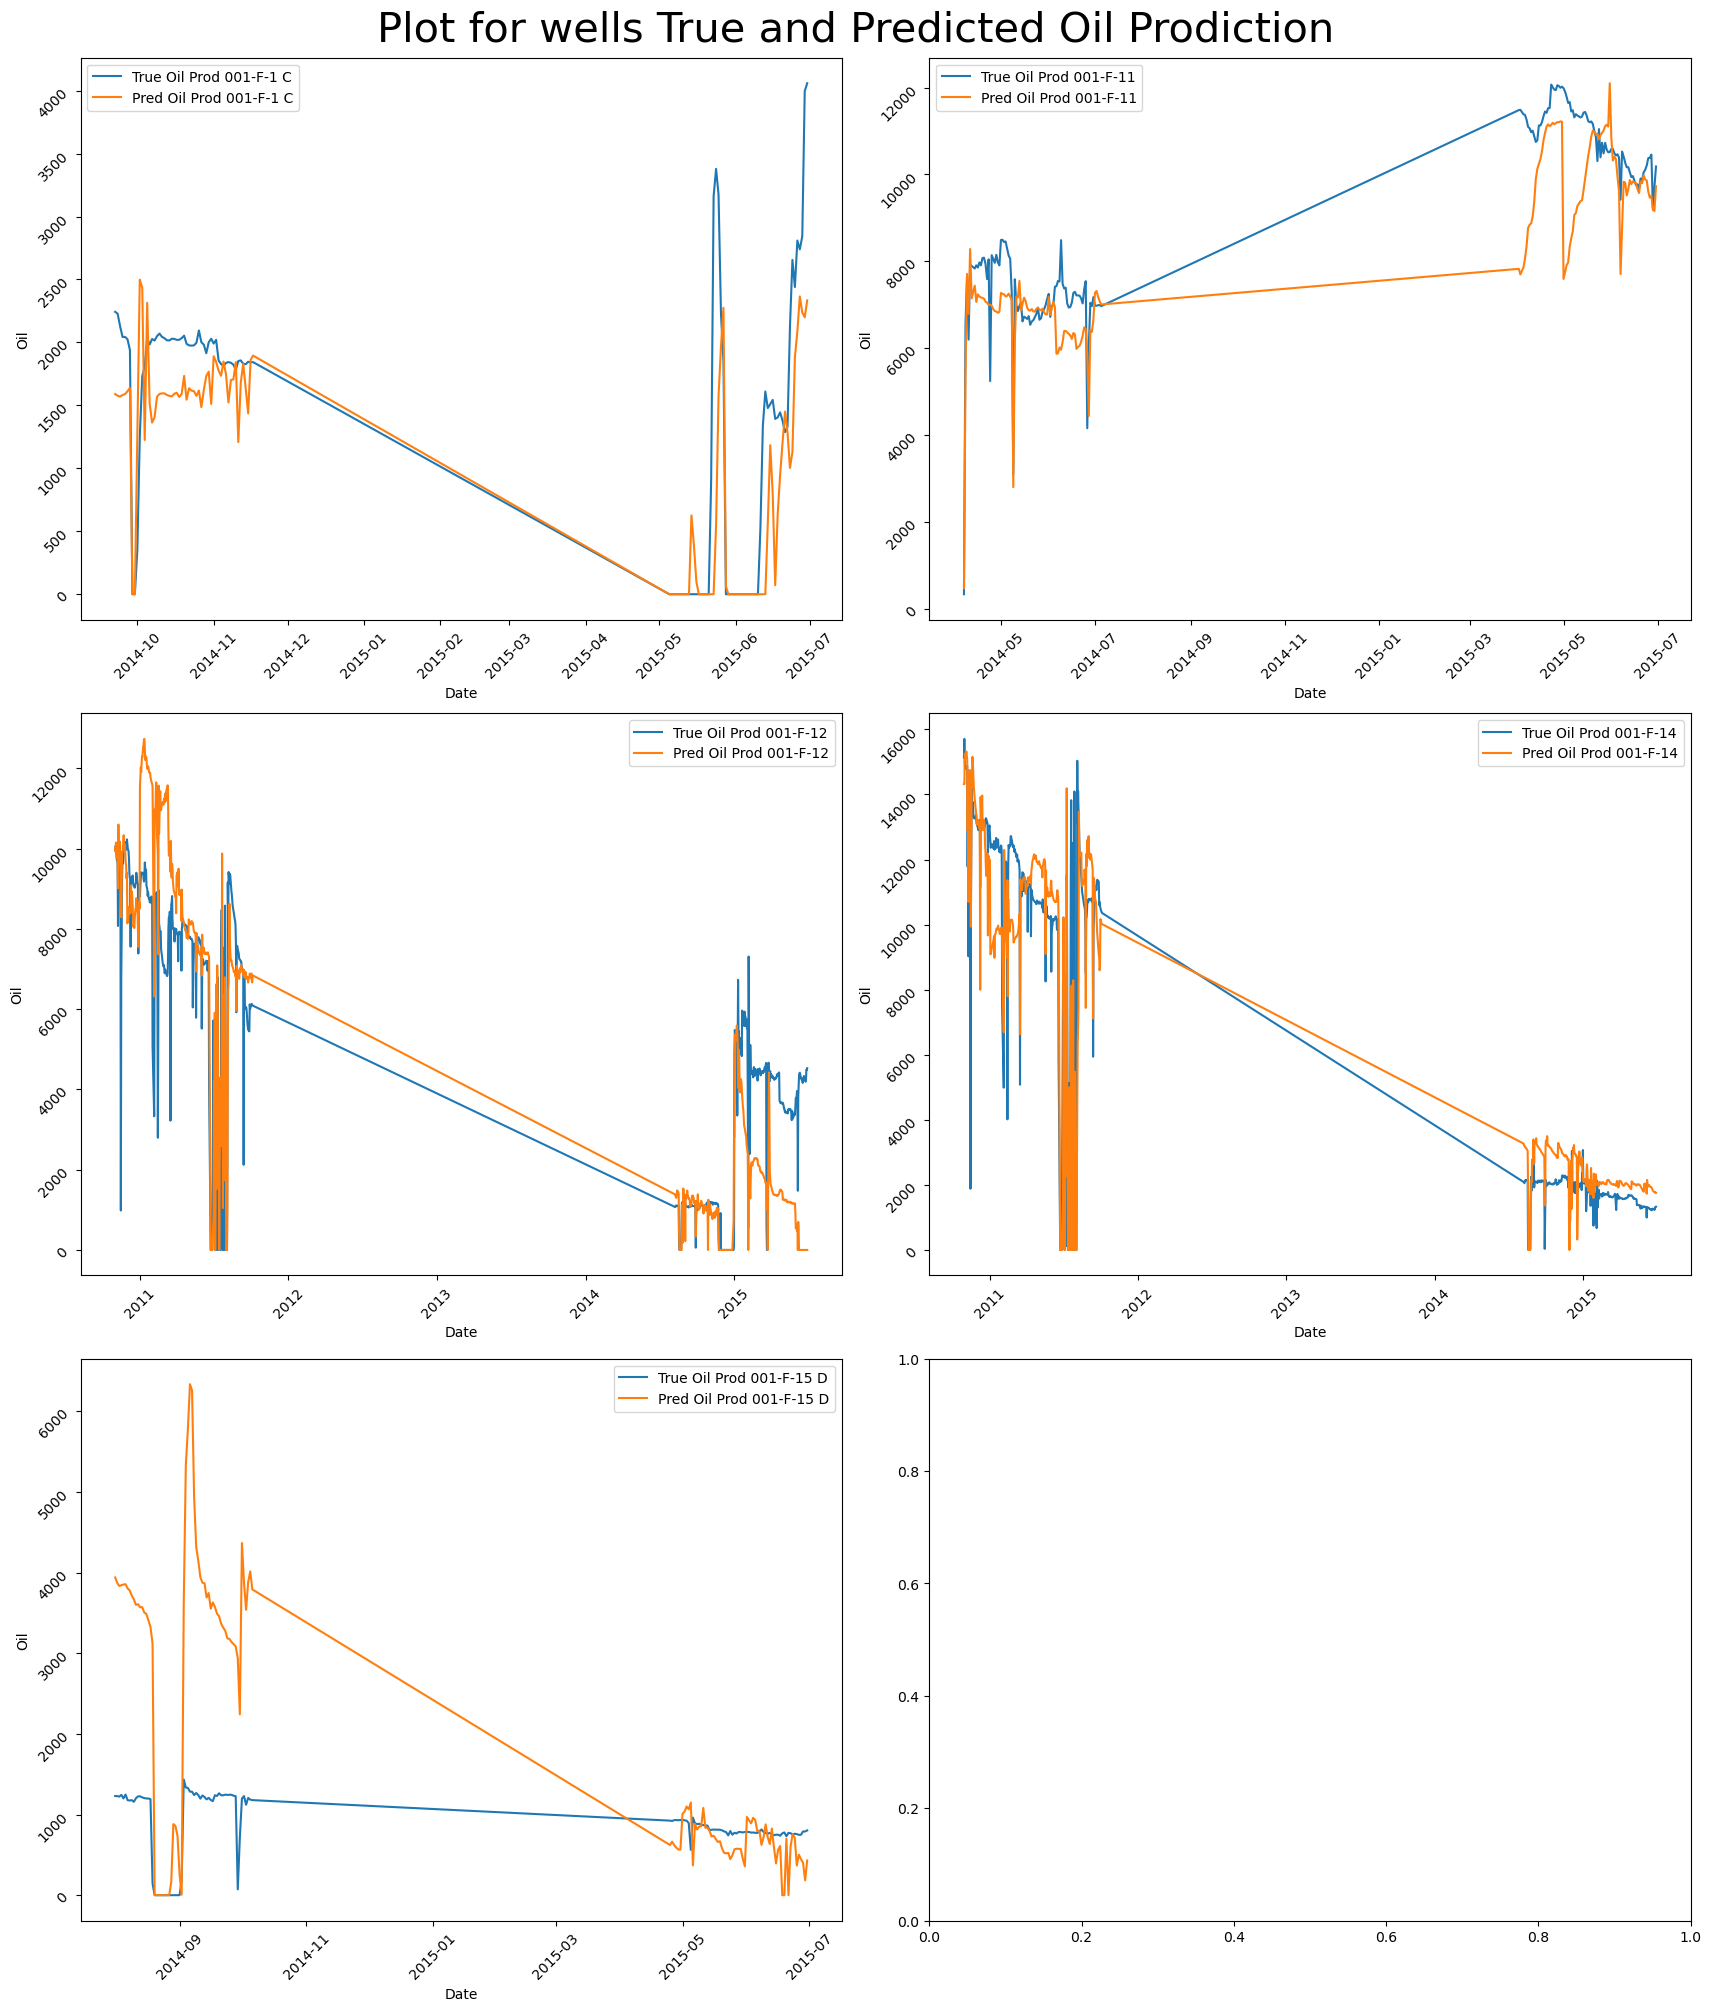

In [121]:
test_scaled_ann_tuned = process_prediction(scaler, empty_test_df, test_scaled, annpr_tuned, value_predicted='oil', 
                                    unique_wells=unique_wells, report=True)

In [123]:
# Saving the best model
hypermodel.save('best_ann_60_best.h5')

<a name="mod_choice"></a>
## Recommendation
On the test data, the ANN had better performance than the SVR and thus was used in Predictions. 

ANN Rmse from above = 1757.286

SVR Rmse from above = 2174.798


## Tuning ANN to predict Water

In [ ]:
water_feats = [a for a in use_feats]

# adding oil and gas to use as features
water_feats.append('oil')
water_feats.append('gas')

In [63]:
def model_builder(hp):
    model = keras.Sequential()
    tf.keras.Input(shape=(62,))

  
    for i in range(hp.Int('layer', 2, 15)):
        model.add(Dense(hp.Int('units_'+ str(i), min_value=32, max_value=512, step=32), kernel_initializer='normal',
                    activation='relu'))  

    hp_learning_rate = hp.Choice('learning_rate', values=[0.001, 0.003, 0.005, 0.01, 0.03])
  
    model.add(Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(),
                metrics=['mse'])

    return model

In [67]:
tuner = kt.RandomSearch(model_builder,
                     objective=kt.Objective("val_mse", direction="min"),
                     max_trials=50,
                     executions_per_trial=3,
                     directory='my_dir6',
                     project_name='intro_to_kt')

In [68]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

In [69]:
tuner.search(train_scaled.drop(['water', 'Gas-oil ratio'], axis=1)[water_feats],train_scaled[['water']], epochs=50, validation_split=0.2,
             callbacks=[stop_early], batch_size =32)

# Getting the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 50 Complete [00h 05m 25s]
val_mse: 0.32860852777957916

Best val_mse So Far: 0.12264638394117355
Total elapsed time: 03h 16m 39s


In [70]:
tuner.results_summary()

Results summary
Results in my_dir6\intro_to_kt
Showing 10 best trials
Objective(name="val_mse", direction="min")

Trial 21 summary
Hyperparameters:
layer: 2
units_0: 384
units_1: 288
learning_rate: 0.005
units_2: 160
units_3: 480
units_4: 128
units_5: 320
units_6: 96
units_7: 64
units_8: 352
units_9: 320
units_10: 384
units_11: 128
units_12: 384
units_13: 384
units_14: 96
Score: 0.12264638394117355

Trial 42 summary
Hyperparameters:
layer: 3
units_0: 416
units_1: 512
learning_rate: 0.005
units_2: 352
units_3: 96
units_4: 32
units_5: 480
units_6: 32
units_7: 160
units_8: 512
units_9: 320
units_10: 256
units_11: 384
units_12: 64
units_13: 96
units_14: 448
Score: 0.13788782308499017

Trial 31 summary
Hyperparameters:
layer: 4
units_0: 224
units_1: 128
learning_rate: 0.005
units_2: 224
units_3: 224
units_4: 384
units_5: 320
units_6: 480
units_7: 96
units_8: 416
units_9: 256
units_10: 128
units_11: 448
units_12: 32
units_13: 256
units_14: 384
Score: 0.14348158985376358

Trial 34 summary
Hyp

In [81]:
best_hps = tuner.get_best_hyperparameters(num_trials=15)[4]

In [82]:
# Building the model with the optimal hyperparameters and train it on the data for 50 epochs to get the best epoch
model = tuner.hypermodel.build(best_hps)
history = model.fit(train_scaled.drop(['water', 'Gas-oil ratio'], axis=1)[water_feats],train_scaled[['water']],
                    epochs=100, validation_split=0.2, batch_size =32)

val_acc_per_epoch = history.history['val_mse']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/100
130/130 [==============================] - 10s 33ms/step - loss: 1.4198 - mse: 1.4198 - val_loss: 0.7544 - val_mse: 0.7544
Epoch 2/100
130/130 [==============================] - 5s 37ms/step - loss: 0.5645 - mse: 0.5645 - val_loss: 0.5821 - val_mse: 0.5821
Epoch 3/100
130/130 [==============================] - 5s 37ms/step - loss: 0.4890 - mse: 0.4890 - val_loss: 0.5660 - val_mse: 0.5660
Epoch 4/100
130/130 [==============================] - 4s 34ms/step - loss: 0.3637 - mse: 0.3637 - val_loss: 0.9333 - val_mse: 0.9333
Epoch 5/100
130/130 [==============================] - 4s 31ms/step - loss: 0.3757 - mse: 0.3757 - val_loss: 1.1045 - val_mse: 1.1045
Epoch 6/100
130/130 [==============================] - 5s 38ms/step - loss: 0.2680 - mse: 0.2680 - val_loss: 1.1985 - val_mse: 1.1985
Epoch 7/100
130/130 [==============================] - 5s 38ms/step - loss: 0.1501 - mse: 0.1501 - val_loss: 0.7099 - val_mse: 0.7099
Epoch 8/100
130/130 [==============================] - 6s 48m

Epoch 62/100
130/130 [==============================] - 3s 23ms/step - loss: 0.0382 - mse: 0.0382 - val_loss: 0.2264 - val_mse: 0.2264
Epoch 63/100
130/130 [==============================] - 3s 23ms/step - loss: 0.0407 - mse: 0.0407 - val_loss: 0.3182 - val_mse: 0.3182
Epoch 64/100
130/130 [==============================] - 3s 23ms/step - loss: 0.0531 - mse: 0.0531 - val_loss: 0.2419 - val_mse: 0.2419
Epoch 65/100
130/130 [==============================] - 3s 22ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.2266 - val_mse: 0.2266
Epoch 66/100
130/130 [==============================] - 3s 23ms/step - loss: 0.0434 - mse: 0.0434 - val_loss: 0.2791 - val_mse: 0.2791
Epoch 67/100
130/130 [==============================] - 3s 22ms/step - loss: 0.0422 - mse: 0.0422 - val_loss: 0.2578 - val_mse: 0.2578
Epoch 68/100
130/130 [==============================] - 3s 22ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.2199 - val_mse: 0.2199
Epoch 69/100
130/130 [==============================] -

In [110]:
# setting seeds to ensure reproduceability
tf.keras.utils.set_random_seed
tf.random.set_seed(42)

def reset_random_seeds():
   os.environ['PYTHONHASHSEED']=str(42)
   tf.random.set_seed(42)
   np.random.seed(42)
   random.seed(42)

def run(x,y):
    reset_random_seeds()
    hypermodel = tuner.hypermodel.build(best_hps)
    hypermodel.fit(x,y,
               epochs=11, validation_split=0.2, batch_size = 64)
    return hypermodel
    
hypermodel = run(train_scaled.drop(['water', 'Gas-oil ratio'], axis=1)[water_feats],train_scaled[['water']])

Epoch 1/11
65/65 [==============================] - 6s 38ms/step - loss: 1.3134 - mse: 1.3134 - val_loss: 0.7056 - val_mse: 0.7056
Epoch 2/11
65/65 [==============================] - 2s 32ms/step - loss: 0.2592 - mse: 0.2592 - val_loss: 0.5288 - val_mse: 0.5288
Epoch 3/11
65/65 [==============================] - 2s 34ms/step - loss: 0.1138 - mse: 0.1138 - val_loss: 0.7311 - val_mse: 0.7311
Epoch 4/11
65/65 [==============================] - 2s 34ms/step - loss: 0.0792 - mse: 0.0792 - val_loss: 0.8203 - val_mse: 0.8203
Epoch 5/11
65/65 [==============================] - 2s 31ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.2465 - val_mse: 0.2465
Epoch 6/11
65/65 [==============================] - 2s 31ms/step - loss: 0.0727 - mse: 0.0727 - val_loss: 0.4962 - val_mse: 0.4962
Epoch 7/11
65/65 [==============================] - 2s 31ms/step - loss: 0.0685 - mse: 0.0685 - val_loss: 0.4443 - val_mse: 0.4443
Epoch 8/11
65/65 [==============================] - 2s 31ms/step - loss: 0.0567 - m

In [111]:
annpr_tuned_w = hypermodel.predict(test_scaled.drop(['water', 'Gas-oil ratio'], axis=1)[water_feats])

55/55 [==============================] - 1s 7ms/step


Find the metrics summary below


metrics    values
0    rmse  9387.593
1     mae  5837.093
2      r2     0.257
3   rrmse    86.194
4     mbe -2374.534



Plotting True values (X axis) vs Predicted values (Y axis)


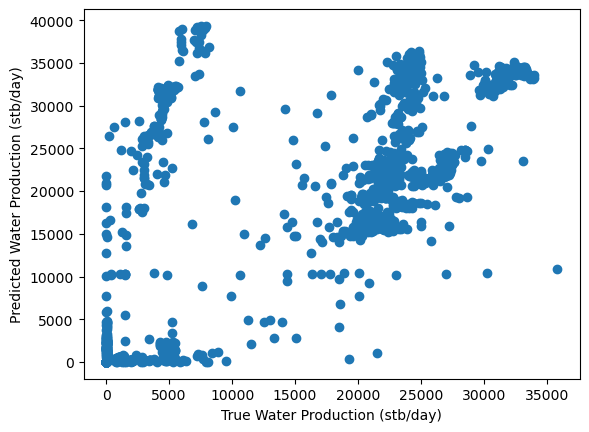

Plotting Well Level Performance


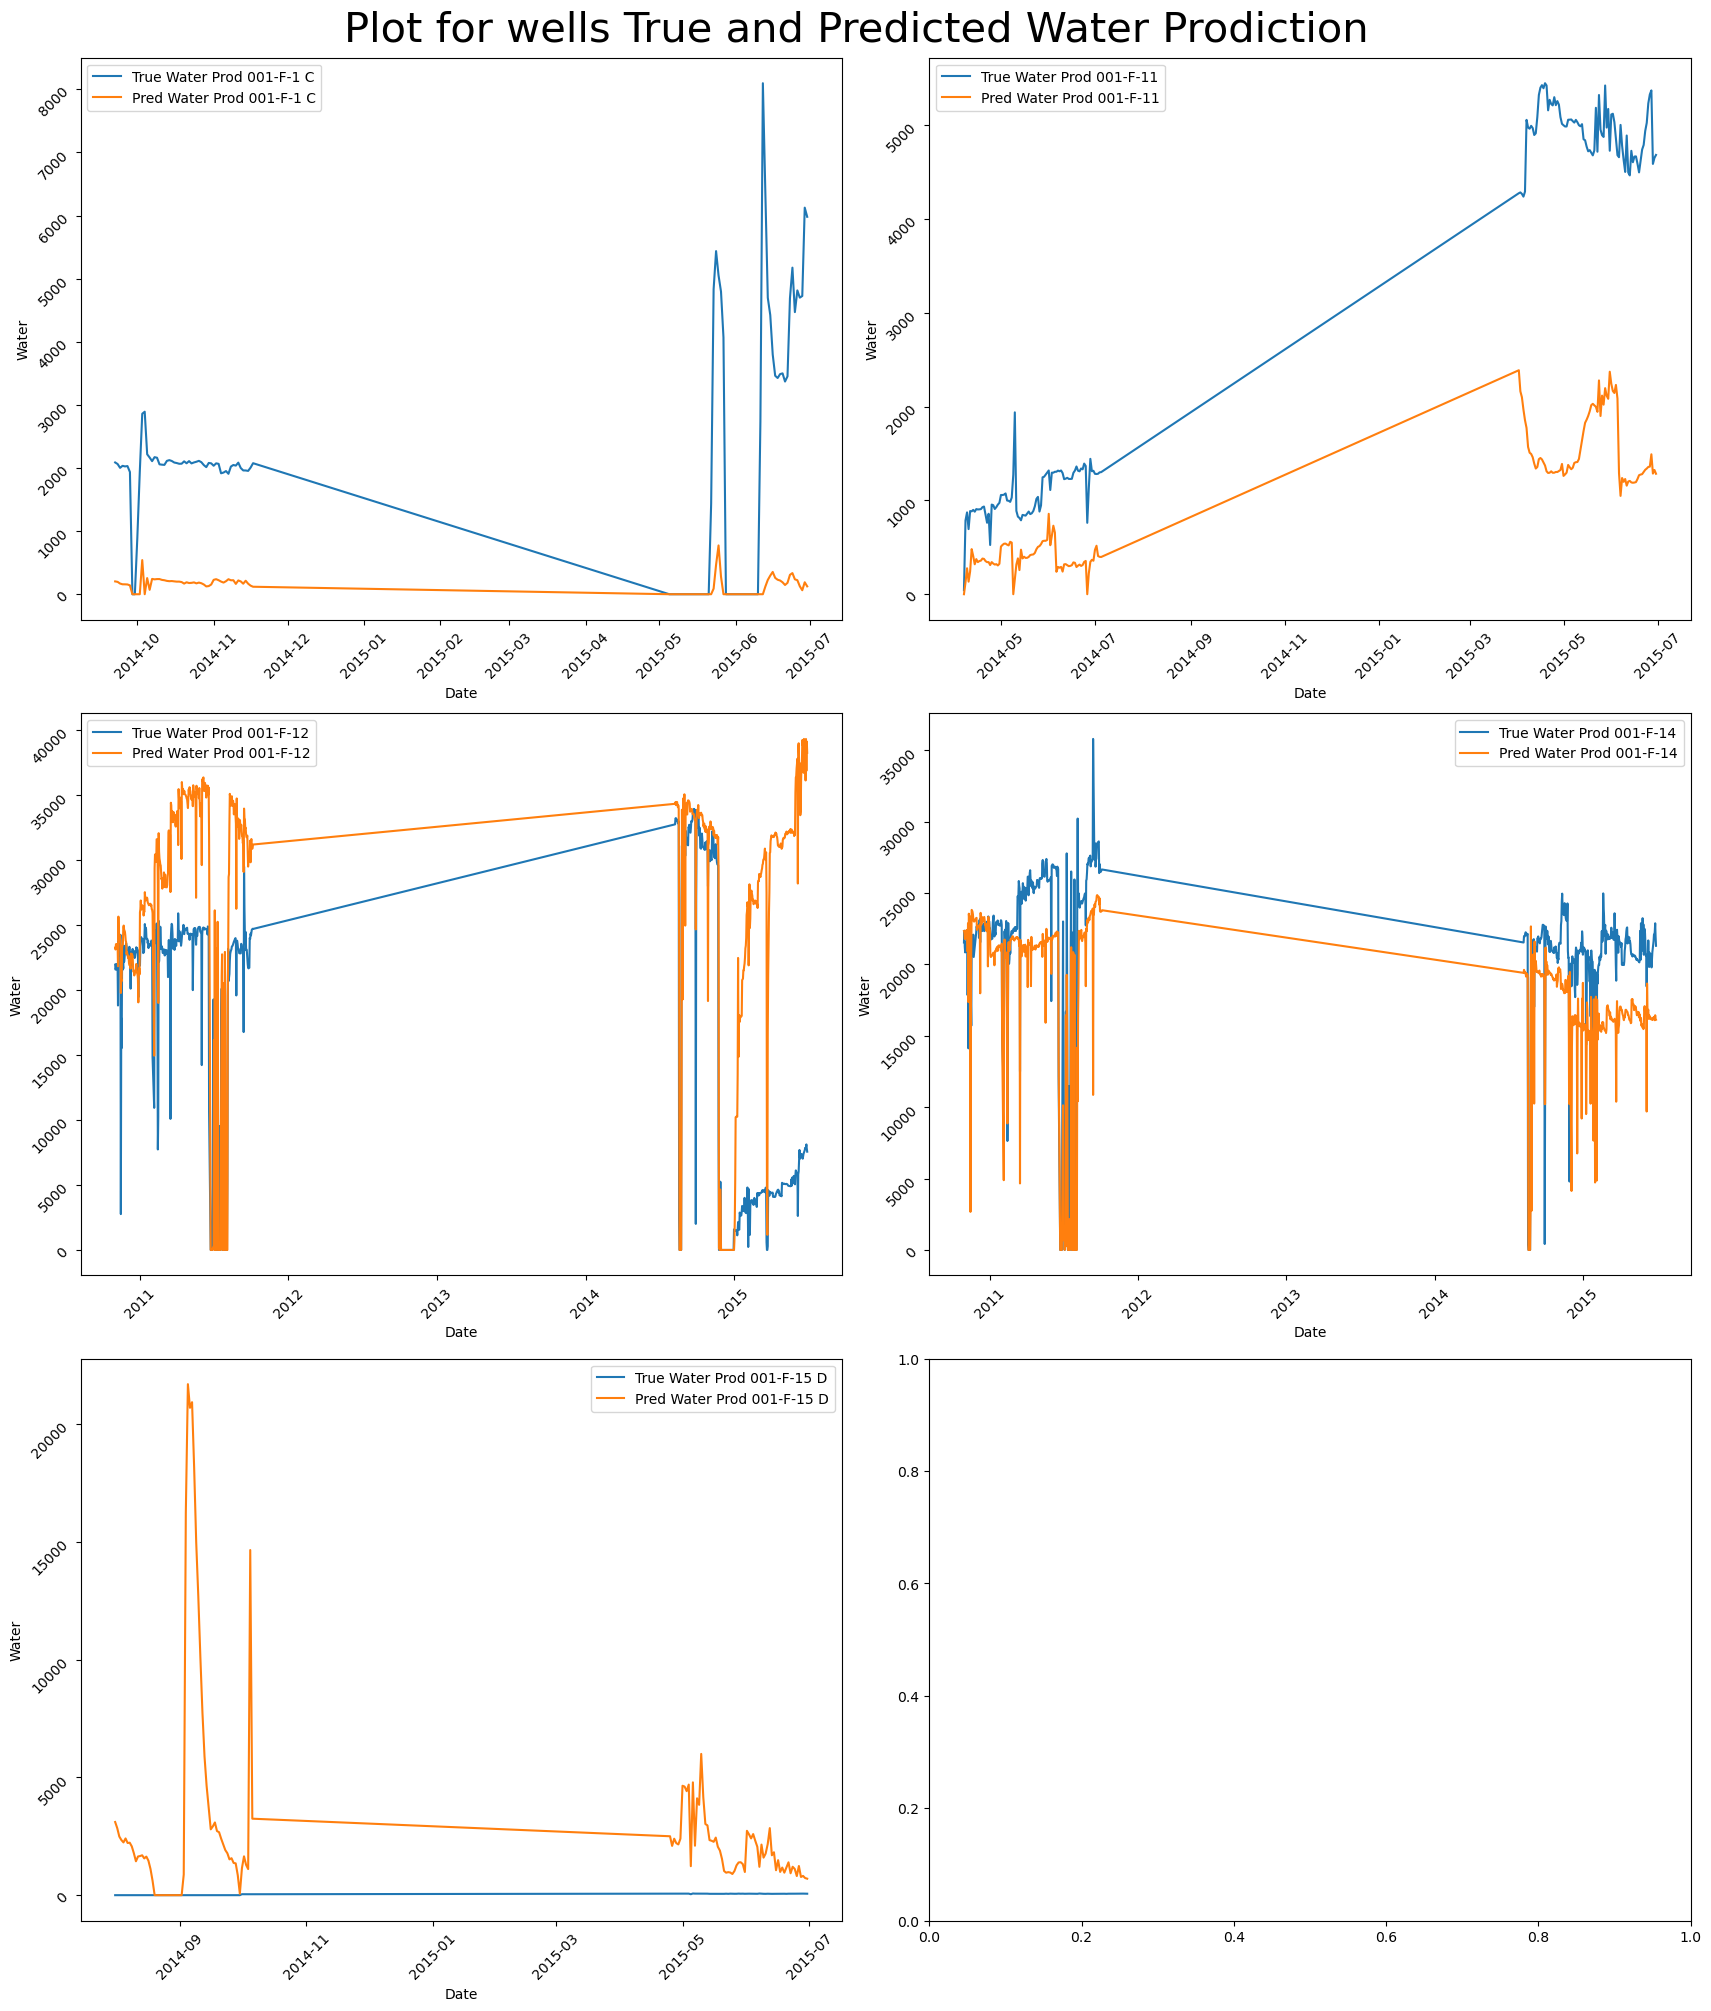

In [112]:
# Getting the performance of the ANN with Visuals
test_scaled_ann = process_prediction(scaler, empty_test_df, test_scaled, annpr_tuned_w, value_predicted='water', 
                                    unique_wells=unique_wells, report=True)

In [106]:
#hypermodel.save('best_water_v2.h5')

<a name="test_pr"></a>
## 7. Prediction on Test Data

In [160]:
# Creating a pipeline to prepare the test data for prediction
def prepare_data(unscaled_train, unscaled_test, data_split=0.15):
    rename_map={'PRODUCTION DATE':'date', 'Downhole Pressure (PSI)':'Downhole_p', 'Downhole Temperature (Kelvin)':'Downhole_t',
                'Average Tubing Pressure':'Average_tp', 'Annulus Pressure (PSI)':'Annulus_p', 'AVG WHP (PSI)':'whp',
                'Oil Production (stb/day)':'oil', 'Gas Volume (scf/day)':'gas', 'Water Production (stb/day)':'water'}
    
    unscaled_test=unscaled_test.dropna(subset=unscaled_test.columns[:13])
    unscaled_test['PRODUCTION DATE']=unscaled_test['PRODUCTION DATE'].apply(slice_)
    unscaled_test['PRODUCTION DATE']=pd.to_datetime(unscaled_test['PRODUCTION DATE'], dayfirst=True)
    
    real_train=unscaled_train.copy()
    real_train.rename(columns=rename_map, inplace=True)
    real_test=unscaled_test.copy()
    real_test.rename(columns=rename_map, inplace=True)
    #real_test['date']=pd.to_datetime(real_test['date'])
    #print(real_test.info(), 333)
    
    unnecessary_columns=['N_WELL_BORE_CODE', 'WELL_BORE_CODE', 'FLOW_KIND', 'WELL_TYPE', 'Field Name']
    
    real_train.drop(unnecessary_columns, axis=1, inplace=True)
    real_test.drop(unnecessary_columns, axis=1, inplace=True)
    real_train=real_train[real_train['Gas-oil ratio']<2000]
    
    real_train.sort_values(['WellBore Name', 'date'], inplace=True)
    real_test.sort_values(['WellBore Name', 'date'], inplace=True)
    
    real_train.fillna(method='bfill', inplace=True)
    
    # getting the extra features
    extra_features_train = get_features(real_train.copy(), features=float_cols[:6])
    extra_features_test = get_features(real_test.copy(), features=float_cols[:6])

    all_cols = extra_features_train.columns[2:]

    for col in all_cols:
        extra_features_train[col]=extra_features_train[col].astype('float64')
        if col != 'Gas-oil ratio':
            extra_features_test[col]=extra_features_test[col].astype('float64')

    drop_cols=['date']

    empty_train_df = pd.DataFrame(columns=extra_features_train.columns)
    empty_test_df = pd.DataFrame(columns=extra_features_train.columns)

    for well_ in unique_wells:
        df=extra_features_train.copy()
        df=df[df['WellBore Name']==well_]

        # sorting by date
        df.sort_values('date', inplace=True)
        rows=df.shape[0]
        _perc=data_split*rows
        end_perc_start=int(rows-_perc)
        test=df.iloc[end_perc_start:, :]
        train=df.iloc[:end_perc_start, :]

        # appending to empty dataframe
        empty_train_df=pd.concat([empty_train_df,train], axis=0)
        empty_test_df=pd.concat([empty_test_df,test], axis=0)
        
    # features with one hot encoding
    extra_features_train_=pd.get_dummies(extra_features_train)
    extra_features_test_=pd.get_dummies(extra_features_test)
    
    # features with one hot encoding
    empty_train_df_=pd.get_dummies(empty_train_df)
    empty_test_df_=pd.get_dummies(empty_test_df)

    # performing feature scaling of the training and testing datasets
    scaler1, train_scaled1, test_scaled1 = scale_datasets(empty_train_df_.drop(drop_cols, axis=1), 
                                                       empty_test_df_.drop(drop_cols, axis=1))
    scaler2, train_scaled2, test_scaled2 = scale_datasets(empty_train_df_[extra_features_test_.columns].drop(drop_cols, axis=1), 
                                                       extra_features_test_.drop(drop_cols, axis=1))

    return unscaled_train, unscaled_test, real_train, real_test, extra_features_test, extra_features_test_,empty_train_df, empty_test_df, scaler1, train_scaled1, test_scaled1, scaler2, train_scaled2, test_scaled2

In [161]:
# Loading the datasets
train=pd.read_excel('dseats_2024_training_dataset.xlsx')
test=pd.read_csv('dseats_2024_validation_dataset.csv')

In [162]:
# Using the last 15% as validation and others as training and tuning our model for 1 epoch to enable learning on most of the
# train data
unscaled_train, unscaled_test, real_train, real_test, extra_features_test, extra_features_test_,empty_train_df, empty_test_df, scaler1, train_scaled1, test_scaled1, scaler2, train_scaled2, test_scaled2 = prepare_data(train, test, data_split=0.15) 

In [163]:
# Loading v1 model for making oil prediction on test data. Tuning on 1 epoch since we have new data
tf.keras.utils.set_random_seed
tf.random.set_seed(42)
X_tr = train_scaled2.drop(targets, axis=1)[use_feats]
y_tr = train_scaled2[['oil']]
y_tr1 = train_scaled2[['gas']]

X_te = test_scaled1.drop(targets, axis=1)[use_feats]
y_te = test_scaled1[['oil']]
y_te1 = test_scaled1[['gas']]
load_mod = tf.keras.models.load_model('best_ann_60_best.h5')
load_mod.fit(X_tr,y_tr, validation_data=[X_te, y_te],
             epochs=1, batch_size= 64)

92/92 [==============================] - 3s 17ms/step - loss: 0.0386 - mse: 0.0386 - val_loss: 0.0166 - val_mse: 0.0166


In [164]:
# Predicting on test data for Oil
final_x = test_scaled2.drop(targets, axis=1)[use_feats]

In [165]:
final_prediction_oil = load_mod.predict(final_x)

65/65 [==============================] - 0s 4ms/step


In [166]:
## Loading v1 model for making prediction on gas. Tuning on 1 epoch since we have new data
tf.keras.utils.set_random_seed
tf.random.set_seed(1292)

load_mod = tf.keras.models.load_model('best_ann_60_best.h5')
load_mod.fit(X_tr,y_tr1, validation_data=[X_te, y_te1],
             epochs=1, batch_size= 64)

92/92 [==============================] - 3s 16ms/step - loss: 0.0424 - mse: 0.0424 - val_loss: 0.0193 - val_mse: 0.0193


In [167]:
final_prediction_gas = load_mod.predict(final_x)

65/65 [==============================] - 0s 4ms/step


In [168]:
## Fitting Scaler on oil and gas only from training data to be able to get inverse
scaler_ = StandardScaler()
real_oil_gas = pd.DataFrame(scaler_.fit_transform(empty_train_df[['oil', 'gas']]),columns=['oil', 'gas'])

In [169]:
final_prediction_oil_and_gas = np.array([final_prediction_oil[:,0], final_prediction_gas[:,0]])
final_prediction_oil_and_gas = final_prediction_oil_and_gas.transpose()

In [170]:
pred_oil_gas = pd.DataFrame(scaler_.inverse_transform(final_prediction_oil_and_gas),columns = ['oil', 'gas'])

In [171]:
pred_oil_gas

oil          gas
0     1785.001  1419924.875
1      710.259   325285.375
2     1094.229   745869.875
3     1022.220   557116.875
4      987.122   463512.375
...        ...          ...
2070 -2139.295 -2177254.250
2071 -2140.414 -2180776.250
2072 -2142.315 -2184471.250
2073 -2143.306 -2187691.250
2074 -2144.788 -2191189.250

[2075 rows x 2 columns]

In [172]:
# Clipping -ve values to 0
pred_oil_gas['oil']=pred_oil_gas['oil'].apply(clip)
pred_oil_gas['gas']=pred_oil_gas['gas'].apply(clip)

In [173]:
## Preparing the unscaled test data to assign the predicted values correctly
unscaled_test=unscaled_test.dropna(subset=unscaled_test.columns[:13])

In [174]:
unscaled_test.sort_values(['WellBore Name', 'PRODUCTION DATE'], inplace=True)

In [175]:
# Adding predictions to df
unscaled_test['Oil Production (stb/day)'] = pred_oil_gas.oil.values
unscaled_test['Gas Volume (scf/day)'] = pred_oil_gas.gas.values

In [176]:
# saving the prediction
unscaled_test.to_csv('official-submission-fix3.csv')

In [177]:
# Viewing the model Architecture (10 fully connected layers)
load_mod.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_82 (Dense)            (None, 448)               27328     
                                                                 
 dense_83 (Dense)            (None, 32)                14368     
                                                                 
 dense_84 (Dense)            (None, 288)               9504      
                                                                 
 dense_85 (Dense)            (None, 224)               64736     
                                                                 
 dense_86 (Dense)            (None, 128)               28800     
                                                                 
 dense_87 (Dense)            (None, 224)               28896     
                                                                 
 dense_88 (Dense)            (None, 416)              

## Using ANN to predict Water

In [186]:
# Loading the datasets
train=pd.read_excel('dseats_2024_training_dataset.xlsx')

# loading the predicted oil and gas
final_pred=pd.read_csv('official-submission-fix3.csv')

In [187]:
water_feats = [b for b in use_feats]
water_feats.append('oil')
water_feats.append('gas')

new_targets=['water', 'Gas-oil ratio']

In [188]:
unscaled_train, unscaled_test, real_train, real_test, extra_features_test, extra_features_test_,empty_train_df, empty_test_df, scaler1, train_scaled1, test_scaled1, scaler2, train_scaled2, test_scaled2 = prepare_data(train, final_pred, data_split=0.15) 

In [189]:
# Loading v2 model for making oil prediction on test data. Tuning on 1 epoch since we have new data
tf.keras.utils.set_random_seed
tf.random.set_seed(800)
X_tr_w = train_scaled1.drop(new_targets, axis=1)[water_feats]
y_tr_w = train_scaled1[['water']]


X_te_w = test_scaled1.drop(new_targets, axis=1)[water_feats]
y_te_w = test_scaled1[['water']]

load_mod = tf.keras.models.load_model('best_water_v2.h5')
load_mod.fit(X_tr_w,y_tr_w, validation_data=[X_te_w, y_te_w],
             epochs=1, batch_size= 64)

92/92 [==============================] - 4s 28ms/step - loss: 0.0494 - mse: 0.0494 - val_loss: 0.4565 - val_mse: 0.4565


In [97]:
annpr_tuned_w = load_mod.predict(test_scaled1.drop(['water', 'Gas-oil ratio'], axis=1)[water_feats])

33/33 [==============================] - 0s 6ms/step


Find the metrics summary below


metrics    values
0    rmse  7734.329
1     mae  5034.613
2      r2     0.532
3   rrmse    68.426
4     mbe -1115.796



Plotting True values (X axis) vs Predicted values (Y axis)


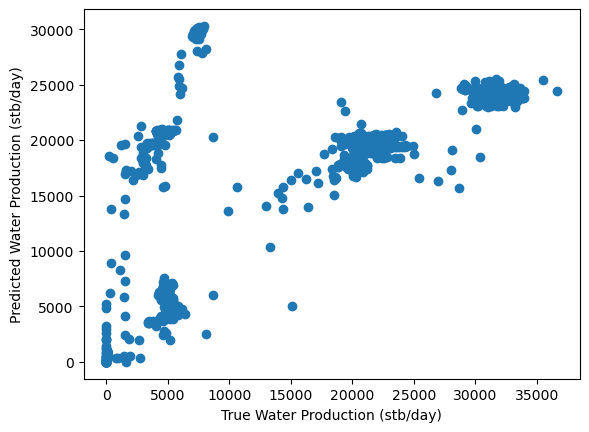

Plotting Well Level Performance


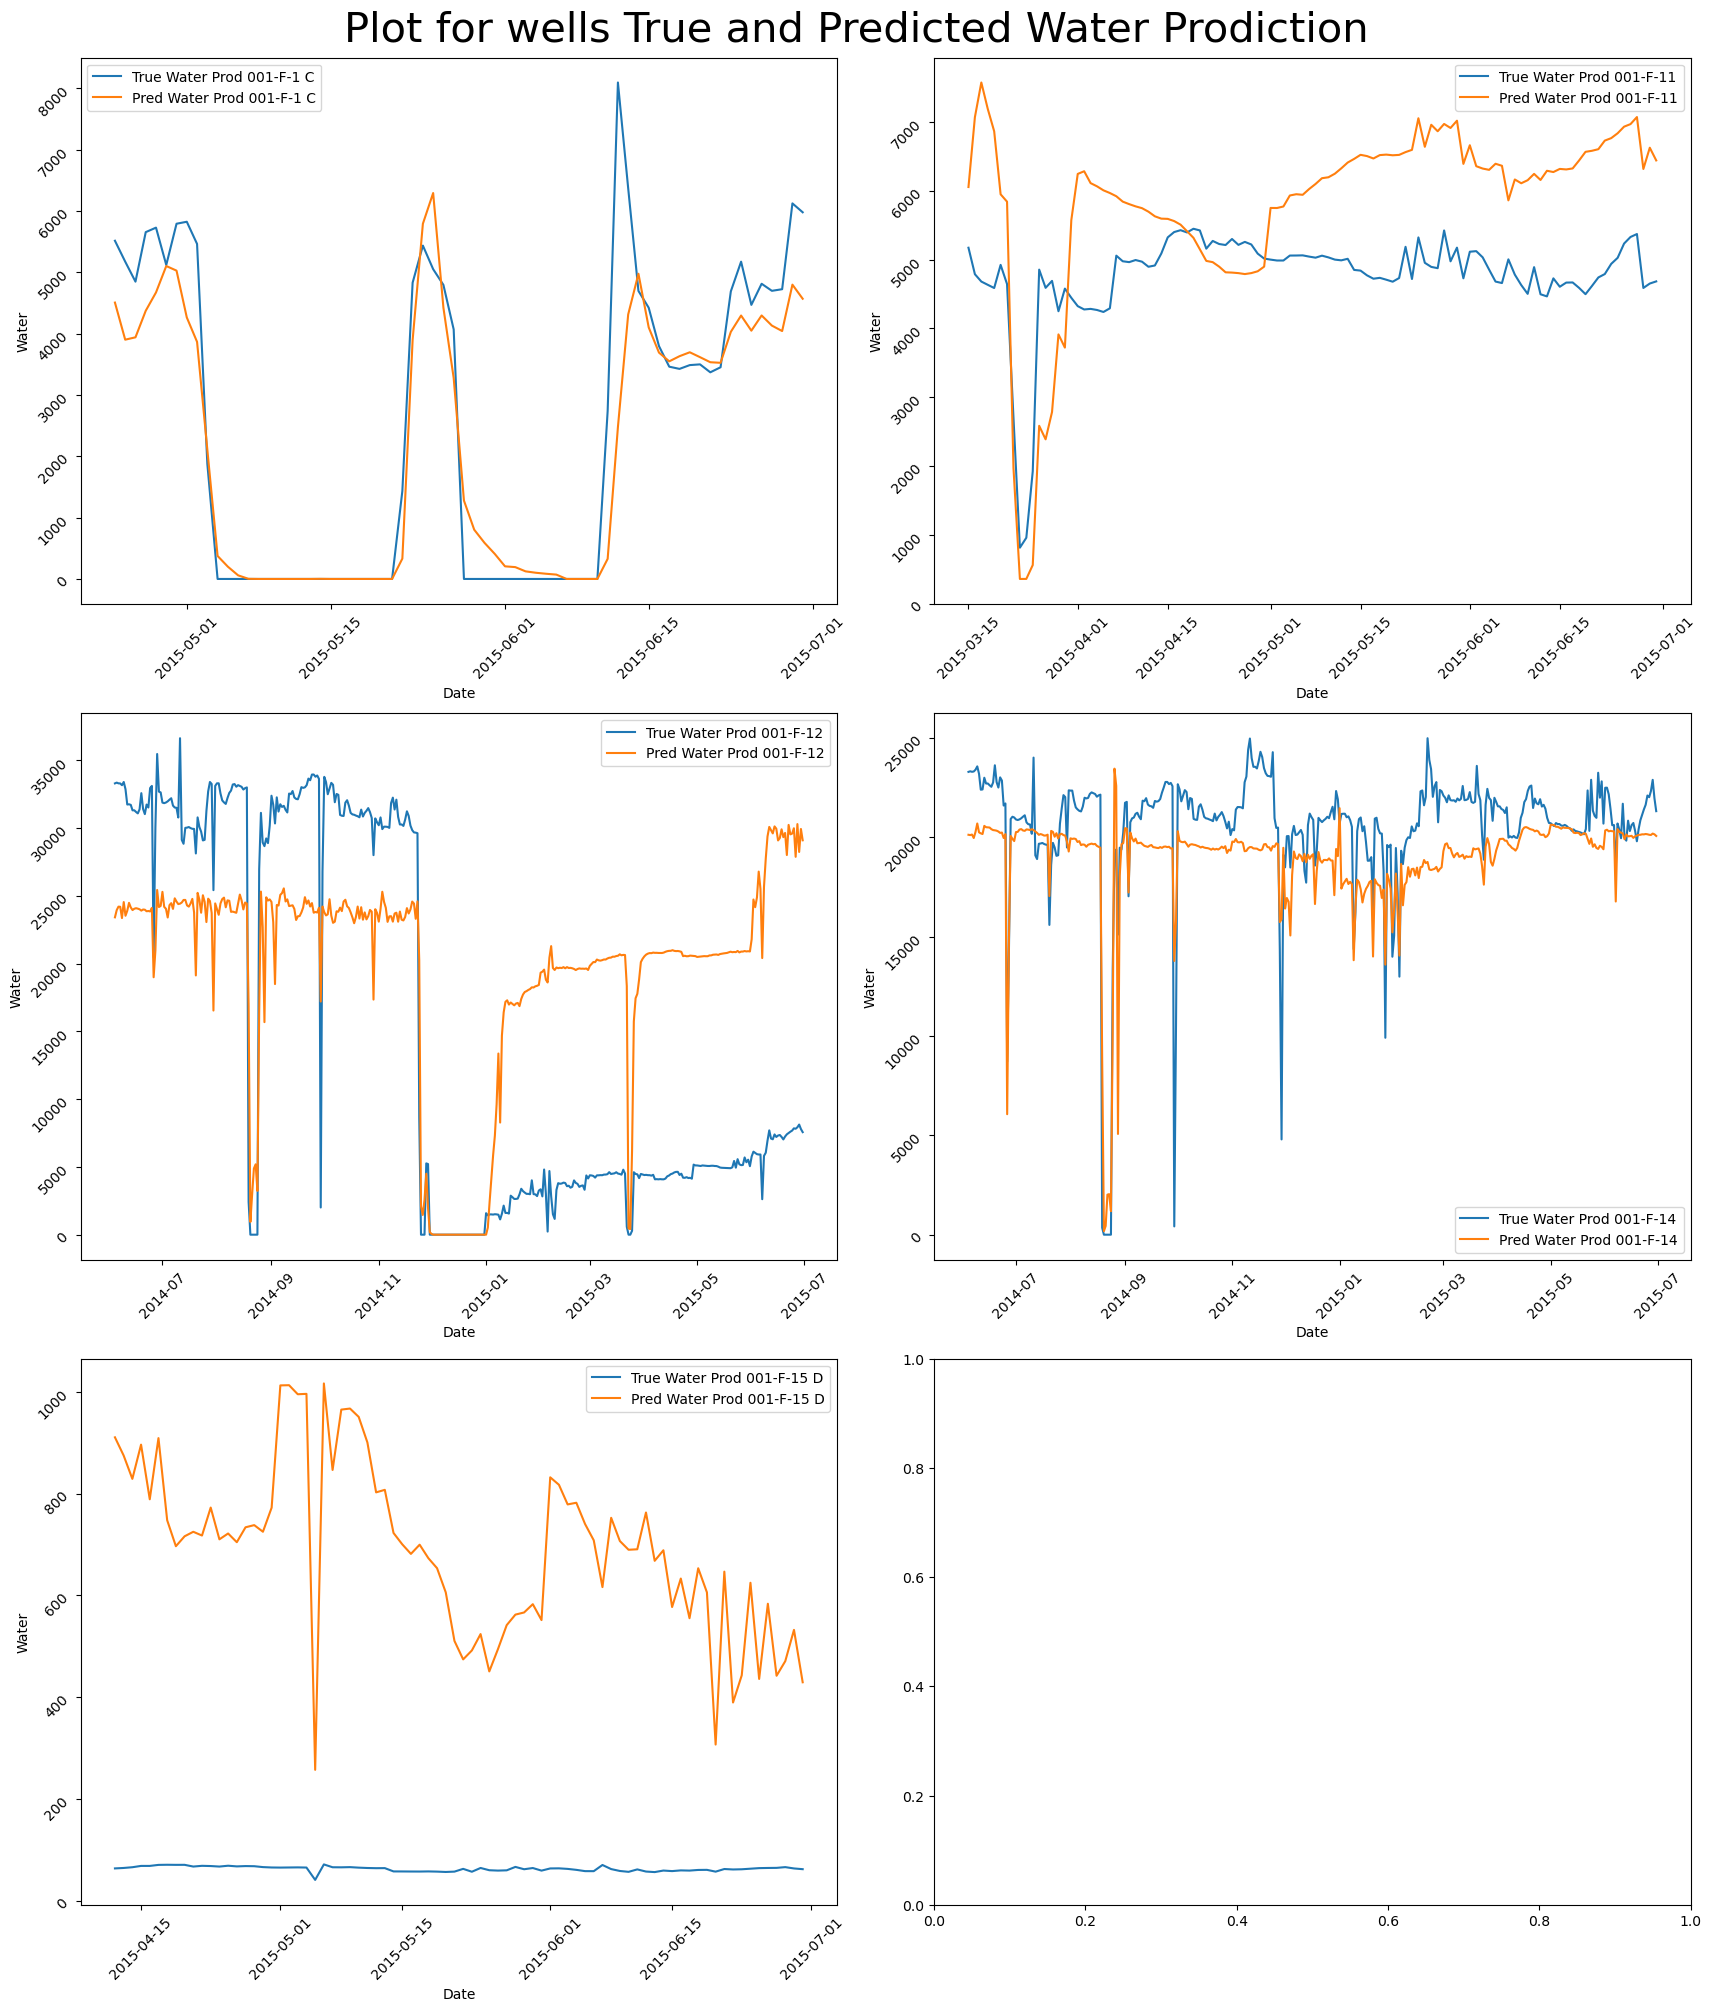

In [98]:
# Getting the performance of the ANN with Visuals on 15% validation data
test_scaled_ann = process_prediction(scaler1, empty_test_df, test_scaled1, annpr_tuned_w, value_predicted='water', 
                                    unique_wells=unique_wells, report=True)

In [190]:
water_real_test=test_scaled2.drop(['water'], axis=1)[water_feats]

In [191]:
final_prediction_water = load_mod.predict(water_real_test)

65/65 [==============================] - 1s 8ms/step


In [192]:
# Fitting Scaler on water only from training data to be able to get inverse
scaler_ = StandardScaler()
water_df = pd.DataFrame(scaler_.fit_transform(empty_train_df[['water']]),columns=['water'])

In [193]:
pred_water = pd.DataFrame(scaler_.inverse_transform(final_prediction_water),columns = ['water'])

In [194]:
pred_water

water
0    2373.865
1     274.363
2    1281.305
3     589.521
4     448.228
...       ...
2070  342.576
2071  313.422
2072  286.102
2073  253.175
2074  246.631

[2075 rows x 1 columns]

In [195]:
# Clipping -ve values to 0
pred_water['water']=pred_water['water'].apply(clip)

In [196]:
# Preparing the unscaled test data to assign the predicted values correctly
unscaled_test['PRODUCTION DATE']=pd.to_datetime(unscaled_test['PRODUCTION DATE'])

In [197]:
unscaled_test.sort_values(['WellBore Name', 'PRODUCTION DATE'], inplace=True)

In [198]:
# Adding predictions to df
unscaled_test['Water Production (stb/day)'] = pred_water.water.values

In [199]:
# saving the prediction
unscaled_test.to_csv('official-full-pred_fn.csv')

In [200]:
unscaled_test['gor']=unscaled_test['Gas Volume (scf/day)']/(unscaled_test['Oil Production (stb/day)']+0.00001)

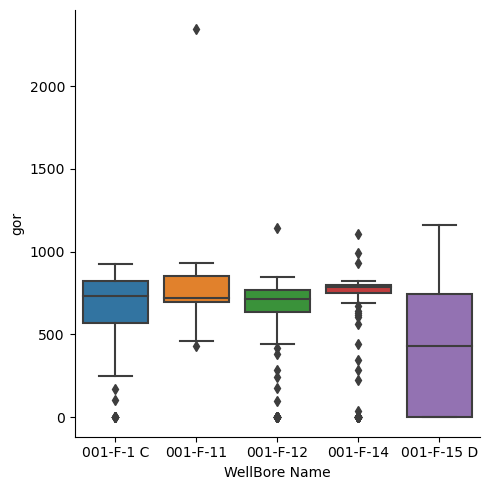

In [201]:
# accessing GOR
sns.catplot(x='WellBore Name', y='gor', data=unscaled_test, kind='box')

GOR looks within expected range 600 -2000

In [202]:
# Getting prediction sum on well level
predicted_prod = unscaled_test.groupby('WellBore Name')['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'].sum()
historical_prod = train.groupby('WellBore Name')['Oil Production (stb/day)', 'Gas Volume (scf/day)', 'Water Production (stb/day)'].sum()